## このノートブックの流れ

1.ひたすら特徴量を入れたり抜いたり

2.最初はとりあえず特徴量を減らすところから（再EDA）

3.途中で外れ値外すの忘れてることに気づいたり、特徴量うまく作れてなかったところを手直ししたり

4.binning、cliping

In [1]:
%matplotlib inline                      

import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
np.set_printoptions(np.inf)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
plt.rcParams['figure.figsize'] = (10, 8)
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)
import xgboost as xgb
import lightgbm as lgb
import time
import pickle
import gc

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

## インポート～結合～前処理

In [222]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
Id = test.Id
target = train.SalePrice

nums = [f for f in train.columns if train.dtypes[f] != 'object']
nums.remove('SalePrice')
nums.remove('Id')
cats = [f for f in train.columns if train.dtypes[f] == 'object']

train['SalePrice'] = np.log(train['SalePrice'])

alldata = pd.concat([train, test], sort=False).reset_index()

alldata['LotFrontage'] = alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for i in mode_fill_li:
    alldata[i].fillna(alldata[i].mode()[0], inplace=True)

for j in None_fill_li:
    alldata[j].fillna('None',inplace=True)

for k in fill_0_li:
    alldata[k].fillna(0, inplace=True)
    
alldata2 = alldata 

alldata.drop([523, 1298], inplace=True)

# 特徴量エンジニアリング

### 003 & 004

In [223]:
alldata['Has_no_Bsmt'] = (alldata['BsmtQual'] == 'None') * 1
alldata['Has_no_Garage'] = (alldata['GarageQual'] == 'None') * 1
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

#Did the modeling happen during the sale year?
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

#setting levels with high count as 1 and the rest as 0
#you can check for them using the value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 
                                                   7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0,
                                                          85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

alldata['GarageStatus'] = alldata2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
alldata['BsmtStatus'] = alldata2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
alldata['FirePlaceStatus'] = alldata2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
alldata['PoolStatus'] = alldata2['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

alldata['cond_mult_qual'] = (alldata2['OverallCond'] * alldata2['OverallQual']) / 100.0
alldata['total_porch_area'] = alldata2['WoodDeckSF'] + alldata2['OpenPorchSF'] + alldata2['EnclosedPorch'] + alldata2['3SsnPorch'] + alldata2['ScreenPorch'] 
alldata['HasPorch'] = (alldata["total_porch_area"] != 0) * 1
alldata['Totalsqrfootage'] = (alldata2['BsmtFinSF1'] + alldata2['BsmtFinSF2'] + alldata2['1stFlrSF'] + alldata2['2ndFlrSF'])
alldata['Total_Bathrooms'] = (alldata2['FullBath'] + (0.5 * alldata2['HalfBath']) + alldata2['BsmtFullBath'] + (0.5 * alldata2['BsmtHalfBath']))

alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({5: 0, 4: 0, 3: 0, 2: 1, 1: 1})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'
             , '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF'
             ,'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
alldata["TotalArea"] = alldata[area_cols].sum(axis=1)
alldata["TotalArea1st2nd"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]
alldata['binned_cond_mult_qual'] = pd.cut(alldata['cond_mult_qual'], 10,labels=False)
alldata['binned_'+ 'GarageArea'] = pd.cut(alldata['GarageArea'], 9 ,labels=False)



alldata["Age"] = 2010 - alldata["YearBuilt"]
alldata['binned_Age'] = pd.cut(alldata['Age'], 10,labels=False)
alldata["TimeSinceSold"] = 2010 - alldata["YrSold"]
alldata["SeasonSold"] = alldata["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
alldata["YearsSinceRemodel"] = alldata["YrSold"] - alldata["YearRemodAdd"]

alldata["SimplOverallQual"] = alldata2.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata2.OverallCond.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata['BadCond'] = (alldata2["OverallCond"] < 5) * 1
alldata["SimplPoolQC"] = alldata2.PoolQC.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplGarageCond"] = alldata2.GarageCond.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplGarageQual"] = alldata2.GarageQual.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplFireplaceQu"] = alldata2.FireplaceQu.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplFunctional"] = alldata2.Functional.replace({np.nan: 0, "Sal": 1, "Sev": 1, "Maj2": 2, "Maj1": 2, "Mod": 3, "Min2": 3, "Min1": 3, "Typ": 4})
alldata["SimplKitchenQual"] = alldata2.KitchenQual.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplHeatingQC"] = alldata2.HeatingQC.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplBsmtFinType1"] = alldata2.BsmtFinType1.replace({np.nan: 0, "Unf": 1, "LwQ": 1, "Rec": 1, "BLQ": 2, "ALQ": 2, "GLQ": 2})
alldata["SimplBsmtFinType2"] = alldata2.BsmtFinType2.replace({np.nan: 0, "Unf": 1, "LwQ": 1, "Rec": 1, "BLQ": 2, "ALQ": 2, "GLQ": 2})
alldata["SimplBsmtCond"] = alldata2.BsmtCond.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplBsmtQual"] = alldata2.BsmtQual.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplExterCond"] = alldata2.ExterCond.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
alldata["SimplExterQual"] = alldata2.ExterQual.replace({np.nan: 0, np.inf:0 , "Po": 1, "Fa": 1, "TA": 1, "Gd": 2, "Ex": 2})
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1
                    , "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1
                    , "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2
                    , "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2
                    , "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3
                    , "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4
                    , "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)
alldata.loc[alldata2.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1

alldata["Neighborhood_Good"].fillna(0, inplace=True)

In [224]:
binning = ['GrLivArea','TotalArea', 'Totalsqrfootage','TotalBsmtSF',]

for f in binning:
    p01 = alldata[f].quantile(0.01)
    p99 = alldata[f].quantile(0.99)
    
    alldata[f] = alldata[f].clip(p01, p99)

def getbin(df, col, bins):
    df['binned_'+ col] = pd.cut(df[col], bins ,labels=False)
    return df

alldata = getbin(alldata, 'GrLivArea', 15)
alldata = getbin(alldata, 'TotalArea', 10)
alldata = getbin(alldata, 'Totalsqrfootage', 15)
alldata = getbin(alldata, 'TotalBsmtSF', 7)

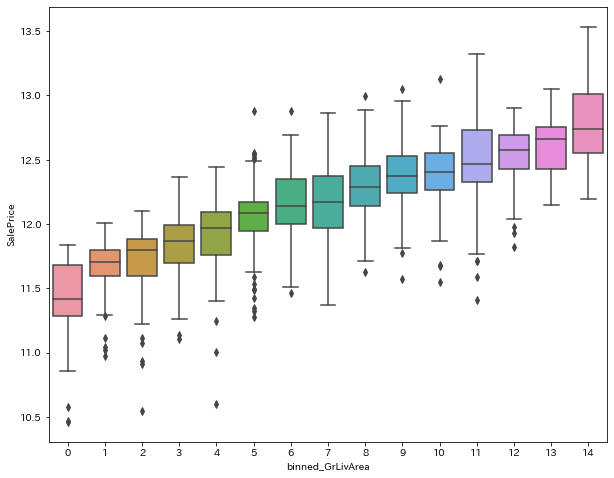

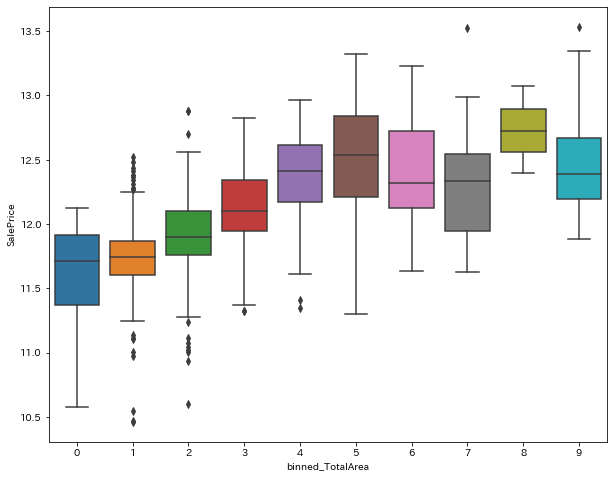

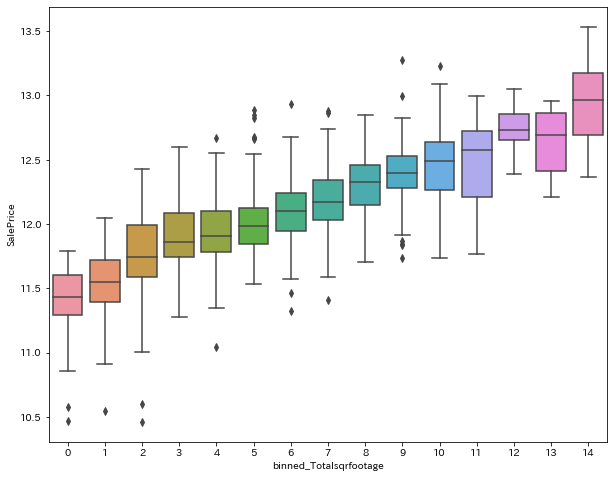

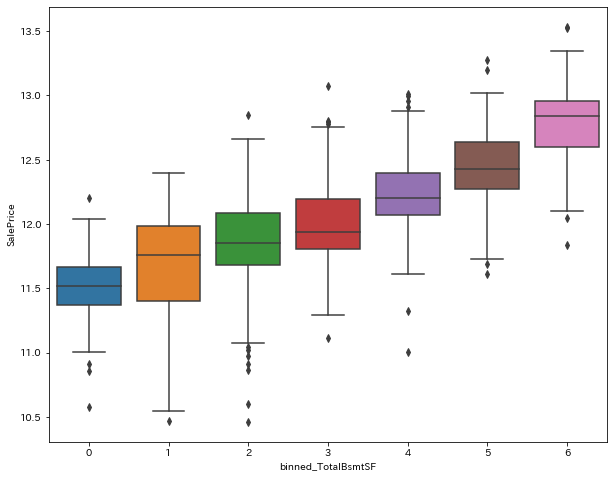

In [225]:
for i in binning:
    sns.boxplot(x='binned_'+str(i), y='SalePrice', data=alldata)
    plt.show()

In [226]:
many_f = pd.read_pickle('../house price/alldata_many_cols.pkl').reset_index()
mean_f = pd.read_pickle('../house price/alldata_mean_cols.pkl').reset_index()
delta_f = pd.read_pickle('../house price/alldata_delta_col.pkl').reset_index()

In [227]:
many_f.drop([523, 1298], inplace=True)
mean_f.drop([523, 1298], inplace=True)
delta_f.drop([523, 1298], inplace=True)

p01 = many_f['OverallQual_mult_GrLivArea'].quantile(0.01)
p99 = many_f['OverallQual_mult_GrLivArea'].quantile(0.99)
many_f['OverallQual_mult_GrLivArea'] = many_f['OverallQual_mult_GrLivArea'].clip(p01, p99)

many_f['binned_'+ 'OverallQual_mult_GrLivArea'] = pd.cut(many_f['OverallQual_mult_GrLivArea'], 4 ,labels=False)

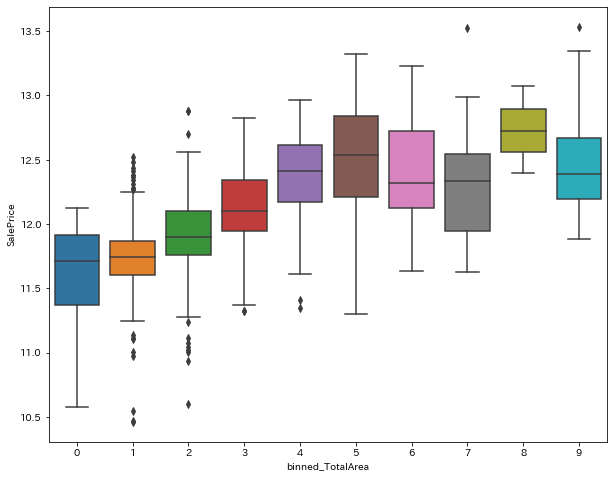

In [228]:
sns.boxplot(x='binned_TotalArea', y='SalePrice', data=alldata)

In [232]:
alldata["Simplbinned_TotalArea"] = \
     alldata2.binned_TotalArea.replace({1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 4, 6 : 4, 7 : 4, 8 : 4, 9 : 4, 10 : 4})

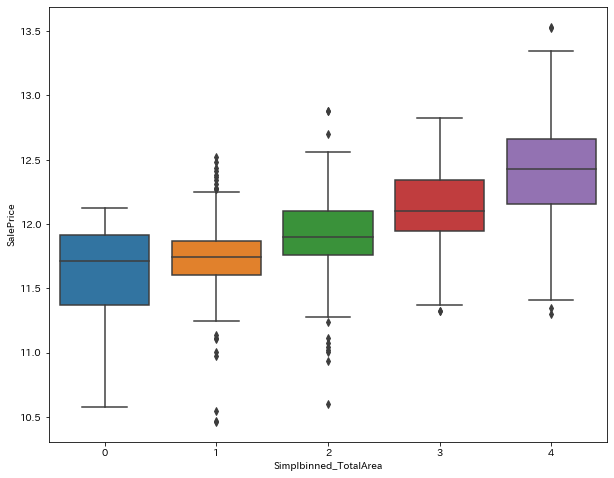

In [233]:
sns.boxplot(x='Simplbinned_TotalArea', y='SalePrice', data=alldata)

In [234]:
np.array(alldata
         .columns)

array(['index', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'G

In [235]:
np.array(mean_f.columns)

array(['index', 'Id', 'SalePrice', 'mean_MSZoning_MSSubClass',
       'mean_MSZoning_LotFrontage', 'mean_MSZoning_LotArea',
       'mean_MSZoning_OverallQual', 'mean_MSZoning_OverallCond',
       'mean_MSZoning_YearBuilt', 'mean_MSZoning_YearRemodAdd',
       'mean_MSZoning_MasVnrArea', 'mean_MSZoning_BsmtFinSF1',
       'mean_MSZoning_BsmtFinSF2', 'mean_MSZoning_BsmtUnfSF',
       'mean_MSZoning_TotalBsmtSF', 'mean_MSZoning_1stFlrSF',
       'mean_MSZoning_2ndFlrSF', 'mean_MSZoning_LowQualFinSF',
       'mean_MSZoning_GrLivArea', 'mean_MSZoning_BsmtFullBath',
       'mean_MSZoning_BsmtHalfBath', 'mean_MSZoning_FullBath',
       'mean_MSZoning_HalfBath', 'mean_MSZoning_BedroomAbvGr',
       'mean_MSZoning_KitchenAbvGr', 'mean_MSZoning_TotRmsAbvGrd',
       'mean_MSZoning_Fireplaces', 'mean_MSZoning_GarageYrBlt',
       'mean_MSZoning_GarageCars', 'mean_MSZoning_GarageArea',
       'mean_MSZoning_WoodDeckSF', 'mean_MSZoning_OpenPorchSF',
       'mean_MSZoning_EnclosedPorch', 'mean_MSZon

In [236]:
np.array(delta_f.columns)

array(['index', 'Id', 'SalePrice', 'delta_mean_MSZoning_MSSubClass',
       'delta_mean_MSZoning_LotFrontage', 'delta_mean_MSZoning_LotArea',
       'delta_mean_MSZoning_OverallQual',
       'delta_mean_MSZoning_OverallCond', 'delta_mean_MSZoning_YearBuilt',
       'delta_mean_MSZoning_YearRemodAdd',
       'delta_mean_MSZoning_MasVnrArea', 'delta_mean_MSZoning_BsmtFinSF1',
       'delta_mean_MSZoning_BsmtFinSF2', 'delta_mean_MSZoning_BsmtUnfSF',
       'delta_mean_MSZoning_TotalBsmtSF', 'delta_mean_MSZoning_1stFlrSF',
       'delta_mean_MSZoning_2ndFlrSF', 'delta_mean_MSZoning_LowQualFinSF',
       'delta_mean_MSZoning_GrLivArea',
       'delta_mean_MSZoning_BsmtFullBath',
       'delta_mean_MSZoning_BsmtHalfBath', 'delta_mean_MSZoning_FullBath',
       'delta_mean_MSZoning_HalfBath', 'delta_mean_MSZoning_BedroomAbvGr',
       'delta_mean_MSZoning_KitchenAbvGr',
       'delta_mean_MSZoning_TotRmsAbvGrd',
       'delta_mean_MSZoning_Fireplaces',
       'delta_mean_MSZoning_GarageYrBlt'

In [237]:
alldata.to_pickle('alldata_008.pkl')

In [238]:
len(alldata)

2917

# 特徴量選択

In [318]:
alldata = pd.read_pickle('../house price/alldata_008.pkl')
np.array(alldata.columns)

array(['index', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'G

In [319]:
alldata1 = alldata[[ 'Id','Simplbinned_TotalArea', 'binned_Age',
       'binned_Totalsqrfootage','binned_TotalBsmtSF', 
       'YearRemodAdd', 'RoofStyle',
       'MasVnrType', 'MasVnrArea', 
       'Foundation', 'binned_cond_mult_qual',
       'BsmtExposure', 'Heating', 'binned_TotalBsmtSF', 
       'CentralAir', 'LowQualFinSF',
       'BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageType', 'GarageFinish', 'GarageCars',
       'binned_GarageArea', 
       'Fence', 'SaleType', 'SaleCondition', 'SalePrice', 
       'Has_no_Bsmt', 'Has_no_Garage',
       'IsElectricalSBrkr',
       'IsGarageDetached', 'YearsSinceRemodel',
       'RecentRemodel', 'VeryNewHouse',  'NewerDwelling', 'GarageStatus',
       'BsmtStatus', 'FirePlaceStatus', 'PoolStatus', 'HasPorch',
       'Total_Bathrooms', 'SaleCondition_PriceDown', 'BoughtOffPlan',
       'SimplOverallCond', 'BadCond', 'SimplPoolQC',
       'SimplFireplaceQu',
       'SimplKitchenQual', 'SimplHeatingQC',
       'SimplBsmtCond','SimplOverallQual',
       'SimplBsmtQual', 'SimplExterQual',
       'NeighborhoodBin', 'Neighborhood_Good', 'binned_GrLivArea']]

In [320]:
#alldata1 = alldata1.merge(delta_f[['Id','delta_mean_LandSlope_OverallQual','delta_mean_Utilities_OverallQual'
                                  #, 'delta_mean_Condition2_OverallQual']], on='Id', how='left')

In [321]:
alldata1 = pd.merge(alldata1, mean_f[['Id']], on='Id', how='left')

In [322]:
alldata1 = pd.merge(alldata1, many_f[['Id']], on='Id', how='left')

In [323]:
alldata1.to_pickle('alldata_search_008.pkl')
alldata1.shape

(2917, 56)

# モデリング

In [324]:
data = pd.read_pickle('../house price/alldata_search_008.pkl')
data.drop('Id', axis=1, inplace=True)
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[data['SalePrice'].notnull()]
test = data[data['SalePrice'].isnull()]
categorical_cols = list(data.select_dtypes(include=['object']).columns)

from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [345]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=3, shuffle=True, random_state=1156)

params = {'objective':'regression',
          'metric': 'rmse',
          'num_leaves':3,
          'learning_rate':0.05,
          'n_estimators':720,
          'max_bin' : 300, 
          'bagging_fraction' : 0.8,
          'bagging_freq' : 5, 
          'feature_fraction' : 0.2319,
          'feature_fraction_seed':9, 
          'bagging_seed':9,
          'min_data_in_leaf' :20, 
          'min_sum_hessian_in_leaf' : 11,
          'importance_type': 'gain'
}

feature_importance_df = pd.DataFrame()
col = list(X_train.columns)
i = 1
feat_df = pd.DataFrame()

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=100,
                      num_boost_round=1000,
                      early_stopping_rounds=4)

    fold_feat_df = pd.DataFrame()
    fold_feat_df["Feature_fold{}".format(i)] = col
    fold_feat_df["Importance_fold{}".format(i)] = model.feature_importance()
    i += 1
    feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
    
    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 4 rounds
[100]	training's rmse: 0.131295	valid_1's rmse: 0.136701
Early stopping, best iteration is:
[169]	training's rmse: 0.118283	valid_1's rmse: 0.129679
Training until validation scores don't improve for 4 rounds
[100]	training's rmse: 0.132421	valid_1's rmse: 0.143838
[200]	training's rmse: 0.117367	valid_1's rmse: 0.129103
Early stopping, best iteration is:
[214]	training's rmse: 0.116369	valid_1's rmse: 0.128212
Training until validation scores don't improve for 4 rounds
[100]	training's rmse: 0.133014	valid_1's rmse: 0.138753
[200]	training's rmse: 0.118295	valid_1's rmse: 0.124159
Early stopping, best iteration is:
[227]	training's rmse: 0.11682	valid_1's rmse: 0.123003
CV: 0.12699704804701695


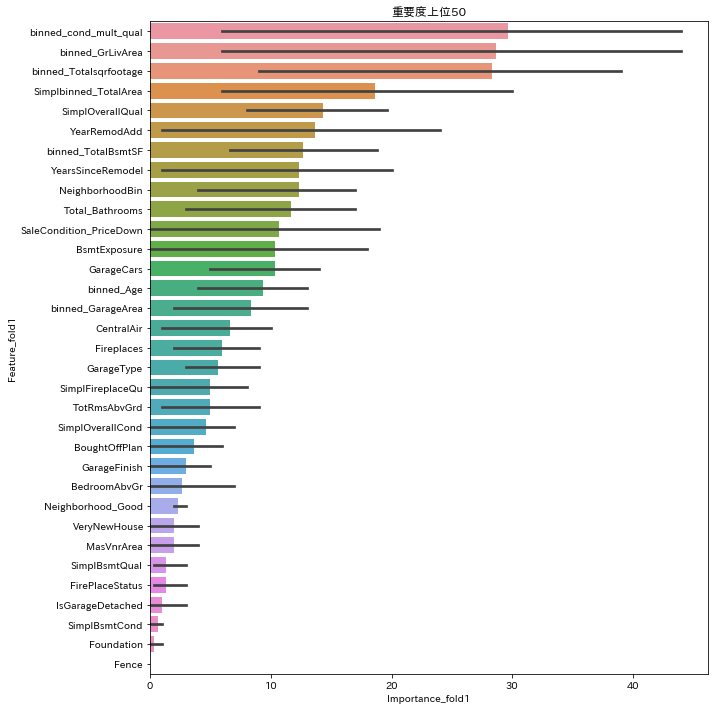

In [341]:
def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    #d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    #e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    feat = pd.concat([a, b, c]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)["Feature_fold1"].values
    plt.figure(figsize=(10,12))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices[:50])
feature_importance_plot(feat_df)

In [338]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance.tail(40)

,importance
binned_cond_mult_qual,57
binned_Totalsqrfootage,48
binned_GrLivArea,42
Simplbinned_TotalArea,30
YearRemodAdd,27
SimplOverallQual,26
binned_Age,21
NeighborhoodBin,20
binned_TotalBsmtSF,20
binned_TotalBsmtSF,19


In [342]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)

## Optuna使ってみた。

In [329]:
drop_features = importance.tail(20).index

In [330]:
data = pd.read_pickle('../house price/alldata_search_008.pkl')
data.drop('Id', axis=1, inplace=True)
data.drop(drop_features, axis=1, inplace=True)
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[data['SalePrice'].notnull()]
test = data[data['SalePrice'].isnull()]
categorical_cols = list(data.select_dtypes(include=['object']).columns)

from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [331]:
import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'num_leaves': trial.suggest_int('num_leaves', 2, 32),
        'learning_rate': trial.suggest_int('num_leaves', 2, 32),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'feature_fraction_seed': trial.suggest_int('feature_fraction_seed', 0, 10), 
        'bagging_seed': trial.suggest_int('bagging_seed', 0, 10), 
        'max_bin': trial.suggest_int('max_bin', 80, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 80),
        'importance_type': 'gain'
    }
            
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=10,
                          num_boost_round=1000,
                          early_stopping_rounds=10)


        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
     
    score = np.sqrt(mean_squared_error(y_train, oof_train))
    return score   


In [332]:
ts = time.time()
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=200)
study.best_params

C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0039e+13	valid_1's rmse: 9.79727e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.11762	valid_1's rmse: 8.20254
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.08752e+12	valid_1's rmse: 9.03863e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.75695	valid_1's rmse: 7.85467
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.701e+12	valid_1's rmse: 9.27029e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.81745	valid_1's rmse: 7.77648


[I 2020-07-24 23:05:59,310] Finished trial#0 with value: 7.9467220195916015 with parameters: {'max_depth': 13, 'num_leaves': 25, 'feature_fraction': 0.5388451063088229, 'bagging_fraction': 0.4616719304791618, 'feature_fraction_seed': 1, 'bagging_seed': 3, 'max_bin': 359, 'min_data_in_leaf': 72}. Best is trial#0 with value: 7.9467220195916015.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.14456e+14	valid_1's rmse: 1.13618e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.6614	valid_1's rmse: 10.4053
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.08652e+14	valid_1's rmse: 1.08791e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.1732	valid_1's rmse: 10.4226
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.06243e+14	valid_1's rmse: 1.05517e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.3865	valid_1's rmse: 10.2382


[I 2020-07-24 23:05:59,666] Finished trial#1 with value: 10.355696156637062 with parameters: {'max_depth': 15, 'num_leaves': 30, 'feature_fraction': 0.7830636194148435, 'bagging_fraction': 0.4331085663661595, 'feature_fraction_seed': 7, 'bagging_seed': 1, 'max_bin': 383, 'min_data_in_leaf': 34}. Best is trial#0 with value: 7.9467220195916015.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.06508e+10	valid_1's rmse: 2.1864e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.41241	valid_1's rmse: 4.4179
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.59174e+10	valid_1's rmse: 1.54446e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.19203	valid_1's rmse: 4.25103
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.80623e+10	valid_1's rmse: 1.75684e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.26246	valid_1's rmse: 4.24634


[I 2020-07-24 23:05:59,996] Finished trial#2 with value: 4.305830085182068 with parameters: {'max_depth': 14, 'num_leaves': 14, 'feature_fraction': 0.5515263888771921, 'bagging_fraction': 0.6773287829116108, 'feature_fraction_seed': 2, 'bagging_seed': 5, 'max_bin': 175, 'min_data_in_leaf': 72}. Best is trial#2 with value: 4.305830085182068.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 78.3381	valid_1's rmse: 77.779
Early stopping, best iteration is:
[1]	training's rmse: 0.64936	valid_1's rmse: 0.686962
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 196.032	valid_1's rmse: 196.486
Early stopping, best iteration is:
[1]	training's rmse: 0.618399	valid_1's rmse: 0.653933
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 100.457	valid_1's rmse: 99.8048
Early stopping, best iteration is:
[1]	training's rmse: 0.626849	valid_1's rmse: 0.618925


[I 2020-07-24 23:06:00,343] Finished trial#3 with value: 0.6538637956254376 with parameters: {'max_depth': 15, 'num_leaves': 3, 'feature_fraction': 0.6414547378143848, 'bagging_fraction': 0.4377193089875928, 'feature_fraction_seed': 1, 'bagging_seed': 9, 'max_bin': 428, 'min_data_in_leaf': 76}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.59422e+10	valid_1's rmse: 5.38444e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.0802	valid_1's rmse: 4.89781
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.90044e+10	valid_1's rmse: 5.73859e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.88657	valid_1's rmse: 5.14413
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.69913e+10	valid_1's rmse: 5.7957e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.00301	valid_1's rmse: 4.9426


[I 2020-07-24 23:06:00,683] Finished trial#4 with value: 4.995994488587557 with parameters: {'max_depth': 14, 'num_leaves': 15, 'feature_fraction': 0.5934620669355279, 'bagging_fraction': 0.6362490404244289, 'feature_fraction_seed': 9, 'bagging_seed': 5, 'max_bin': 99, 'min_data_in_leaf': 28}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.23603e+13	valid_1's rmse: 6.96964e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.49138	valid_1's rmse: 9.15372
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.96576e+13	valid_1's rmse: 7.33291e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.13689	valid_1's rmse: 9.62281
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.10745e+13	valid_1's rmse: 6.99901e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.3226	valid_1's rmse: 9.17897


[I 2020-07-24 23:06:01,030] Finished trial#5 with value: 9.320989695690844 with parameters: {'max_depth': 3, 'num_leaves': 28, 'feature_fraction': 0.9691299036651957, 'bagging_fraction': 0.7916147239838567, 'feature_fraction_seed': 6, 'bagging_seed': 0, 'max_bin': 453, 'min_data_in_leaf': 25}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.53649e+06	valid_1's rmse: 5.5397e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.98484	valid_1's rmse: 1.96151
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.92365e+06	valid_1's rmse: 3.09209e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.93669	valid_1's rmse: 2.0018
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.57651e+06	valid_1's rmse: 6.52576e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.88587	valid_1's rmse: 1.84796


[I 2020-07-24 23:06:01,332] Finished trial#6 with value: 1.9381850590816976 with parameters: {'max_depth': 3, 'num_leaves': 7, 'feature_fraction': 0.4328758616361647, 'bagging_fraction': 0.7470639979737449, 'feature_fraction_seed': 2, 'bagging_seed': 2, 'max_bin': 397, 'min_data_in_leaf': 58}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.53946e+12	valid_1's rmse: 2.50658e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.15822	valid_1's rmse: 7.11636
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.4996e+12	valid_1's rmse: 2.45612e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.95222	valid_1's rmse: 7.08159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.49639e+12	valid_1's rmse: 2.51162e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.97069	valid_1's rmse: 6.88738


[I 2020-07-24 23:06:01,647] Finished trial#7 with value: 7.029163979995594 with parameters: {'max_depth': 14, 'num_leaves': 21, 'feature_fraction': 0.7254550989241239, 'bagging_fraction': 0.8385101281354943, 'feature_fraction_seed': 10, 'bagging_seed': 9, 'max_bin': 393, 'min_data_in_leaf': 48}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.15116e+13	valid_1's rmse: 3.10183e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.26453	valid_1's rmse: 9.31253
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.2705e+13	valid_1's rmse: 5.51042e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.94321	valid_1's rmse: 9.30374
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.83872e+13	valid_1's rmse: 4.94067e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.30008	valid_1's rmse: 9.33847


[I 2020-07-24 23:06:01,962] Finished trial#8 with value: 9.318258756202315 with parameters: {'max_depth': 9, 'num_leaves': 28, 'feature_fraction': 0.7494091888999066, 'bagging_fraction': 0.8829600080069011, 'feature_fraction_seed': 4, 'bagging_seed': 7, 'max_bin': 484, 'min_data_in_leaf': 59}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.29763e+09	valid_1's rmse: 3.40355e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.88859	valid_1's rmse: 3.86696
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.65208e+09	valid_1's rmse: 2.63879e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.66794	valid_1's rmse: 3.61576
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.82571e+09	valid_1's rmse: 2.76588e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.68661	valid_1's rmse: 3.82587


[I 2020-07-24 23:06:02,267] Finished trial#9 with value: 3.7711344345056497 with parameters: {'max_depth': 10, 'num_leaves': 12, 'feature_fraction': 0.44933914648393797, 'bagging_fraction': 0.4680662056382078, 'feature_fraction_seed': 4, 'bagging_seed': 0, 'max_bin': 128, 'min_data_in_leaf': 27}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.62166e+06	valid_1's rmse: 1.57582e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.67681	valid_1's rmse: 1.77364
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.62709e+06	valid_1's rmse: 1.49011e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.60833	valid_1's rmse: 1.64909
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.38564e+06	valid_1's rmse: 1.42515e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.59133	valid_1's rmse: 1.55505


[I 2020-07-24 23:06:02,577] Finished trial#10 with value: 1.6616724277647403 with parameters: {'max_depth': 6, 'num_leaves': 6, 'feature_fraction': 0.6036422484975826, 'bagging_fraction': 0.7945205241029356, 'feature_fraction_seed': 0, 'bagging_seed': 8, 'max_bin': 373, 'min_data_in_leaf': 41}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.84008e+13	valid_1's rmse: 6.80536e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.1587	valid_1's rmse: 10.1333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.7635e+13	valid_1's rmse: 6.83858e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.71039	valid_1's rmse: 10.0174
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.81855e+13	valid_1's rmse: 5.70886e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.98547	valid_1's rmse: 9.9305


[I 2020-07-24 23:06:02,881] Finished trial#11 with value: 10.027421980672681 with parameters: {'max_depth': 14, 'num_leaves': 30, 'feature_fraction': 0.4887252424472478, 'bagging_fraction': 0.7917254394884243, 'feature_fraction_seed': 8, 'bagging_seed': 7, 'max_bin': 196, 'min_data_in_leaf': 73}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.57655e+13	valid_1's rmse: 8.4775e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.6002	valid_1's rmse: 10.3362
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.37724e+13	valid_1's rmse: 8.07828e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.1497	valid_1's rmse: 10.3771
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.18721e+13	valid_1's rmse: 8.4591e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.3498	valid_1's rmse: 10.113


[I 2020-07-24 23:06:03,194] Finished trial#12 with value: 10.276088849541182 with parameters: {'max_depth': 16, 'num_leaves': 30, 'feature_fraction': 0.5695563182426264, 'bagging_fraction': 0.7925202527760628, 'feature_fraction_seed': 5, 'bagging_seed': 8, 'max_bin': 450, 'min_data_in_leaf': 36}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.1877e+08	valid_1's rmse: 5.99591e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.08801	valid_1's rmse: 3.12784
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.20638e+08	valid_1's rmse: 6.29432e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.00732	valid_1's rmse: 3.0471
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.27625e+08	valid_1's rmse: 5.25695e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.0115	valid_1's rmse: 2.98181


[I 2020-07-24 23:06:03,497] Finished trial#13 with value: 3.052832903342455 with parameters: {'max_depth': 14, 'num_leaves': 10, 'feature_fraction': 0.6832982128197118, 'bagging_fraction': 0.5527182110695141, 'feature_fraction_seed': 0, 'bagging_seed': 0, 'max_bin': 396, 'min_data_in_leaf': 71}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.28664e+07	valid_1's rmse: 5.31396e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.40937	valid_1's rmse: 2.39525
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.93922e+07	valid_1's rmse: 3.76344e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.28298	valid_1's rmse: 2.26882
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.21962e+07	valid_1's rmse: 5.38631e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.35055	valid_1's rmse: 2.37597


[I 2020-07-24 23:06:03,811] Finished trial#14 with value: 2.3473408899820183 with parameters: {'max_depth': 8, 'num_leaves': 8, 'feature_fraction': 0.5663553476276313, 'bagging_fraction': 0.471836351638286, 'feature_fraction_seed': 6, 'bagging_seed': 4, 'max_bin': 462, 'min_data_in_leaf': 58}. Best is trial#3 with value: 0.6538637956254376.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.407679	valid_1's rmse: 0.42089
[20]	training's rmse: 0.407679	valid_1's rmse: 0.369852
[30]	training's rmse: 0.407679	valid_1's rmse: 0.381715
Early stopping, best iteration is:
[20]	training's rmse: 0.407679	valid_1's rmse: 0.369852
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.400039
[20]	training's rmse: 0.392893	valid_1's rmse: 0.400039
[30]	training's rmse: 0.392893	valid_1's rmse: 0.402569
Early stopping, best iteration is:
[24]	training's rmse: 0.392893	valid_1's rmse: 0.387507
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.397447	valid_1's rmse: 0.404194
Early stopping, best iteration is:
[5]	training's rmse: 0.397447	valid_1's rmse: 0.379666


[I 2020-07-24 23:06:04,130] Finished trial#15 with value: 0.37907731570270964 with parameters: {'max_depth': 4, 'num_leaves': 2, 'feature_fraction': 0.7031424232868068, 'bagging_fraction': 0.9305571695169248, 'feature_fraction_seed': 8, 'bagging_seed': 7, 'max_bin': 436, 'min_data_in_leaf': 41}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.66754e+13	valid_1's rmse: 3.66687e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.40074	valid_1's rmse: 9.25797
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.99097e+13	valid_1's rmse: 3.05341e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.11331	valid_1's rmse: 9.4984
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.34306e+13	valid_1's rmse: 3.29057e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.1688	valid_1's rmse: 9.0447


[I 2020-07-24 23:06:04,451] Finished trial#16 with value: 9.268874142845482 with parameters: {'max_depth': 5, 'num_leaves': 27, 'feature_fraction': 0.6641459810292017, 'bagging_fraction': 0.8783848122977256, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 299, 'min_data_in_leaf': 26}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.407679	valid_1's rmse: 0.398223
Early stopping, best iteration is:
[2]	training's rmse: 0.407679	valid_1's rmse: 0.383066
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.413722
Early stopping, best iteration is:
[9]	training's rmse: 0.392893	valid_1's rmse: 0.396836
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.388087	valid_1's rmse: 0.391572
[20]	training's rmse: 0.368054	valid_1's rmse: 0.373297
[30]	training's rmse: 0.368054	valid_1's rmse: 0.384206
Early stopping, best iteration is:
[23]	training's rmse: 0.368054	valid_1's rmse: 0.368644


[I 2020-07-24 23:06:04,769] Finished trial#17 with value: 0.38302184393387745 with parameters: {'max_depth': 4, 'num_leaves': 2, 'feature_fraction': 0.8523447749679349, 'bagging_fraction': 0.4321079143393906, 'feature_fraction_seed': 6, 'bagging_seed': 1, 'max_bin': 254, 'min_data_in_leaf': 66}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.87832e+12	valid_1's rmse: 3.61446e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.85426	valid_1's rmse: 7.86047
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.73722e+12	valid_1's rmse: 6.64949e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.66455	valid_1's rmse: 7.76701
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.4644e+12	valid_1's rmse: 3.5268e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.65403	valid_1's rmse: 7.5144


[I 2020-07-24 23:06:05,072] Finished trial#18 with value: 7.71534624166462 with parameters: {'max_depth': 6, 'num_leaves': 24, 'feature_fraction': 0.518520340592304, 'bagging_fraction': 0.786822369515664, 'feature_fraction_seed': 3, 'bagging_seed': 7, 'max_bin': 380, 'min_data_in_leaf': 74}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.75314e+13	valid_1's rmse: 1.75522e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.29303	valid_1's rmse: 8.23529
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.76171e+13	valid_1's rmse: 1.76225e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.03184	valid_1's rmse: 8.23186
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.86043e+13	valid_1's rmse: 1.83121e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.209	valid_1's rmse: 8.1047


[I 2020-07-24 23:06:05,388] Finished trial#19 with value: 8.190841500926913 with parameters: {'max_depth': 3, 'num_leaves': 25, 'feature_fraction': 0.8991771456487199, 'bagging_fraction': 0.9772606640199728, 'feature_fraction_seed': 2, 'bagging_seed': 1, 'max_bin': 154, 'min_data_in_leaf': 58}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.0308e+13	valid_1's rmse: 6.06059e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.98491	valid_1's rmse: 9.83101
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.02765e+13	valid_1's rmse: 5.92573e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.70422	valid_1's rmse: 9.87298
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.6512e+13	valid_1's rmse: 5.89746e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.74616	valid_1's rmse: 9.63994


[I 2020-07-24 23:06:05,741] Finished trial#20 with value: 9.781837611553804 with parameters: {'max_depth': 10, 'num_leaves': 29, 'feature_fraction': 0.6877686474835311, 'bagging_fraction': 0.6647232212238778, 'feature_fraction_seed': 9, 'bagging_seed': 4, 'max_bin': 108, 'min_data_in_leaf': 51}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.2516e+11	valid_1's rmse: 2.27525e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.56677	valid_1's rmse: 5.40089
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.78032e+11	valid_1's rmse: 2.85056e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.36552	valid_1's rmse: 5.51792
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.77735e+11	valid_1's rmse: 2.73695e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.50701	valid_1's rmse: 5.47619


[I 2020-07-24 23:06:06,091] Finished trial#21 with value: 5.465214763317992 with parameters: {'max_depth': 6, 'num_leaves': 17, 'feature_fraction': 0.7215918327177815, 'bagging_fraction': 0.9931082592617573, 'feature_fraction_seed': 7, 'bagging_seed': 3, 'max_bin': 115, 'min_data_in_leaf': 79}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 89.7967	valid_1's rmse: 92.5115
Early stopping, best iteration is:
[1]	training's rmse: 0.667812	valid_1's rmse: 0.626043
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 57.5104	valid_1's rmse: 54.6503
Early stopping, best iteration is:
[1]	training's rmse: 0.646089	valid_1's rmse: 0.689255
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 60.8643	valid_1's rmse: 63.3854
Early stopping, best iteration is:
[1]	training's rmse: 0.658844	valid_1's rmse: 0.657373


[I 2020-07-24 23:06:06,390] Finished trial#22 with value: 0.6580636230095095 with parameters: {'max_depth': 3, 'num_leaves': 3, 'feature_fraction': 0.4061059272505462, 'bagging_fraction': 0.7042156380636522, 'feature_fraction_seed': 8, 'bagging_seed': 6, 'max_bin': 298, 'min_data_in_leaf': 69}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.99385e+06	valid_1's rmse: 2.85368e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.72439	valid_1's rmse: 1.72093
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.94932e+06	valid_1's rmse: 2.99263e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.66444	valid_1's rmse: 1.71533
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.916e+06	valid_1's rmse: 2.93928e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.6917	valid_1's rmse: 1.67431


[I 2020-07-24 23:06:06,686] Finished trial#23 with value: 1.7036501673761228 with parameters: {'max_depth': 8, 'num_leaves': 6, 'feature_fraction': 0.9069290391383866, 'bagging_fraction': 0.7130213553211058, 'feature_fraction_seed': 5, 'bagging_seed': 8, 'max_bin': 347, 'min_data_in_leaf': 69}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2102.23	valid_1's rmse: 2043.2
Early stopping, best iteration is:
[1]	training's rmse: 0.983324	valid_1's rmse: 1.04085
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 930.727	valid_1's rmse: 981.332
Early stopping, best iteration is:
[1]	training's rmse: 0.945538	valid_1's rmse: 0.941123
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1653.87	valid_1's rmse: 1650.12
Early stopping, best iteration is:
[1]	training's rmse: 0.951203	valid_1's rmse: 0.948611


[I 2020-07-24 23:06:06,984] Finished trial#24 with value: 0.9779151356920441 with parameters: {'max_depth': 4, 'num_leaves': 4, 'feature_fraction': 0.4263276428983534, 'bagging_fraction': 0.5894134199482725, 'feature_fraction_seed': 3, 'bagging_seed': 1, 'max_bin': 322, 'min_data_in_leaf': 36}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.17866e+10	valid_1's rmse: 2.18201e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.29104	valid_1's rmse: 4.33096
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.08905e+10	valid_1's rmse: 2.13734e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.16044	valid_1's rmse: 4.2351
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.14532e+10	valid_1's rmse: 2.1226e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.22619	valid_1's rmse: 4.18023


[I 2020-07-24 23:06:07,294] Finished trial#25 with value: 4.2492206249110955 with parameters: {'max_depth': 14, 'num_leaves': 13, 'feature_fraction': 0.9674718071391752, 'bagging_fraction': 0.5759599657112553, 'feature_fraction_seed': 2, 'bagging_seed': 8, 'max_bin': 133, 'min_data_in_leaf': 46}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.3808e+14	valid_1's rmse: 2.42174e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.98689	valid_1's rmse: 10.2488
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.44309e+14	valid_1's rmse: 2.39102e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.54473	valid_1's rmse: 9.3874
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.3997e+14	valid_1's rmse: 2.43438e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.69906	valid_1's rmse: 9.66554


[I 2020-07-24 23:06:07,592] Finished trial#26 with value: 9.773835376382678 with parameters: {'max_depth': 2, 'num_leaves': 32, 'feature_fraction': 0.8115099578633265, 'bagging_fraction': 0.9870706171533279, 'feature_fraction_seed': 6, 'bagging_seed': 5, 'max_bin': 327, 'min_data_in_leaf': 36}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.60364e+08	valid_1's rmse: 3.5011e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.81917	valid_1's rmse: 2.72717
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.58087e+08	valid_1's rmse: 3.6693e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.70554	valid_1's rmse: 2.77938
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.64972e+08	valid_1's rmse: 3.59057e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.7581	valid_1's rmse: 2.69268


[I 2020-07-24 23:06:07,897] Finished trial#27 with value: 2.7333062488840625 with parameters: {'max_depth': 3, 'num_leaves': 9, 'feature_fraction': 0.9525727104139804, 'bagging_fraction': 0.9377613162595082, 'feature_fraction_seed': 1, 'bagging_seed': 10, 'max_bin': 423, 'min_data_in_leaf': 30}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.49852e+13	valid_1's rmse: 1.53625e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.31977	valid_1's rmse: 8.24014
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.59176e+13	valid_1's rmse: 1.56307e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.02978	valid_1's rmse: 8.13374
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.59744e+13	valid_1's rmse: 1.6227e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.17783	valid_1's rmse: 8.42499


[I 2020-07-24 23:06:08,259] Finished trial#28 with value: 8.267167068375905 with parameters: {'max_depth': 10, 'num_leaves': 25, 'feature_fraction': 0.7869734214751563, 'bagging_fraction': 0.9041624585453598, 'feature_fraction_seed': 6, 'bagging_seed': 7, 'max_bin': 164, 'min_data_in_leaf': 65}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.70908e+12	valid_1's rmse: 9.42006e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.39539	valid_1's rmse: 8.21358
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.17387e+12	valid_1's rmse: 9.35557e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.03312	valid_1's rmse: 8.19328
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.32806e+12	valid_1's rmse: 8.34365e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.18919	valid_1's rmse: 8.08979


[I 2020-07-24 23:06:08,594] Finished trial#29 with value: 8.165729849060808 with parameters: {'max_depth': 9, 'num_leaves': 24, 'feature_fraction': 0.6499373424330668, 'bagging_fraction': 0.6148662233402569, 'feature_fraction_seed': 7, 'bagging_seed': 8, 'max_bin': 268, 'min_data_in_leaf': 36}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.81567e+10	valid_1's rmse: 9.32071e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.46618	valid_1's rmse: 5.47757
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.72118e+11	valid_1's rmse: 1.78011e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.33396	valid_1's rmse: 5.40321
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.08515e+11	valid_1's rmse: 1.07842e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.32684	valid_1's rmse: 5.22802


[I 2020-07-24 23:06:08,915] Finished trial#30 with value: 5.370619503474932 with parameters: {'max_depth': 13, 'num_leaves': 17, 'feature_fraction': 0.5164327872655425, 'bagging_fraction': 0.5139509739840018, 'feature_fraction_seed': 3, 'bagging_seed': 3, 'max_bin': 299, 'min_data_in_leaf': 71}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 77167.6	valid_1's rmse: 75211.2
Early stopping, best iteration is:
[1]	training's rmse: 1.3359	valid_1's rmse: 1.40565
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 43110.8	valid_1's rmse: 45134.3
Early stopping, best iteration is:
[1]	training's rmse: 1.24047	valid_1's rmse: 1.2162
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 103523	valid_1's rmse: 105468
Early stopping, best iteration is:
[1]	training's rmse: 1.25364	valid_1's rmse: 1.27711


[I 2020-07-24 23:06:09,235] Finished trial#31 with value: 1.3020475189955512 with parameters: {'max_depth': 15, 'num_leaves': 5, 'feature_fraction': 0.4097479482743915, 'bagging_fraction': 0.928228147144294, 'feature_fraction_seed': 7, 'bagging_seed': 7, 'max_bin': 312, 'min_data_in_leaf': 62}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.62611e+09	valid_1's rmse: 1.62365e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.28506	valid_1's rmse: 3.2699
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.5534e+09	valid_1's rmse: 1.54205e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.18281	valid_1's rmse: 3.25901
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.1624e+08	valid_1's rmse: 8.77038e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.2466	valid_1's rmse: 3.2106


[I 2020-07-24 23:06:09,546] Finished trial#32 with value: 3.246606494225944 with parameters: {'max_depth': 2, 'num_leaves': 11, 'feature_fraction': 0.6976981224618333, 'bagging_fraction': 0.6313731963028808, 'feature_fraction_seed': 9, 'bagging_seed': 8, 'max_bin': 151, 'min_data_in_leaf': 40}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.56089e+10	valid_1's rmse: 9.51993e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.49983	valid_1's rmse: 5.47304
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.91894e+10	valid_1's rmse: 1.01941e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.25519	valid_1's rmse: 5.46863
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.25023e+11	valid_1's rmse: 1.27644e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.24316	valid_1's rmse: 5.20766


[I 2020-07-24 23:06:09,889] Finished trial#33 with value: 5.384538783322196 with parameters: {'max_depth': 15, 'num_leaves': 17, 'feature_fraction': 0.45902656413417364, 'bagging_fraction': 0.8657674927470372, 'feature_fraction_seed': 6, 'bagging_seed': 5, 'max_bin': 299, 'min_data_in_leaf': 56}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.04379e+12	valid_1's rmse: 3.15791e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.0454	valid_1's rmse: 6.99721
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.25653e+12	valid_1's rmse: 2.35848e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.80382	valid_1's rmse: 6.94174
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.06604e+12	valid_1's rmse: 3.03835e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.96159	valid_1's rmse: 6.89926


[I 2020-07-24 23:06:10,231] Finished trial#34 with value: 6.946185615727782 with parameters: {'max_depth': 15, 'num_leaves': 21, 'feature_fraction': 0.8712202721804676, 'bagging_fraction': 0.7188016727275645, 'feature_fraction_seed': 4, 'bagging_seed': 10, 'max_bin': 248, 'min_data_in_leaf': 64}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.89922e+07	valid_1's rmse: 6.16333e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.40937	valid_1's rmse: 2.39525
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.08486e+07	valid_1's rmse: 4.85802e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.32623	valid_1's rmse: 2.33299
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.9559e+07	valid_1's rmse: 6.04392e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.35247	valid_1's rmse: 2.37783


[I 2020-07-24 23:06:10,558] Finished trial#35 with value: 2.3688352549151768 with parameters: {'max_depth': 7, 'num_leaves': 8, 'feature_fraction': 0.6704960542579488, 'bagging_fraction': 0.9788223548408521, 'feature_fraction_seed': 6, 'bagging_seed': 6, 'max_bin': 312, 'min_data_in_leaf': 51}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.92729e+13	valid_1's rmse: 3.87693e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.71727	valid_1's rmse: 9.54854
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.17138e+13	valid_1's rmse: 3.137e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.521	valid_1's rmse: 9.70857
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.3557e+13	valid_1's rmse: 4.34175e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.69374	valid_1's rmse: 9.66216


[I 2020-07-24 23:06:10,868] Finished trial#36 with value: 9.639989924944867 with parameters: {'max_depth': 13, 'num_leaves': 29, 'feature_fraction': 0.45205848858415515, 'bagging_fraction': 0.7749630945913404, 'feature_fraction_seed': 8, 'bagging_seed': 0, 'max_bin': 401, 'min_data_in_leaf': 61}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.19822e+11	valid_1's rmse: 5.04087e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.80727	valid_1's rmse: 5.81792
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.86649e+11	valid_1's rmse: 3.97321e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.6824	valid_1's rmse: 5.82118
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.70693e+11	valid_1's rmse: 2.71168e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.9028	valid_1's rmse: 5.82294


[I 2020-07-24 23:06:11,172] Finished trial#37 with value: 5.820680681867179 with parameters: {'max_depth': 6, 'num_leaves': 18, 'feature_fraction': 0.7579934303020073, 'bagging_fraction': 0.4065737623689639, 'feature_fraction_seed': 1, 'bagging_seed': 6, 'max_bin': 136, 'min_data_in_leaf': 68}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.59024e+10	valid_1's rmse: 1.62935e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.14387	valid_1's rmse: 4.09074
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.32675e+10	valid_1's rmse: 1.35833e+10
Early stopping, best iteration is:
[1]	training's rmse: 3.93951	valid_1's rmse: 3.9901
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.95696e+09	valid_1's rmse: 9.88504e+09
Early stopping, best iteration is:
[1]	training's rmse: 4.09463	valid_1's rmse: 4.03267


[I 2020-07-24 23:06:11,479] Finished trial#38 with value: 4.0380458290412395 with parameters: {'max_depth': 3, 'num_leaves': 13, 'feature_fraction': 0.6938458722726166, 'bagging_fraction': 0.838906749495743, 'feature_fraction_seed': 3, 'bagging_seed': 10, 'max_bin': 165, 'min_data_in_leaf': 60}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.93842e+13	valid_1's rmse: 3.83316e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.07225	valid_1's rmse: 9.021
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.27377e+13	valid_1's rmse: 4.23554e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.91144	valid_1's rmse: 9.07572
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.65677e+13	valid_1's rmse: 3.53949e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.93143	valid_1's rmse: 8.80323


[I 2020-07-24 23:06:11,779] Finished trial#39 with value: 8.967422368662954 with parameters: {'max_depth': 6, 'num_leaves': 27, 'feature_fraction': 0.8832723556147314, 'bagging_fraction': 0.4628232273890422, 'feature_fraction_seed': 8, 'bagging_seed': 7, 'max_bin': 100, 'min_data_in_leaf': 57}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 78.6574	valid_1's rmse: 79.1565
Early stopping, best iteration is:
[1]	training's rmse: 0.64936	valid_1's rmse: 0.686962
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 155.149	valid_1's rmse: 154.726
Early stopping, best iteration is:
[1]	training's rmse: 0.616752	valid_1's rmse: 0.606289
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 76.5698	valid_1's rmse: 76.6365
Early stopping, best iteration is:
[1]	training's rmse: 0.623654	valid_1's rmse: 0.621679


[I 2020-07-24 23:06:12,071] Finished trial#40 with value: 0.6392672337305992 with parameters: {'max_depth': 5, 'num_leaves': 3, 'feature_fraction': 0.7085894302626095, 'bagging_fraction': 0.5060844289259117, 'feature_fraction_seed': 4, 'bagging_seed': 7, 'max_bin': 484, 'min_data_in_leaf': 57}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.00146e+12	valid_1's rmse: 4.94578e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.72545	valid_1's rmse: 7.48413
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.63334e+12	valid_1's rmse: 4.65869e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.45189	valid_1's rmse: 7.79457
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.1172e+12	valid_1's rmse: 5.07634e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.5818	valid_1's rmse: 7.54378


[I 2020-07-24 23:06:12,465] Finished trial#41 with value: 7.608680889037963 with parameters: {'max_depth': 10, 'num_leaves': 22, 'feature_fraction': 0.7550907419292716, 'bagging_fraction': 0.875642692778399, 'feature_fraction_seed': 9, 'bagging_seed': 9, 'max_bin': 453, 'min_data_in_leaf': 28}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.15703e+14	valid_1's rmse: 1.21577e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.2264	valid_1's rmse: 10.1917
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.16159e+14	valid_1's rmse: 1.17756e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.9912	valid_1's rmse: 10.1909
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.22609e+14	valid_1's rmse: 1.19914e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.0976	valid_1's rmse: 9.97897


[I 2020-07-24 23:06:12,763] Finished trial#42 with value: 10.121013673085635 with parameters: {'max_depth': 4, 'num_leaves': 30, 'feature_fraction': 0.845008193837804, 'bagging_fraction': 0.7570936435028346, 'feature_fraction_seed': 3, 'bagging_seed': 8, 'max_bin': 326, 'min_data_in_leaf': 54}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.09708e+14	valid_1's rmse: 1.06366e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.6872	valid_1's rmse: 10.4852
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.15502e+14	valid_1's rmse: 1.15435e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.2992	valid_1's rmse: 10.0878
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.06993e+14	valid_1's rmse: 1.03495e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.3114	valid_1's rmse: 10.1452


[I 2020-07-24 23:06:13,083] Finished trial#43 with value: 10.240913308449636 with parameters: {'max_depth': 7, 'num_leaves': 30, 'feature_fraction': 0.7682948042261029, 'bagging_fraction': 0.5728764019496798, 'feature_fraction_seed': 3, 'bagging_seed': 3, 'max_bin': 290, 'min_data_in_leaf': 21}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6009.3	valid_1's rmse: 5767.77
Early stopping, best iteration is:
[1]	training's rmse: 0.961565	valid_1's rmse: 0.973086
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 10887.6	valid_1's rmse: 10869
Early stopping, best iteration is:
[1]	training's rmse: 0.938463	valid_1's rmse: 0.922786
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 10311.1	valid_1's rmse: 10507.1
Early stopping, best iteration is:
[1]	training's rmse: 0.969834	valid_1's rmse: 0.969075


[I 2020-07-24 23:06:13,374] Finished trial#44 with value: 0.9552548341230553 with parameters: {'max_depth': 6, 'num_leaves': 4, 'feature_fraction': 0.723688921438971, 'bagging_fraction': 0.45273633830212234, 'feature_fraction_seed': 4, 'bagging_seed': 4, 'max_bin': 282, 'min_data_in_leaf': 65}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.40112e+12	valid_1's rmse: 4.43491e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.58759	valid_1's rmse: 7.67324
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.71105e+12	valid_1's rmse: 6.63866e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.18752	valid_1's rmse: 7.46405
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.40612e+12	valid_1's rmse: 4.34556e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.20606	valid_1's rmse: 6.96579


[I 2020-07-24 23:06:13,685] Finished trial#45 with value: 7.37366798302566 with parameters: {'max_depth': 8, 'num_leaves': 23, 'feature_fraction': 0.6134327527953187, 'bagging_fraction': 0.41848586559930806, 'feature_fraction_seed': 4, 'bagging_seed': 5, 'max_bin': 113, 'min_data_in_leaf': 56}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.78105e+09	valid_1's rmse: 3.74822e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.79526	valid_1's rmse: 3.66739
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.27196e+09	valid_1's rmse: 3.21209e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.59886	valid_1's rmse: 3.71751
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.99398e+09	valid_1's rmse: 3.9775e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.67783	valid_1's rmse: 3.68709


[I 2020-07-24 23:06:13,985] Finished trial#46 with value: 3.6907190488132984 with parameters: {'max_depth': 16, 'num_leaves': 12, 'feature_fraction': 0.49985970356238507, 'bagging_fraction': 0.6798324839082872, 'feature_fraction_seed': 1, 'bagging_seed': 4, 'max_bin': 177, 'min_data_in_leaf': 75}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.01345e+10	valid_1's rmse: 4.94295e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.73125	valid_1's rmse: 4.68936
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.80237e+10	valid_1's rmse: 5.06502e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.53226	valid_1's rmse: 4.78709
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.88421e+10	valid_1's rmse: 4.87456e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.60931	valid_1's rmse: 4.60489


[I 2020-07-24 23:06:14,314] Finished trial#47 with value: 4.694370302088717 with parameters: {'max_depth': 5, 'num_leaves': 14, 'feature_fraction': 0.9925284214642676, 'bagging_fraction': 0.8259224867134203, 'feature_fraction_seed': 0, 'bagging_seed': 2, 'max_bin': 378, 'min_data_in_leaf': 29}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.35148e+12	valid_1's rmse: 9.41374e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.39956	valid_1's rmse: 8.37038
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.4596e+12	valid_1's rmse: 9.18383e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.13371	valid_1's rmse: 8.74138
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.56733e+12	valid_1's rmse: 7.64262e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.13089	valid_1's rmse: 7.72695


[I 2020-07-24 23:06:14,612] Finished trial#48 with value: 8.290169545929814 with parameters: {'max_depth': 11, 'num_leaves': 25, 'feature_fraction': 0.456943616133757, 'bagging_fraction': 0.4419538193788199, 'feature_fraction_seed': 8, 'bagging_seed': 5, 'max_bin': 208, 'min_data_in_leaf': 46}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.36367e+13	valid_1's rmse: 5.26766e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.79543	valid_1's rmse: 9.76133
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.00039e+13	valid_1's rmse: 4.92722e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.26994	valid_1's rmse: 9.52483
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.36108e+13	valid_1's rmse: 2.42677e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.32344	valid_1's rmse: 8.88582


[I 2020-07-24 23:06:14,908] Finished trial#49 with value: 9.397937827915573 with parameters: {'max_depth': 15, 'num_leaves': 29, 'feature_fraction': 0.40396728054949554, 'bagging_fraction': 0.5390770102728629, 'feature_fraction_seed': 3, 'bagging_seed': 7, 'max_bin': 370, 'min_data_in_leaf': 68}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.38042e+14	valid_1's rmse: 1.33335e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.7147	valid_1's rmse: 10.5413
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.32904e+14	valid_1's rmse: 1.37424e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.3049	valid_1's rmse: 10.3774
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.34862e+14	valid_1's rmse: 1.33226e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.3718	valid_1's rmse: 10.1665


[I 2020-07-24 23:06:15,219] Finished trial#50 with value: 10.362859909708934 with parameters: {'max_depth': 14, 'num_leaves': 31, 'feature_fraction': 0.8290333260599796, 'bagging_fraction': 0.5438029062548762, 'feature_fraction_seed': 8, 'bagging_seed': 2, 'max_bin': 376, 'min_data_in_leaf': 43}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.84422e+13	valid_1's rmse: 4.88306e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.2997	valid_1's rmse: 9.34735
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.13811e+13	valid_1's rmse: 4.14083e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.06773	valid_1's rmse: 9.37431
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.20521e+13	valid_1's rmse: 3.02279e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.38564	valid_1's rmse: 9.2291


[I 2020-07-24 23:06:15,528] Finished trial#51 with value: 9.31713518431325 with parameters: {'max_depth': 5, 'num_leaves': 28, 'feature_fraction': 0.74897751229334, 'bagging_fraction': 0.6489029432057692, 'feature_fraction_seed': 1, 'bagging_seed': 1, 'max_bin': 471, 'min_data_in_leaf': 62}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.23546e+10	valid_1's rmse: 3.19584e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.72778	valid_1's rmse: 4.67673
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.28674e+10	valid_1's rmse: 3.20416e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.5551	valid_1's rmse: 4.73205
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.212e+10	valid_1's rmse: 3.24184e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.63327	valid_1's rmse: 4.62339


[I 2020-07-24 23:06:15,836] Finished trial#52 with value: 4.677598297366302 with parameters: {'max_depth': 13, 'num_leaves': 14, 'feature_fraction': 0.6578890008531073, 'bagging_fraction': 0.538671780530992, 'feature_fraction_seed': 5, 'bagging_seed': 7, 'max_bin': 339, 'min_data_in_leaf': 24}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.347e+13	valid_1's rmse: 3.27327e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.66649	valid_1's rmse: 9.54338
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.96017e+13	valid_1's rmse: 4.12499e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.40089	valid_1's rmse: 9.54059
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.46469e+13	valid_1's rmse: 3.36542e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.43333	valid_1's rmse: 9.3137


[I 2020-07-24 23:06:16,136] Finished trial#53 with value: 9.466500031825753 with parameters: {'max_depth': 16, 'num_leaves': 28, 'feature_fraction': 0.5698463810356196, 'bagging_fraction': 0.7283342665387368, 'feature_fraction_seed': 7, 'bagging_seed': 10, 'max_bin': 483, 'min_data_in_leaf': 46}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.12536e+11	valid_1's rmse: 5.04118e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.0866	valid_1's rmse: 6.09884
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.04501e+11	valid_1's rmse: 5.11176e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.8975	valid_1's rmse: 6.20691
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.80906e+11	valid_1's rmse: 4.66719e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.82212	valid_1's rmse: 5.52632


[I 2020-07-24 23:06:16,459] Finished trial#54 with value: 5.951520938639181 with parameters: {'max_depth': 9, 'num_leaves': 18, 'feature_fraction': 0.7709615412079838, 'bagging_fraction': 0.6772253564497026, 'feature_fraction_seed': 3, 'bagging_seed': 2, 'max_bin': 379, 'min_data_in_leaf': 40}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.06912e+11	valid_1's rmse: 1.06731e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.29487	valid_1's rmse: 5.27476
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.67742e+10	valid_1's rmse: 8.68599e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.09814	valid_1's rmse: 5.49003
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.52332e+10	valid_1's rmse: 7.48293e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.13374	valid_1's rmse: 4.91302


[I 2020-07-24 23:06:16,765] Finished trial#55 with value: 5.231355717506581 with parameters: {'max_depth': 14, 'num_leaves': 16, 'feature_fraction': 0.48566034797531277, 'bagging_fraction': 0.5809666314502383, 'feature_fraction_seed': 8, 'bagging_seed': 2, 'max_bin': 386, 'min_data_in_leaf': 43}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.1752e+06	valid_1's rmse: 1.19112e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.72204	valid_1's rmse: 1.71881
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.28385e+06	valid_1's rmse: 1.27533e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.66444	valid_1's rmse: 1.71533
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0732e+06	valid_1's rmse: 1.09592e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.69319	valid_1's rmse: 1.6527


[I 2020-07-24 23:06:17,058] Finished trial#56 with value: 1.6958839150933025 with parameters: {'max_depth': 8, 'num_leaves': 6, 'feature_fraction': 0.5728420402865071, 'bagging_fraction': 0.856910078551619, 'feature_fraction_seed': 10, 'bagging_seed': 9, 'max_bin': 363, 'min_data_in_leaf': 36}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.21723e+14	valid_1's rmse: 2.21911e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.9754	valid_1's rmse: 10.604
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.72519e+14	valid_1's rmse: 1.80429e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.6428	valid_1's rmse: 10.8874
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.84943e+14	valid_1's rmse: 1.82902e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.7681	valid_1's rmse: 10.627


[I 2020-07-24 23:06:17,362] Finished trial#57 with value: 10.706911541628678 with parameters: {'max_depth': 6, 'num_leaves': 32, 'feature_fraction': 0.6825688394691567, 'bagging_fraction': 0.6881309417018011, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 279, 'min_data_in_leaf': 39}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.99895e+13	valid_1's rmse: 8.58358e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.84275	valid_1's rmse: 9.49215
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.74329e+13	valid_1's rmse: 8.78255e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.44524	valid_1's rmse: 9.70672
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.13039e+13	valid_1's rmse: 9.17702e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.63019	valid_1's rmse: 9.41668


[I 2020-07-24 23:06:17,666] Finished trial#58 with value: 9.539308122918165 with parameters: {'max_depth': 3, 'num_leaves': 29, 'feature_fraction': 0.9786715382529249, 'bagging_fraction': 0.4946470287164545, 'feature_fraction_seed': 3, 'bagging_seed': 3, 'max_bin': 156, 'min_data_in_leaf': 35}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.38025e+09	valid_1's rmse: 8.20783e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.94009	valid_1's rmse: 3.94659
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.05118e+09	valid_1's rmse: 8.24917e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.80514	valid_1's rmse: 3.86932
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.03714e+09	valid_1's rmse: 8.1363e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.86702	valid_1's rmse: 3.82376


[I 2020-07-24 23:06:17,963] Finished trial#59 with value: 3.880222952680057 with parameters: {'max_depth': 5, 'num_leaves': 12, 'feature_fraction': 0.7890772330439351, 'bagging_fraction': 0.4079961929334629, 'feature_fraction_seed': 10, 'bagging_seed': 4, 'max_bin': 375, 'min_data_in_leaf': 39}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.11559e+13	valid_1's rmse: 3.02279e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.90933	valid_1's rmse: 8.90672
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.40688e+13	valid_1's rmse: 2.49268e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.66779	valid_1's rmse: 8.91725
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.95783e+13	valid_1's rmse: 2.9217e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.39137	valid_1's rmse: 8.27622


[I 2020-07-24 23:06:18,271] Finished trial#60 with value: 8.705223029315556 with parameters: {'max_depth': 3, 'num_leaves': 27, 'feature_fraction': 0.6644805376982421, 'bagging_fraction': 0.9793637744123275, 'feature_fraction_seed': 7, 'bagging_seed': 1, 'max_bin': 204, 'min_data_in_leaf': 70}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 134905	valid_1's rmse: 135726
Early stopping, best iteration is:
[1]	training's rmse: 1.30568	valid_1's rmse: 1.31974
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 85735.2	valid_1's rmse: 84561.9
Early stopping, best iteration is:
[1]	training's rmse: 1.23502	valid_1's rmse: 1.21496
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 140042	valid_1's rmse: 139014
Early stopping, best iteration is:
[1]	training's rmse: 1.26244	valid_1's rmse: 1.2734


[I 2020-07-24 23:06:18,569] Finished trial#61 with value: 1.2700887441381314 with parameters: {'max_depth': 14, 'num_leaves': 5, 'feature_fraction': 0.5380545654503884, 'bagging_fraction': 0.5851508754054684, 'feature_fraction_seed': 1, 'bagging_seed': 0, 'max_bin': 307, 'min_data_in_leaf': 53}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 303581	valid_1's rmse: 308971
Early stopping, best iteration is:
[1]	training's rmse: 1.36377	valid_1's rmse: 1.37172
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 280240	valid_1's rmse: 273674
Early stopping, best iteration is:
[1]	training's rmse: 1.31758	valid_1's rmse: 1.34767
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 295346	valid_1's rmse: 290542
Early stopping, best iteration is:
[1]	training's rmse: 1.3413	valid_1's rmse: 1.32636


[I 2020-07-24 23:06:18,870] Finished trial#62 with value: 1.3487097331009412 with parameters: {'max_depth': 3, 'num_leaves': 5, 'feature_fraction': 0.9850297591699289, 'bagging_fraction': 0.8864748379235363, 'feature_fraction_seed': 9, 'bagging_seed': 7, 'max_bin': 97, 'min_data_in_leaf': 23}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.86308e+07	valid_1's rmse: 1.87893e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.04687	valid_1's rmse: 2.09409
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.82415e+07	valid_1's rmse: 1.83477e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.96717	valid_1's rmse: 1.98309
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.81914e+07	valid_1's rmse: 1.80295e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.99128	valid_1's rmse: 1.95557


[I 2020-07-24 23:06:19,169] Finished trial#63 with value: 2.0118091358389054 with parameters: {'max_depth': 5, 'num_leaves': 7, 'feature_fraction': 0.893734952689881, 'bagging_fraction': 0.7515143902524946, 'feature_fraction_seed': 6, 'bagging_seed': 1, 'max_bin': 435, 'min_data_in_leaf': 75}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.94054e+12	valid_1's rmse: 3.98033e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.19019	valid_1's rmse: 7.24475
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.05024e+12	valid_1's rmse: 3.173e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.03309	valid_1's rmse: 7.25476
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.04233e+12	valid_1's rmse: 3.04524e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.20453	valid_1's rmse: 6.9797


[I 2020-07-24 23:06:19,472] Finished trial#64 with value: 7.160868551706075 with parameters: {'max_depth': 10, 'num_leaves': 22, 'feature_fraction': 0.7839780528644066, 'bagging_fraction': 0.8457236821855065, 'feature_fraction_seed': 8, 'bagging_seed': 9, 'max_bin': 417, 'min_data_in_leaf': 79}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.02351e+13	valid_1's rmse: 1.01072e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.45797	valid_1's rmse: 8.25903
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.21081e+13	valid_1's rmse: 1.15835e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.03497	valid_1's rmse: 8.16793
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.05348e+13	valid_1's rmse: 1.03307e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.18782	valid_1's rmse: 8.16265


[I 2020-07-24 23:06:19,772] Finished trial#65 with value: 8.196653802703743 with parameters: {'max_depth': 4, 'num_leaves': 26, 'feature_fraction': 0.4811961557789905, 'bagging_fraction': 0.7756922116819407, 'feature_fraction_seed': 2, 'bagging_seed': 10, 'max_bin': 309, 'min_data_in_leaf': 80}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.05684e+13	valid_1's rmse: 1.02638e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.43142	valid_1's rmse: 8.12387
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.19713e+13	valid_1's rmse: 1.15153e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.16304	valid_1's rmse: 8.27019
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.2563e+13	valid_1's rmse: 1.2827e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.24664	valid_1's rmse: 8.26746


[I 2020-07-24 23:06:20,081] Finished trial#66 with value: 8.220792266352543 with parameters: {'max_depth': 14, 'num_leaves': 25, 'feature_fraction': 0.546109429943886, 'bagging_fraction': 0.585977053224746, 'feature_fraction_seed': 4, 'bagging_seed': 2, 'max_bin': 203, 'min_data_in_leaf': 37}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.1569e+13	valid_1's rmse: 1.15533e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.15323	valid_1's rmse: 8.14895
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.4683e+13	valid_1's rmse: 1.46957e+13
Early stopping, best iteration is:
[1]	training's rmse: 7.89891	valid_1's rmse: 8.22524
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.30588e+13	valid_1's rmse: 1.35162e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.12351	valid_1's rmse: 8.22491


[I 2020-07-24 23:06:20,410] Finished trial#67 with value: 8.199780254269367 with parameters: {'max_depth': 4, 'num_leaves': 25, 'feature_fraction': 0.78179133800399, 'bagging_fraction': 0.748181459623111, 'feature_fraction_seed': 4, 'bagging_seed': 3, 'max_bin': 445, 'min_data_in_leaf': 62}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.27672e+11	valid_1's rmse: 4.24897e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.00858	valid_1's rmse: 6.04482
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.305e+11	valid_1's rmse: 4.23025e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.87119	valid_1's rmse: 5.94635
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.8164e+11	valid_1's rmse: 3.74348e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.93462	valid_1's rmse: 5.92731


[I 2020-07-24 23:06:20,724] Finished trial#68 with value: 5.9730465609740815 with parameters: {'max_depth': 8, 'num_leaves': 19, 'feature_fraction': 0.5064215962098165, 'bagging_fraction': 0.7831644818313377, 'feature_fraction_seed': 6, 'bagging_seed': 6, 'max_bin': 496, 'min_data_in_leaf': 71}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.14313e+12	valid_1's rmse: 1.19709e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.36294	valid_1's rmse: 6.31539
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.05857e+12	valid_1's rmse: 1.03691e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.21972	valid_1's rmse: 6.3814
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.12058e+12	valid_1's rmse: 1.09672e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.26841	valid_1's rmse: 6.2052


[I 2020-07-24 23:06:21,031] Finished trial#69 with value: 6.301080792340631 with parameters: {'max_depth': 16, 'num_leaves': 19, 'feature_fraction': 0.927934582736363, 'bagging_fraction': 0.442259266045261, 'feature_fraction_seed': 4, 'bagging_seed': 3, 'max_bin': 120, 'min_data_in_leaf': 55}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.37983e+08	valid_1's rmse: 2.37132e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.83728	valid_1's rmse: 2.81027
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.30571e+08	valid_1's rmse: 2.35116e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.7369	valid_1's rmse: 2.88113
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.32386e+08	valid_1's rmse: 2.28875e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.79184	valid_1's rmse: 2.75838


[I 2020-07-24 23:06:21,332] Finished trial#70 with value: 2.8170443267606537 with parameters: {'max_depth': 11, 'num_leaves': 9, 'feature_fraction': 0.6014867210236611, 'bagging_fraction': 0.46776075389151595, 'feature_fraction_seed': 5, 'bagging_seed': 5, 'max_bin': 127, 'min_data_in_leaf': 21}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.87757e+08	valid_1's rmse: 1.83241e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.76765	valid_1's rmse: 2.79076
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.19443e+08	valid_1's rmse: 2.24046e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.65981	valid_1's rmse: 2.76941
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.57836e+08	valid_1's rmse: 1.55708e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.67941	valid_1's rmse: 2.61512


[I 2020-07-24 23:06:21,649] Finished trial#71 with value: 2.7262228805515343 with parameters: {'max_depth': 8, 'num_leaves': 9, 'feature_fraction': 0.7178783187436897, 'bagging_fraction': 0.6209685743682255, 'feature_fraction_seed': 8, 'bagging_seed': 3, 'max_bin': 296, 'min_data_in_leaf': 38}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.36781e+13	valid_1's rmse: 1.32575e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.14676	valid_1's rmse: 8.08741
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.39904e+13	valid_1's rmse: 1.4339e+13
Early stopping, best iteration is:
[1]	training's rmse: 7.96382	valid_1's rmse: 8.12703
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.29842e+13	valid_1's rmse: 1.28848e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.05294	valid_1's rmse: 7.95493


[I 2020-07-24 23:06:21,957] Finished trial#72 with value: 8.056793883335189 with parameters: {'max_depth': 14, 'num_leaves': 24, 'feature_fraction': 0.9397229631936701, 'bagging_fraction': 0.6997506420330027, 'feature_fraction_seed': 8, 'bagging_seed': 8, 'max_bin': 132, 'min_data_in_leaf': 53}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.38919e+10	valid_1's rmse: 1.41447e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.26705	valid_1's rmse: 4.44415
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.13755e+10	valid_1's rmse: 1.08893e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.11327	valid_1's rmse: 4.15809
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.30416e+10	valid_1's rmse: 1.31308e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.07394	valid_1's rmse: 4.19358


[I 2020-07-24 23:06:22,259] Finished trial#73 with value: 4.2671737133228556 with parameters: {'max_depth': 11, 'num_leaves': 13, 'feature_fraction': 0.6419942043300764, 'bagging_fraction': 0.8061923496969742, 'feature_fraction_seed': 4, 'bagging_seed': 6, 'max_bin': 366, 'min_data_in_leaf': 27}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.06625e+12	valid_1's rmse: 1.01244e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.32946	valid_1's rmse: 6.10821
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.05395e+12	valid_1's rmse: 1.05868e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.07391	valid_1's rmse: 6.2413
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0693e+12	valid_1's rmse: 1.07403e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.19272	valid_1's rmse: 6.05302


[I 2020-07-24 23:06:22,574] Finished trial#74 with value: 6.134685904758018 with parameters: {'max_depth': 3, 'num_leaves': 19, 'feature_fraction': 0.9483702398299294, 'bagging_fraction': 0.485570792014427, 'feature_fraction_seed': 9, 'bagging_seed': 5, 'max_bin': 430, 'min_data_in_leaf': 35}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.89576e+11	valid_1's rmse: 1.86806e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.64921	valid_1's rmse: 5.44956
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.94792e+11	valid_1's rmse: 2.03621e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.51483	valid_1's rmse: 5.76908
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.96954e+11	valid_1's rmse: 1.92928e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.52333	valid_1's rmse: 5.48774


[I 2020-07-24 23:06:22,880] Finished trial#75 with value: 5.570616949899221 with parameters: {'max_depth': 5, 'num_leaves': 17, 'feature_fraction': 0.5533316855038328, 'bagging_fraction': 0.7224945188438375, 'feature_fraction_seed': 9, 'bagging_seed': 3, 'max_bin': 338, 'min_data_in_leaf': 38}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.70688e+10	valid_1's rmse: 5.64216e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.88489	valid_1's rmse: 4.74311
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.39721e+10	valid_1's rmse: 7.41999e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.66831	valid_1's rmse: 4.72811
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.61517e+10	valid_1's rmse: 7.49122e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.65492	valid_1's rmse: 4.58931


[I 2020-07-24 23:06:23,183] Finished trial#76 with value: 4.687353755124603 with parameters: {'max_depth': 9, 'num_leaves': 15, 'feature_fraction': 0.6967581989925823, 'bagging_fraction': 0.5562558526737211, 'feature_fraction_seed': 3, 'bagging_seed': 5, 'max_bin': 378, 'min_data_in_leaf': 78}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.25156e+13	valid_1's rmse: 6.17422e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.9191	valid_1's rmse: 9.94136
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.02122e+13	valid_1's rmse: 6.13177e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.5924	valid_1's rmse: 9.74519
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.06838e+13	valid_1's rmse: 5.00234e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.7212	valid_1's rmse: 9.48529


[I 2020-07-24 23:06:23,490] Finished trial#77 with value: 9.725742566041225 with parameters: {'max_depth': 12, 'num_leaves': 29, 'feature_fraction': 0.529993620096811, 'bagging_fraction': 0.9438963186772368, 'feature_fraction_seed': 8, 'bagging_seed': 9, 'max_bin': 406, 'min_data_in_leaf': 40}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.25327e+09	valid_1's rmse: 1.24296e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.4716	valid_1's rmse: 3.43304
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.25201e+09	valid_1's rmse: 1.25393e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.35715	valid_1's rmse: 3.62663
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.12315e+09	valid_1's rmse: 1.10941e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.37945	valid_1's rmse: 3.29692


[I 2020-07-24 23:06:23,792] Finished trial#78 with value: 3.454848702431509 with parameters: {'max_depth': 10, 'num_leaves': 11, 'feature_fraction': 0.42829994644478325, 'bagging_fraction': 0.9550514668124723, 'feature_fraction_seed': 8, 'bagging_seed': 3, 'max_bin': 144, 'min_data_in_leaf': 44}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.01353e+12	valid_1's rmse: 1.05426e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.36294	valid_1's rmse: 6.31539
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.43122e+11	valid_1's rmse: 8.34745e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.20281	valid_1's rmse: 6.35925
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.05094e+12	valid_1's rmse: 1.01637e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.26977	valid_1's rmse: 6.1732


[I 2020-07-24 23:06:24,102] Finished trial#79 with value: 6.283115370990947 with parameters: {'max_depth': 16, 'num_leaves': 19, 'feature_fraction': 0.7762572059139177, 'bagging_fraction': 0.8543508435549395, 'feature_fraction_seed': 3, 'bagging_seed': 9, 'max_bin': 141, 'min_data_in_leaf': 55}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.8026e+11	valid_1's rmse: 3.70907e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.55342	valid_1's rmse: 5.41944
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.87075e+11	valid_1's rmse: 2.82893e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.36552	valid_1's rmse: 5.51792
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.93237e+11	valid_1's rmse: 2.93093e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.50521	valid_1's rmse: 5.43832


[I 2020-07-24 23:06:24,411] Finished trial#80 with value: 5.458728070658845 with parameters: {'max_depth': 4, 'num_leaves': 17, 'feature_fraction': 0.9277346695030279, 'bagging_fraction': 0.41588659736927264, 'feature_fraction_seed': 0, 'bagging_seed': 7, 'max_bin': 457, 'min_data_in_leaf': 77}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.58655e+13	valid_1's rmse: 6.69055e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.2325	valid_1's rmse: 10.0291
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.27809e+13	valid_1's rmse: 5.32903e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.80756	valid_1's rmse: 10.2952
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.81655e+13	valid_1's rmse: 5.59069e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.9486	valid_1's rmse: 9.95103


[I 2020-07-24 23:06:24,742] Finished trial#81 with value: 10.092859169220766 with parameters: {'max_depth': 7, 'num_leaves': 29, 'feature_fraction': 0.4509878893918285, 'bagging_fraction': 0.542192033072584, 'feature_fraction_seed': 8, 'bagging_seed': 0, 'max_bin': 104, 'min_data_in_leaf': 20}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.86505e+08	valid_1's rmse: 6.72909e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.1427	valid_1's rmse: 3.10215
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.914e+08	valid_1's rmse: 5.9982e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.01298	valid_1's rmse: 3.00113
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.66225e+08	valid_1's rmse: 7.48179e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.04316	valid_1's rmse: 2.94636


[I 2020-07-24 23:06:25,043] Finished trial#82 with value: 3.0172347565994673 with parameters: {'max_depth': 4, 'num_leaves': 10, 'feature_fraction': 0.8287248411526458, 'bagging_fraction': 0.5872317028769165, 'feature_fraction_seed': 8, 'bagging_seed': 4, 'max_bin': 388, 'min_data_in_leaf': 41}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.64247e+11	valid_1's rmse: 9.61591e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.8693	valid_1's rmse: 6.87611
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.07532e+11	valid_1's rmse: 8.22709e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.48605	valid_1's rmse: 6.34695
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.19575e+11	valid_1's rmse: 9.21427e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.52882	valid_1's rmse: 6.87638


[I 2020-07-24 23:06:25,353] Finished trial#83 with value: 6.704455668393898 with parameters: {'max_depth': 11, 'num_leaves': 20, 'feature_fraction': 0.45121325538243234, 'bagging_fraction': 0.45355050847058487, 'feature_fraction_seed': 4, 'bagging_seed': 9, 'max_bin': 134, 'min_data_in_leaf': 28}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.09783e+13	valid_1's rmse: 3.1078e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.17626	valid_1's rmse: 9.11693
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.91596e+13	valid_1's rmse: 2.88332e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.89127	valid_1's rmse: 9.11926
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.45402e+13	valid_1's rmse: 2.42965e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.07048	valid_1's rmse: 8.96144


[I 2020-07-24 23:06:25,646] Finished trial#84 with value: 9.066180309278476 with parameters: {'max_depth': 2, 'num_leaves': 29, 'feature_fraction': 0.44807993272561125, 'bagging_fraction': 0.5121539367903949, 'feature_fraction_seed': 5, 'bagging_seed': 3, 'max_bin': 146, 'min_data_in_leaf': 74}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.14433e+07	valid_1's rmse: 7.91336e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.4688	valid_1's rmse: 2.38969
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.24151e+07	valid_1's rmse: 7.21991e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.36936	valid_1's rmse: 2.43395
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.22739e+07	valid_1's rmse: 8.11503e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.41459	valid_1's rmse: 2.37175


[I 2020-07-24 23:06:25,945] Finished trial#85 with value: 2.3986081659058027 with parameters: {'max_depth': 16, 'num_leaves': 8, 'feature_fraction': 0.7663175179079956, 'bagging_fraction': 0.910076878981735, 'feature_fraction_seed': 9, 'bagging_seed': 2, 'max_bin': 229, 'min_data_in_leaf': 29}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.08895e+10	valid_1's rmse: 3.07232e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.5693	valid_1's rmse: 4.42775
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.21316e+10	valid_1's rmse: 3.3522e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.40467	valid_1's rmse: 4.57596
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.1048e+10	valid_1's rmse: 3.07847e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.42676	valid_1's rmse: 4.32867


[I 2020-07-24 23:06:26,260] Finished trial#86 with value: 4.4452900774726585 with parameters: {'max_depth': 9, 'num_leaves': 14, 'feature_fraction': 0.6895891189933581, 'bagging_fraction': 0.9832904162044787, 'feature_fraction_seed': 2, 'bagging_seed': 0, 'max_bin': 183, 'min_data_in_leaf': 52}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.88488e+14	valid_1's rmse: 2.86677e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.9131	valid_1's rmse: 10.8637
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.77564e+14	valid_1's rmse: 2.90099e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.4999	valid_1's rmse: 10.976
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.51889e+14	valid_1's rmse: 2.52339e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.7428	valid_1's rmse: 10.6312


[I 2020-07-24 23:06:26,594] Finished trial#87 with value: 10.824593760875821 with parameters: {'max_depth': 4, 'num_leaves': 32, 'feature_fraction': 0.9615439499227727, 'bagging_fraction': 0.9484188556546556, 'feature_fraction_seed': 6, 'bagging_seed': 6, 'max_bin': 307, 'min_data_in_leaf': 65}. Best is trial#15 with value: 0.37907731570270964.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.404771	valid_1's rmse: 0.391558
[20]	training's rmse: 0.382446	valid_1's rmse: 0.384542
[30]	training's rmse: 0.35404	valid_1's rmse: 0.352966
[40]	training's rmse: 0.346978	valid_1's rmse: 0.332258
Early stopping, best iteration is:
[33]	training's rmse: 0.346978	valid_1's rmse: 0.314296
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.404024
[20]	training's rmse: 0.392893	valid_1's rmse: 0.413636
Early stopping, best iteration is:
[15]	training's rmse: 0.392893	valid_1's rmse: 0.393282
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.393833	valid_1's rmse: 0.398004
[20]	training's rmse: 0.388888	valid_1's rmse: 0.397702
Early stopping, best iteration is:
[12]	training's rmse: 0.388888	valid_1's rmse: 0.392621


[I 2020-07-24 23:06:26,956] Finished trial#88 with value: 0.36860254955862704 with parameters: {'max_depth': 9, 'num_leaves': 2, 'feature_fraction': 0.6837644266001093, 'bagging_fraction': 0.742798403362062, 'feature_fraction_seed': 10, 'bagging_seed': 6, 'max_bin': 202, 'min_data_in_leaf': 75}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.62923e+07	valid_1's rmse: 2.58771e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.44213	valid_1's rmse: 2.43639
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.18764e+07	valid_1's rmse: 5.21701e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.36936	valid_1's rmse: 2.43395
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.49609e+07	valid_1's rmse: 2.50058e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.4057	valid_1's rmse: 2.38073


[I 2020-07-24 23:06:27,285] Finished trial#89 with value: 2.4171602412032374 with parameters: {'max_depth': 12, 'num_leaves': 8, 'feature_fraction': 0.5205306802302831, 'bagging_fraction': 0.4084433452562065, 'feature_fraction_seed': 7, 'bagging_seed': 7, 'max_bin': 222, 'min_data_in_leaf': 47}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.75743e+06	valid_1's rmse: 6.77139e+06
Early stopping, best iteration is:
[1]	training's rmse: 2.04605	valid_1's rmse: 1.98385
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.97273e+06	valid_1's rmse: 6.91811e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.96348	valid_1's rmse: 2.00849
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.4439e+06	valid_1's rmse: 7.33099e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.9872	valid_1's rmse: 1.97065


[I 2020-07-24 23:06:27,600] Finished trial#90 with value: 1.9877257743047059 with parameters: {'max_depth': 9, 'num_leaves': 7, 'feature_fraction': 0.5050005264258046, 'bagging_fraction': 0.504442966010403, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 235, 'min_data_in_leaf': 30}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 290.531	valid_1's rmse: 285.271
Early stopping, best iteration is:
[1]	training's rmse: 0.667812	valid_1's rmse: 0.626043
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 280.66	valid_1's rmse: 283.756
Early stopping, best iteration is:
[1]	training's rmse: 0.646089	valid_1's rmse: 0.689255
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 287.74	valid_1's rmse: 286.715
Early stopping, best iteration is:
[1]	training's rmse: 0.658844	valid_1's rmse: 0.657373


[I 2020-07-24 23:06:27,925] Finished trial#91 with value: 0.6580636230095095 with parameters: {'max_depth': 15, 'num_leaves': 3, 'feature_fraction': 0.9316092044169869, 'bagging_fraction': 0.44008534357262774, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 381, 'min_data_in_leaf': 26}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.99043e+09	valid_1's rmse: 1.98985e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.4777	valid_1's rmse: 3.4971
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.20619e+09	valid_1's rmse: 2.2335e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.41245	valid_1's rmse: 3.47704
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.57775e+09	valid_1's rmse: 2.63396e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.47198	valid_1's rmse: 3.45603


[I 2020-07-24 23:06:28,252] Finished trial#92 with value: 3.4767646029023416 with parameters: {'max_depth': 16, 'num_leaves': 11, 'feature_fraction': 0.7679473171622955, 'bagging_fraction': 0.7459586288162574, 'feature_fraction_seed': 8, 'bagging_seed': 2, 'max_bin': 82, 'min_data_in_leaf': 60}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.01676e+14	valid_1's rmse: 1.04654e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.94003	valid_1's rmse: 10.2033
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.27382e+13	valid_1's rmse: 9.20376e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.5298	valid_1's rmse: 9.52169
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.97502e+13	valid_1's rmse: 8.19395e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.65387	valid_1's rmse: 9.71409


[I 2020-07-24 23:06:28,620] Finished trial#93 with value: 9.817212619951558 with parameters: {'max_depth': 2, 'num_leaves': 32, 'feature_fraction': 0.6744656202244408, 'bagging_fraction': 0.7351335351817346, 'feature_fraction_seed': 2, 'bagging_seed': 5, 'max_bin': 304, 'min_data_in_leaf': 73}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.04128e+11	valid_1's rmse: 1.00584e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.23681	valid_1's rmse: 5.09783
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.22047e+11	valid_1's rmse: 1.24627e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.00495	valid_1's rmse: 5.04125
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.19587e+10	valid_1's rmse: 7.19895e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.07656	valid_1's rmse: 5.07946


[I 2020-07-24 23:06:29,010] Finished trial#94 with value: 5.072898721928313 with parameters: {'max_depth': 5, 'num_leaves': 16, 'feature_fraction': 0.567230508066152, 'bagging_fraction': 0.6214923368620977, 'feature_fraction_seed': 9, 'bagging_seed': 7, 'max_bin': 486, 'min_data_in_leaf': 63}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.96169e+13	valid_1's rmse: 2.85399e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.45188	valid_1's rmse: 9.53776
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.03955e+13	valid_1's rmse: 3.02849e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.0957	valid_1's rmse: 9.34343
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.82619e+13	valid_1's rmse: 2.83779e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.21366	valid_1's rmse: 8.5309


[I 2020-07-24 23:06:29,332] Finished trial#95 with value: 9.147765700856532 with parameters: {'max_depth': 8, 'num_leaves': 28, 'feature_fraction': 0.4659764301334122, 'bagging_fraction': 0.4648787705049485, 'feature_fraction_seed': 10, 'bagging_seed': 6, 'max_bin': 204, 'min_data_in_leaf': 51}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.403116	valid_1's rmse: 0.399918
Early stopping, best iteration is:
[4]	training's rmse: 0.404233	valid_1's rmse: 0.378117
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.390752
[20]	training's rmse: 0.381912	valid_1's rmse: 0.390148
[30]	training's rmse: 0.359431	valid_1's rmse: 0.35425
[40]	training's rmse: 0.356062	valid_1's rmse: 0.372713
[50]	training's rmse: 0.35351	valid_1's rmse: 0.36167
Early stopping, best iteration is:
[45]	training's rmse: 0.356062	valid_1's rmse: 0.328758
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.397447	valid_1's rmse: 0.413436
Early stopping, best iteration is:
[9]	training's rmse: 0.397447	valid_1's rmse: 0.398701


[I 2020-07-24 23:06:29,694] Finished trial#96 with value: 0.3696922826755678 with parameters: {'max_depth': 5, 'num_leaves': 2, 'feature_fraction': 0.4783392464617713, 'bagging_fraction': 0.575411531819412, 'feature_fraction_seed': 3, 'bagging_seed': 6, 'max_bin': 404, 'min_data_in_leaf': 55}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.31127e+13	valid_1's rmse: 2.31901e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.71848	valid_1's rmse: 9.57293
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.10819e+13	valid_1's rmse: 2.0592e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.44524	valid_1's rmse: 9.70672
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.41761e+13	valid_1's rmse: 2.32844e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.57639	valid_1's rmse: 9.45547


[I 2020-07-24 23:06:30,045] Finished trial#97 with value: 9.57892206359605 with parameters: {'max_depth': 3, 'num_leaves': 29, 'feature_fraction': 0.4784322498343533, 'bagging_fraction': 0.4500897300144256, 'feature_fraction_seed': 7, 'bagging_seed': 6, 'max_bin': 250, 'min_data_in_leaf': 48}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.38198e+10	valid_1's rmse: 1.37943e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.63105	valid_1's rmse: 4.5959
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.46751e+10	valid_1's rmse: 1.44428e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.33991	valid_1's rmse: 4.19656
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.43469e+10	valid_1's rmse: 1.41536e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.39697	valid_1's rmse: 4.56894


[I 2020-07-24 23:06:30,398] Finished trial#98 with value: 4.457525044891016 with parameters: {'max_depth': 9, 'num_leaves': 14, 'feature_fraction': 0.4093011810316154, 'bagging_fraction': 0.7338536520894823, 'feature_fraction_seed': 4, 'bagging_seed': 8, 'max_bin': 144, 'min_data_in_leaf': 33}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.29451e+07	valid_1's rmse: 1.27437e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.05963	valid_1's rmse: 2.07658
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0524e+07	valid_1's rmse: 1.10832e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.97874	valid_1's rmse: 2.06426
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.20594e+07	valid_1's rmse: 1.15837e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.97447	valid_1's rmse: 1.92477


[I 2020-07-24 23:06:30,729] Finished trial#99 with value: 2.023040643807681 with parameters: {'max_depth': 6, 'num_leaves': 7, 'feature_fraction': 0.5794662838675041, 'bagging_fraction': 0.5457946499436158, 'feature_fraction_seed': 7, 'bagging_seed': 3, 'max_bin': 407, 'min_data_in_leaf': 79}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.2843e+14	valid_1's rmse: 1.20031e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.4308	valid_1's rmse: 10.142
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.96938e+13	valid_1's rmse: 1.01386e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.0551	valid_1's rmse: 10.3429
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.12199e+14	valid_1's rmse: 1.09626e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.2852	valid_1's rmse: 9.94995


[I 2020-07-24 23:06:31,082] Finished trial#100 with value: 10.146224209426887 with parameters: {'max_depth': 14, 'num_leaves': 31, 'feature_fraction': 0.7536442658303124, 'bagging_fraction': 0.9874121720878926, 'feature_fraction_seed': 2, 'bagging_seed': 2, 'max_bin': 319, 'min_data_in_leaf': 79}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 171534	valid_1's rmse: 173028
Early stopping, best iteration is:
[1]	training's rmse: 1.32327	valid_1's rmse: 1.40864
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 157604	valid_1's rmse: 159218
Early stopping, best iteration is:
[1]	training's rmse: 1.24765	valid_1's rmse: 1.22147
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 177359	valid_1's rmse: 176754
Early stopping, best iteration is:
[1]	training's rmse: 1.26218	valid_1's rmse: 1.22661


[I 2020-07-24 23:06:31,378] Finished trial#101 with value: 1.2885191375966796 with parameters: {'max_depth': 12, 'num_leaves': 5, 'feature_fraction': 0.508712483248492, 'bagging_fraction': 0.8187212882218133, 'feature_fraction_seed': 0, 'bagging_seed': 7, 'max_bin': 98, 'min_data_in_leaf': 29}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.42226e+12	valid_1's rmse: 4.37002e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.52533	valid_1's rmse: 7.626
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.04808e+12	valid_1's rmse: 4.91113e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.19284	valid_1's rmse: 7.34781
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.7914e+12	valid_1's rmse: 3.65594e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.30124	valid_1's rmse: 7.4983


[I 2020-07-24 23:06:31,683] Finished trial#102 with value: 7.49156459177356 with parameters: {'max_depth': 9, 'num_leaves': 23, 'feature_fraction': 0.6387205779562821, 'bagging_fraction': 0.8424139962886743, 'feature_fraction_seed': 2, 'bagging_seed': 10, 'max_bin': 204, 'min_data_in_leaf': 79}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.22869e+08	valid_1's rmse: 2.25189e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.75031	valid_1's rmse: 2.75048
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.32798e+08	valid_1's rmse: 2.26594e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.65254	valid_1's rmse: 2.6993
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.17627e+08	valid_1's rmse: 2.2353e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.70876	valid_1's rmse: 2.73274


[I 2020-07-24 23:06:31,983] Finished trial#103 with value: 2.7275895102623617 with parameters: {'max_depth': 4, 'num_leaves': 9, 'feature_fraction': 0.5730849207822564, 'bagging_fraction': 0.40778827182715394, 'feature_fraction_seed': 6, 'bagging_seed': 2, 'max_bin': 250, 'min_data_in_leaf': 54}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.407679	valid_1's rmse: 0.365392
Early stopping, best iteration is:
[5]	training's rmse: 0.407679	valid_1's rmse: 0.360396
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.393635
Early stopping, best iteration is:
[4]	training's rmse: 0.392893	valid_1's rmse: 0.390807
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.397447	valid_1's rmse: 0.436279
Early stopping, best iteration is:
[1]	training's rmse: 0.397447	valid_1's rmse: 0.397084


[I 2020-07-24 23:06:32,275] Finished trial#104 with value: 0.3830974192891494 with parameters: {'max_depth': 14, 'num_leaves': 2, 'feature_fraction': 0.6275760664636698, 'bagging_fraction': 0.7089964507037243, 'feature_fraction_seed': 8, 'bagging_seed': 5, 'max_bin': 278, 'min_data_in_leaf': 47}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.04986e+07	valid_1's rmse: 3.99074e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.40555	valid_1's rmse: 2.36262
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.59845e+07	valid_1's rmse: 2.61335e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.31137	valid_1's rmse: 2.35026
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.19336e+07	valid_1's rmse: 4.12503e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.34938	valid_1's rmse: 2.27889


[I 2020-07-24 23:06:32,579] Finished trial#105 with value: 2.3308843226100127 with parameters: {'max_depth': 12, 'num_leaves': 8, 'feature_fraction': 0.45726113733128926, 'bagging_fraction': 0.6543688432836645, 'feature_fraction_seed': 9, 'bagging_seed': 10, 'max_bin': 288, 'min_data_in_leaf': 55}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.1839e+11	valid_1's rmse: 3.14932e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.01734	valid_1's rmse: 6.03182
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.00416e+11	valid_1's rmse: 3.07983e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.72659	valid_1's rmse: 5.70149
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.8465e+11	valid_1's rmse: 2.78245e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.77746	valid_1's rmse: 5.86082


[I 2020-07-24 23:06:32,895] Finished trial#106 with value: 5.866261329348751 with parameters: {'max_depth': 7, 'num_leaves': 18, 'feature_fraction': 0.45293075425008417, 'bagging_fraction': 0.5480840483894521, 'feature_fraction_seed': 0, 'bagging_seed': 2, 'max_bin': 180, 'min_data_in_leaf': 36}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.56376e+11	valid_1's rmse: 5.52269e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.51349	valid_1's rmse: 6.43949
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.56828e+11	valid_1's rmse: 5.57909e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.1609	valid_1's rmse: 6.00321
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.70825e+11	valid_1's rmse: 5.70871e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.18647	valid_1's rmse: 6.55071


[I 2020-07-24 23:06:33,212] Finished trial#107 with value: 6.3355438071501675 with parameters: {'max_depth': 14, 'num_leaves': 19, 'feature_fraction': 0.4627038858710671, 'bagging_fraction': 0.7310148934108813, 'feature_fraction_seed': 4, 'bagging_seed': 2, 'max_bin': 409, 'min_data_in_leaf': 27}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.16329e+08	valid_1's rmse: 1.17823e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.6433	valid_1's rmse: 2.71617
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.6069e+07	valid_1's rmse: 9.8596e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.59163	valid_1's rmse: 2.5828
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.50195e+07	valid_1's rmse: 9.64228e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.61792	valid_1's rmse: 2.61409


[I 2020-07-24 23:06:33,507] Finished trial#108 with value: 2.638304029697917 with parameters: {'max_depth': 3, 'num_leaves': 9, 'feature_fraction': 0.548208726466702, 'bagging_fraction': 0.5661570229051099, 'feature_fraction_seed': 6, 'bagging_seed': 0, 'max_bin': 197, 'min_data_in_leaf': 69}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.13922e+12	valid_1's rmse: 6.16104e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.02252	valid_1's rmse: 8.05537
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.41413e+12	valid_1's rmse: 6.49413e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.73853	valid_1's rmse: 7.70112
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.86951e+12	valid_1's rmse: 5.83811e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.73415	valid_1's rmse: 7.60828


[I 2020-07-24 23:06:33,819] Finished trial#109 with value: 7.790639502194238 with parameters: {'max_depth': 10, 'num_leaves': 23, 'feature_fraction': 0.6572116370646497, 'bagging_fraction': 0.7588994751503294, 'feature_fraction_seed': 3, 'bagging_seed': 3, 'max_bin': 295, 'min_data_in_leaf': 27}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.04189e+13	valid_1's rmse: 1.0581e+13
Early stopping, best iteration is:
[1]	training's rmse: 7.10486	valid_1's rmse: 7.08459
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.26658e+13	valid_1's rmse: 1.30058e+13
Early stopping, best iteration is:
[1]	training's rmse: 7.03639	valid_1's rmse: 7.22457
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.78032e+12	valid_1's rmse: 9.75001e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.9176	valid_1's rmse: 6.96975


[I 2020-07-24 23:06:34,119] Finished trial#110 with value: 7.093735370843476 with parameters: {'max_depth': 2, 'num_leaves': 24, 'feature_fraction': 0.944888823368932, 'bagging_fraction': 0.5005143080096089, 'feature_fraction_seed': 3, 'bagging_seed': 4, 'max_bin': 182, 'min_data_in_leaf': 27}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.41643e+14	valid_1's rmse: 1.38909e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.83126	valid_1's rmse: 9.76696
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.31995e+14	valid_1's rmse: 1.42199e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.52594	valid_1's rmse: 9.77083
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.48781e+14	valid_1's rmse: 1.48222e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.71797	valid_1's rmse: 9.60089


[I 2020-07-24 23:06:34,408] Finished trial#111 with value: 9.713215637714196 with parameters: {'max_depth': 2, 'num_leaves': 31, 'feature_fraction': 0.8124211271520521, 'bagging_fraction': 0.7095632074730975, 'feature_fraction_seed': 9, 'bagging_seed': 5, 'max_bin': 418, 'min_data_in_leaf': 23}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.6176e+11	valid_1's rmse: 1.6173e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.37193	valid_1's rmse: 5.34668
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.64056e+11	valid_1's rmse: 1.6069e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.21608	valid_1's rmse: 5.30921
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.58625e+11	valid_1's rmse: 1.58986e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.24806	valid_1's rmse: 5.17543


[I 2020-07-24 23:06:34,719] Finished trial#112 with value: 5.277618909437907 with parameters: {'max_depth': 13, 'num_leaves': 16, 'feature_fraction': 0.8948151318866249, 'bagging_fraction': 0.5927709611691716, 'feature_fraction_seed': 10, 'bagging_seed': 0, 'max_bin': 453, 'min_data_in_leaf': 46}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.33983e+12	valid_1's rmse: 5.32556e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.93246	valid_1's rmse: 7.80859
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.08166e+12	valid_1's rmse: 6.09085e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.66735	valid_1's rmse: 7.89855
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.42588e+12	valid_1's rmse: 5.31974e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.72854	valid_1's rmse: 7.63017


[I 2020-07-24 23:06:35,049] Finished trial#113 with value: 7.779906440183919 with parameters: {'max_depth': 7, 'num_leaves': 23, 'feature_fraction': 0.666586620345478, 'bagging_fraction': 0.6455049898348615, 'feature_fraction_seed': 9, 'bagging_seed': 3, 'max_bin': 178, 'min_data_in_leaf': 41}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.79382e+11	valid_1's rmse: 2.85769e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.54882	valid_1's rmse: 5.50404
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.81544e+11	valid_1's rmse: 2.82575e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.33806	valid_1's rmse: 5.37744
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.32302e+11	valid_1's rmse: 2.34512e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.45402	valid_1's rmse: 5.62394


[I 2020-07-24 23:06:35,353] Finished trial#114 with value: 5.502728777253656 with parameters: {'max_depth': 16, 'num_leaves': 17, 'feature_fraction': 0.6839908391135447, 'bagging_fraction': 0.911291197568859, 'feature_fraction_seed': 6, 'bagging_seed': 0, 'max_bin': 145, 'min_data_in_leaf': 64}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.16389e+13	valid_1's rmse: 3.18756e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.47772	valid_1's rmse: 9.30058
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.17283e+13	valid_1's rmse: 3.06707e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.20866	valid_1's rmse: 9.57632
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.78469e+13	valid_1's rmse: 3.75737e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.17032	valid_1's rmse: 8.8331


[I 2020-07-24 23:06:35,660] Finished trial#115 with value: 9.24175937598464 with parameters: {'max_depth': 12, 'num_leaves': 29, 'feature_fraction': 0.4387370599886809, 'bagging_fraction': 0.6892178424877351, 'feature_fraction_seed': 2, 'bagging_seed': 4, 'max_bin': 304, 'min_data_in_leaf': 58}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.1662e+12	valid_1's rmse: 2.14417e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.71608	valid_1's rmse: 6.66497
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.11791e+12	valid_1's rmse: 2.17794e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.566	valid_1's rmse: 6.74969
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.13411e+12	valid_1's rmse: 2.11332e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.61634	valid_1's rmse: 6.5497


[I 2020-07-24 23:06:35,969] Finished trial#116 with value: 6.655291169654221 with parameters: {'max_depth': 16, 'num_leaves': 20, 'feature_fraction': 0.9980049544826349, 'bagging_fraction': 0.6104899848625955, 'feature_fraction_seed': 6, 'bagging_seed': 9, 'max_bin': 222, 'min_data_in_leaf': 55}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.79036e+09	valid_1's rmse: 3.71631e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.92486	valid_1's rmse: 3.86758
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.55039e+09	valid_1's rmse: 3.48828e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.75086	valid_1's rmse: 3.653
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.30153e+09	valid_1's rmse: 3.24283e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.80425	valid_1's rmse: 3.75347


[I 2020-07-24 23:06:36,270] Finished trial#117 with value: 3.759037889350163 with parameters: {'max_depth': 13, 'num_leaves': 12, 'feature_fraction': 0.4308551616782633, 'bagging_fraction': 0.9727819955904888, 'feature_fraction_seed': 3, 'bagging_seed': 5, 'max_bin': 81, 'min_data_in_leaf': 22}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.90587e+08	valid_1's rmse: 6.71052e+08
Early stopping, best iteration is:
[1]	training's rmse: 3.1352	valid_1's rmse: 3.1284
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.8257e+08	valid_1's rmse: 5.833e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.95835	valid_1's rmse: 3.04093
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.65784e+08	valid_1's rmse: 6.71705e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.97573	valid_1's rmse: 2.99389


[I 2020-07-24 23:06:36,572] Finished trial#118 with value: 3.0549139668282033 with parameters: {'max_depth': 15, 'num_leaves': 10, 'feature_fraction': 0.6031930576630048, 'bagging_fraction': 0.971617943812422, 'feature_fraction_seed': 0, 'bagging_seed': 0, 'max_bin': 266, 'min_data_in_leaf': 22}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.90187e+12	valid_1's rmse: 8.77396e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.10571	valid_1's rmse: 7.87242
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.5786e+12	valid_1's rmse: 8.66539e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.76154	valid_1's rmse: 8.06148
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.86568e+12	valid_1's rmse: 8.95724e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.89295	valid_1's rmse: 7.83638


[I 2020-07-24 23:06:36,896] Finished trial#119 with value: 7.924042095684202 with parameters: {'max_depth': 6, 'num_leaves': 23, 'feature_fraction': 0.9302589003514667, 'bagging_fraction': 0.6596898185187816, 'feature_fraction_seed': 9, 'bagging_seed': 4, 'max_bin': 309, 'min_data_in_leaf': 30}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.732e+13	valid_1's rmse: 2.76461e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.62039	valid_1's rmse: 8.39968
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.14857e+13	valid_1's rmse: 3.24535e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.25654	valid_1's rmse: 8.50869
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.24128e+13	valid_1's rmse: 3.2197e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.50248	valid_1's rmse: 8.42551


[I 2020-07-24 23:06:37,215] Finished trial#120 with value: 8.444753137596834 with parameters: {'max_depth': 3, 'num_leaves': 26, 'feature_fraction': 0.9759527479851734, 'bagging_fraction': 0.6121827016299204, 'feature_fraction_seed': 10, 'bagging_seed': 4, 'max_bin': 416, 'min_data_in_leaf': 78}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 13425	valid_1's rmse: 13246.5
Early stopping, best iteration is:
[1]	training's rmse: 1.01234	valid_1's rmse: 1.01103
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7167.49	valid_1's rmse: 7822.59
Early stopping, best iteration is:
[1]	training's rmse: 0.945538	valid_1's rmse: 0.941123
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 10072.2	valid_1's rmse: 10519.7
Early stopping, best iteration is:
[1]	training's rmse: 0.998473	valid_1's rmse: 0.993976


[I 2020-07-24 23:06:37,526] Finished trial#121 with value: 0.9824923561071226 with parameters: {'max_depth': 12, 'num_leaves': 4, 'feature_fraction': 0.7636467906053354, 'bagging_fraction': 0.4849026191587733, 'feature_fraction_seed': 3, 'bagging_seed': 10, 'max_bin': 210, 'min_data_in_leaf': 65}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.73461e+11	valid_1's rmse: 1.79822e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.28009	valid_1's rmse: 5.25889
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.94569e+11	valid_1's rmse: 2.05405e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.06519	valid_1's rmse: 5.35157
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.76044e+11	valid_1's rmse: 1.74739e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.22274	valid_1's rmse: 5.17567


[I 2020-07-24 23:06:37,846] Finished trial#122 with value: 5.262536759844372 with parameters: {'max_depth': 8, 'num_leaves': 16, 'feature_fraction': 0.9435054015214962, 'bagging_fraction': 0.4440236227652815, 'feature_fraction_seed': 4, 'bagging_seed': 9, 'max_bin': 229, 'min_data_in_leaf': 67}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.35445e+11	valid_1's rmse: 2.42101e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.4085	valid_1's rmse: 5.30208
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.92676e+11	valid_1's rmse: 1.82803e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.35661	valid_1's rmse: 5.52206
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.14952e+11	valid_1's rmse: 2.14356e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.36211	valid_1's rmse: 5.36937


[I 2020-07-24 23:06:38,181] Finished trial#123 with value: 5.398620976029853 with parameters: {'max_depth': 6, 'num_leaves': 17, 'feature_fraction': 0.6477422353777832, 'bagging_fraction': 0.6833073747863105, 'feature_fraction_seed': 2, 'bagging_seed': 8, 'max_bin': 157, 'min_data_in_leaf': 66}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.29855e+12	valid_1's rmse: 3.29437e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.71466	valid_1's rmse: 7.32216
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.06184e+12	valid_1's rmse: 3.01857e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.38963	valid_1's rmse: 7.55621
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.44554e+12	valid_1's rmse: 3.41138e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.46658	valid_1's rmse: 7.23952


[I 2020-07-24 23:06:38,526] Finished trial#124 with value: 7.3738492189606815 with parameters: {'max_depth': 7, 'num_leaves': 22, 'feature_fraction': 0.41079149215115673, 'bagging_fraction': 0.5793130334129606, 'feature_fraction_seed': 9, 'bagging_seed': 7, 'max_bin': 197, 'min_data_in_leaf': 21}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.3838e+13	valid_1's rmse: 2.29882e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.1165	valid_1's rmse: 8.88551
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.35213e+13	valid_1's rmse: 2.4259e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.70132	valid_1's rmse: 8.83044
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.32703e+13	valid_1's rmse: 2.28992e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.80088	valid_1's rmse: 8.75321


[I 2020-07-24 23:06:38,861] Finished trial#125 with value: 8.823218832317618 with parameters: {'max_depth': 11, 'num_leaves': 26, 'feature_fraction': 0.6679611787838615, 'bagging_fraction': 0.6532437064992572, 'feature_fraction_seed': 1, 'bagging_seed': 6, 'max_bin': 491, 'min_data_in_leaf': 29}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.77268e+11	valid_1's rmse: 9.73949e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.93501	valid_1's rmse: 6.80332
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0267e+12	valid_1's rmse: 9.93819e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.63495	valid_1's rmse: 6.86467
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.03511e+12	valid_1's rmse: 1.05568e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.7773	valid_1's rmse: 6.69793


[I 2020-07-24 23:06:39,216] Finished trial#126 with value: 6.78898918825426 with parameters: {'max_depth': 14, 'num_leaves': 20, 'feature_fraction': 0.4541531968164123, 'bagging_fraction': 0.6821227666656426, 'feature_fraction_seed': 7, 'bagging_seed': 6, 'max_bin': 176, 'min_data_in_leaf': 21}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.23945e+12	valid_1's rmse: 2.37058e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.08668	valid_1's rmse: 7.04958
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.67126e+12	valid_1's rmse: 7.58791e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.93494	valid_1's rmse: 6.86788
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.88351e+12	valid_1's rmse: 5.85946e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.19795	valid_1's rmse: 7.17311


[I 2020-07-24 23:06:39,518] Finished trial#127 with value: 7.0313068503425455 with parameters: {'max_depth': 2, 'num_leaves': 24, 'feature_fraction': 0.6857132411433627, 'bagging_fraction': 0.4629848873145199, 'feature_fraction_seed': 4, 'bagging_seed': 9, 'max_bin': 297, 'min_data_in_leaf': 64}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.407679	valid_1's rmse: 0.409324
Early stopping, best iteration is:
[7]	training's rmse: 0.407679	valid_1's rmse: 0.360396
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.389515	valid_1's rmse: 0.387872
[20]	training's rmse: 0.375201	valid_1's rmse: 0.409275
[30]	training's rmse: 0.367272	valid_1's rmse: 0.386307
Early stopping, best iteration is:
[27]	training's rmse: 0.367272	valid_1's rmse: 0.360939
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.397447	valid_1's rmse: 0.430359
Early stopping, best iteration is:
[1]	training's rmse: 0.397447	valid_1's rmse: 0.397084


[I 2020-07-24 23:06:39,855] Finished trial#128 with value: 0.3732011637901643 with parameters: {'max_depth': 14, 'num_leaves': 2, 'feature_fraction': 0.6172304468811463, 'bagging_fraction': 0.41293879257719074, 'feature_fraction_seed': 4, 'bagging_seed': 4, 'max_bin': 216, 'min_data_in_leaf': 49}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.48967e+14	valid_1's rmse: 1.51727e+14
Early stopping, best iteration is:
[1]	training's rmse: 11.285	valid_1's rmse: 10.5047
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.35849e+14	valid_1's rmse: 1.36039e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.8696	valid_1's rmse: 11.262
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.47672e+14	valid_1's rmse: 1.44717e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.9665	valid_1's rmse: 10.5929


[I 2020-07-24 23:06:40,234] Finished trial#129 with value: 10.791860646590845 with parameters: {'max_depth': 13, 'num_leaves': 32, 'feature_fraction': 0.4686032739306043, 'bagging_fraction': 0.4820451790124217, 'feature_fraction_seed': 2, 'bagging_seed': 2, 'max_bin': 174, 'min_data_in_leaf': 25}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.37196e+12	valid_1's rmse: 2.34992e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.4067	valid_1's rmse: 7.194
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.26899e+12	valid_1's rmse: 2.35863e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.05997	valid_1's rmse: 7.31152
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.63381e+12	valid_1's rmse: 2.58482e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.16354	valid_1's rmse: 6.83169


[I 2020-07-24 23:06:40,587] Finished trial#130 with value: 7.115335169176854 with parameters: {'max_depth': 14, 'num_leaves': 22, 'feature_fraction': 0.4783782147139195, 'bagging_fraction': 0.4235150403273651, 'feature_fraction_seed': 5, 'bagging_seed': 8, 'max_bin': 161, 'min_data_in_leaf': 47}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.60115e+10	valid_1's rmse: 9.55528e+10
Early stopping, best iteration is:
[1]	training's rmse: 5.1008	valid_1's rmse: 5.03843
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.41134e+10	valid_1's rmse: 9.54428e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.87979	valid_1's rmse: 4.98844
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.41988e+10	valid_1's rmse: 9.58063e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.97255	valid_1's rmse: 4.94268


[I 2020-07-24 23:06:40,931] Finished trial#131 with value: 4.990004344995626 with parameters: {'max_depth': 12, 'num_leaves': 15, 'feature_fraction': 0.9397137663856556, 'bagging_fraction': 0.8906222025104282, 'feature_fraction_seed': 9, 'bagging_seed': 5, 'max_bin': 438, 'min_data_in_leaf': 33}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.16006e+10	valid_1's rmse: 7.23167e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.98806	valid_1's rmse: 5.03355
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.38909e+10	valid_1's rmse: 4.68439e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.77122	valid_1's rmse: 4.81211
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.9801e+10	valid_1's rmse: 6.73968e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.84746	valid_1's rmse: 4.81379


[I 2020-07-24 23:06:41,301] Finished trial#132 with value: 4.8875900018077685 with parameters: {'max_depth': 14, 'num_leaves': 16, 'feature_fraction': 0.41517829683645546, 'bagging_fraction': 0.9574031121616432, 'feature_fraction_seed': 7, 'bagging_seed': 3, 'max_bin': 275, 'min_data_in_leaf': 78}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.02661e+14	valid_1's rmse: 1.01797e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.87371	valid_1's rmse: 9.80441
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.01618e+14	valid_1's rmse: 1.04036e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.61372	valid_1's rmse: 9.82988
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.01542e+14	valid_1's rmse: 1.00939e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.74807	valid_1's rmse: 9.66375


[I 2020-07-24 23:06:41,640] Finished trial#133 with value: 9.766284801262586 with parameters: {'max_depth': 12, 'num_leaves': 29, 'feature_fraction': 0.9770950289087523, 'bagging_fraction': 0.5985923960477613, 'feature_fraction_seed': 7, 'bagging_seed': 2, 'max_bin': 448, 'min_data_in_leaf': 57}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.24503e+13	valid_1's rmse: 1.1927e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.40296	valid_1's rmse: 8.13364
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.10065e+13	valid_1's rmse: 1.10759e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.01339	valid_1's rmse: 8.50119
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.17555e+13	valid_1's rmse: 1.21499e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.1072	valid_1's rmse: 8.04438


[I 2020-07-24 23:06:41,977] Finished trial#134 with value: 8.228779223112706 with parameters: {'max_depth': 12, 'num_leaves': 24, 'feature_fraction': 0.7764471318591311, 'bagging_fraction': 0.4451339878118293, 'feature_fraction_seed': 6, 'bagging_seed': 9, 'max_bin': 248, 'min_data_in_leaf': 29}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.64868e+11	valid_1's rmse: 1.58122e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.46239	valid_1's rmse: 5.42232
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.49712e+11	valid_1's rmse: 1.48441e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.23328	valid_1's rmse: 5.40833
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.63243e+11	valid_1's rmse: 1.60866e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.33345	valid_1's rmse: 5.13183


[I 2020-07-24 23:06:42,293] Finished trial#135 with value: 5.322508243994916 with parameters: {'max_depth': 13, 'num_leaves': 16, 'feature_fraction': 0.866514827239177, 'bagging_fraction': 0.6684743442710566, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 226, 'min_data_in_leaf': 34}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.50862e+12	valid_1's rmse: 7.42934e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.73626	valid_1's rmse: 7.70148
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.32966e+12	valid_1's rmse: 7.22327e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.42445	valid_1's rmse: 7.8452
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.4405e+12	valid_1's rmse: 7.4534e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.6452	valid_1's rmse: 7.5623


[I 2020-07-24 23:06:42,610] Finished trial#136 with value: 7.703858351806864 with parameters: {'max_depth': 12, 'num_leaves': 23, 'feature_fraction': 0.854785877978489, 'bagging_fraction': 0.8272475421462688, 'feature_fraction_seed': 9, 'bagging_seed': 4, 'max_bin': 97, 'min_data_in_leaf': 70}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 85.2635	valid_1's rmse: 89.08
Early stopping, best iteration is:
[1]	training's rmse: 0.658318	valid_1's rmse: 0.67077
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133.599	valid_1's rmse: 130.425
Early stopping, best iteration is:
[1]	training's rmse: 0.616752	valid_1's rmse: 0.606289
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49.1197	valid_1's rmse: 51.4381
Early stopping, best iteration is:
[1]	training's rmse: 0.645266	valid_1's rmse: 0.648857


[I 2020-07-24 23:06:42,929] Finished trial#137 with value: 0.6425301384119235 with parameters: {'max_depth': 2, 'num_leaves': 3, 'feature_fraction': 0.5488909310318524, 'bagging_fraction': 0.8902450266600113, 'feature_fraction_seed': 9, 'bagging_seed': 5, 'max_bin': 85, 'min_data_in_leaf': 61}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.01439e+13	valid_1's rmse: 1.93871e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.37233	valid_1's rmse: 8.11445
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.12465e+13	valid_1's rmse: 2.18609e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.04502	valid_1's rmse: 8.27474
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.18624e+13	valid_1's rmse: 2.16199e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.27792	valid_1's rmse: 8.18374


[I 2020-07-24 23:06:43,273] Finished trial#138 with value: 8.191241146831269 with parameters: {'max_depth': 6, 'num_leaves': 25, 'feature_fraction': 0.9371893452670272, 'bagging_fraction': 0.6505354862275142, 'feature_fraction_seed': 7, 'bagging_seed': 1, 'max_bin': 321, 'min_data_in_leaf': 77}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.36387e+13	valid_1's rmse: 3.32625e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.82056	valid_1's rmse: 8.73892
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.2172e+13	valid_1's rmse: 3.28614e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.53192	valid_1's rmse: 8.68029
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.94601e+13	valid_1's rmse: 2.94997e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.70069	valid_1's rmse: 8.63484


[I 2020-07-24 23:06:43,612] Finished trial#139 with value: 8.684786988463767 with parameters: {'max_depth': 13, 'num_leaves': 26, 'feature_fraction': 0.9815309572856443, 'bagging_fraction': 0.8056359953243788, 'feature_fraction_seed': 6, 'bagging_seed': 8, 'max_bin': 353, 'min_data_in_leaf': 64}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.87828e+11	valid_1's rmse: 3.8349e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.64734	valid_1's rmse: 5.60106
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.75625e+11	valid_1's rmse: 3.85514e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.4695	valid_1's rmse: 5.60754
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.82572e+11	valid_1's rmse: 3.79248e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.57046	valid_1's rmse: 5.52034


[I 2020-07-24 23:06:43,928] Finished trial#140 with value: 5.576455174971339 with parameters: {'max_depth': 11, 'num_leaves': 17, 'feature_fraction': 0.9936692203198932, 'bagging_fraction': 0.9500600106369873, 'feature_fraction_seed': 3, 'bagging_seed': 2, 'max_bin': 108, 'min_data_in_leaf': 62}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.37821e+12	valid_1's rmse: 7.3781e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.05182	valid_1's rmse: 7.87828
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.70687e+12	valid_1's rmse: 7.98035e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.76595	valid_1's rmse: 8.0281
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.20613e+12	valid_1's rmse: 7.23078e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.68034	valid_1's rmse: 7.66868


[I 2020-07-24 23:06:44,248] Finished trial#141 with value: 7.859733649769062 with parameters: {'max_depth': 4, 'num_leaves': 24, 'feature_fraction': 0.5606691293256827, 'bagging_fraction': 0.4998067357113155, 'feature_fraction_seed': 6, 'bagging_seed': 10, 'max_bin': 347, 'min_data_in_leaf': 38}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.1609e+10	valid_1's rmse: 4.23879e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.81909	valid_1's rmse: 4.76862
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.05653e+10	valid_1's rmse: 4.09257e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.76381	valid_1's rmse: 4.84489
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.46713e+10	valid_1's rmse: 3.46817e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.85468	valid_1's rmse: 4.80377


[I 2020-07-24 23:06:44,644] Finished trial#142 with value: 4.8058620716579545 with parameters: {'max_depth': 4, 'num_leaves': 15, 'feature_fraction': 0.5827351832697452, 'bagging_fraction': 0.7097132977824404, 'feature_fraction_seed': 5, 'bagging_seed': 3, 'max_bin': 127, 'min_data_in_leaf': 64}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.79026e+09	valid_1's rmse: 2.74754e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.48055	valid_1's rmse: 3.42549
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.75635e+09	valid_1's rmse: 2.73576e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.43162	valid_1's rmse: 3.60582
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.44485e+09	valid_1's rmse: 2.37747e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.41174	valid_1's rmse: 3.32209


[I 2020-07-24 23:06:44,963] Finished trial#143 with value: 3.4531258345921403 with parameters: {'max_depth': 7, 'num_leaves': 11, 'feature_fraction': 0.8794921496388287, 'bagging_fraction': 0.8539685234306377, 'feature_fraction_seed': 1, 'bagging_seed': 10, 'max_bin': 320, 'min_data_in_leaf': 54}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.64807e+13	valid_1's rmse: 9.52645e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.049	valid_1's rmse: 10.0345
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.93983e+13	valid_1's rmse: 8.9148e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.7602	valid_1's rmse: 9.94817
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.92094e+13	valid_1's rmse: 8.71201e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.8812	valid_1's rmse: 9.75905


[I 2020-07-24 23:06:45,313] Finished trial#144 with value: 9.91457382135884 with parameters: {'max_depth': 7, 'num_leaves': 29, 'feature_fraction': 0.9534842635224366, 'bagging_fraction': 0.7582751859887518, 'feature_fraction_seed': 3, 'bagging_seed': 3, 'max_bin': 411, 'min_data_in_leaf': 46}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.47323e+12	valid_1's rmse: 7.4402e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.37571	valid_1's rmse: 8.10558
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.96559e+12	valid_1's rmse: 8.04092e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.07711	valid_1's rmse: 8.3967
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.4313e+12	valid_1's rmse: 9.66111e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.09947	valid_1's rmse: 8.02484


[I 2020-07-24 23:06:45,646] Finished trial#145 with value: 8.177264940674634 with parameters: {'max_depth': 9, 'num_leaves': 25, 'feature_fraction': 0.46380245791734126, 'bagging_fraction': 0.8919840432423354, 'feature_fraction_seed': 1, 'bagging_seed': 9, 'max_bin': 127, 'min_data_in_leaf': 50}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.27076e+11	valid_1's rmse: 3.22757e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.91431	valid_1's rmse: 5.74239
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.89362e+11	valid_1's rmse: 3.84055e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.71568	valid_1's rmse: 5.95586
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.12455e+11	valid_1's rmse: 4.10722e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.77297	valid_1's rmse: 5.6671


[I 2020-07-24 23:06:45,969] Finished trial#146 with value: 5.789741007045276 with parameters: {'max_depth': 16, 'num_leaves': 18, 'feature_fraction': 0.7003337950901471, 'bagging_fraction': 0.8909975277623252, 'feature_fraction_seed': 2, 'bagging_seed': 3, 'max_bin': 161, 'min_data_in_leaf': 60}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 173251	valid_1's rmse: 175179
Early stopping, best iteration is:
[1]	training's rmse: 1.31441	valid_1's rmse: 1.3465
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 261799	valid_1's rmse: 266293
Early stopping, best iteration is:
[1]	training's rmse: 1.28053	valid_1's rmse: 1.26433
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 212272	valid_1's rmse: 211691
Early stopping, best iteration is:
[1]	training's rmse: 1.26244	valid_1's rmse: 1.2734


[I 2020-07-24 23:06:46,293] Finished trial#147 with value: 1.2952627731368227 with parameters: {'max_depth': 6, 'num_leaves': 5, 'feature_fraction': 0.7740311155777244, 'bagging_fraction': 0.8436829217524774, 'feature_fraction_seed': 0, 'bagging_seed': 9, 'max_bin': 379, 'min_data_in_leaf': 36}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.63852e+09	valid_1's rmse: 6.66366e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.68831	valid_1's rmse: 3.7057
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.53441e+09	valid_1's rmse: 6.74375e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.57802	valid_1's rmse: 3.60615
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.5085e+09	valid_1's rmse: 6.37479e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.63003	valid_1's rmse: 3.62414


[I 2020-07-24 23:06:46,609] Finished trial#148 with value: 3.645587285567709 with parameters: {'max_depth': 6, 'num_leaves': 12, 'feature_fraction': 0.6949589158941099, 'bagging_fraction': 0.7822573636166146, 'feature_fraction_seed': 4, 'bagging_seed': 5, 'max_bin': 141, 'min_data_in_leaf': 75}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.24406e+09	valid_1's rmse: 2.11307e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.51709	valid_1's rmse: 3.58815
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.21331e+09	valid_1's rmse: 2.20902e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.37829	valid_1's rmse: 3.3927
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.16078e+09	valid_1's rmse: 2.0103e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.40804	valid_1's rmse: 3.34848


[I 2020-07-24 23:06:46,934] Finished trial#149 with value: 3.444684173039735 with parameters: {'max_depth': 5, 'num_leaves': 11, 'feature_fraction': 0.8061633734388747, 'bagging_fraction': 0.5288205242645628, 'feature_fraction_seed': 8, 'bagging_seed': 3, 'max_bin': 88, 'min_data_in_leaf': 35}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.76188e+10	valid_1's rmse: 5.78524e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.95515	valid_1's rmse: 4.93257
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.93967e+10	valid_1's rmse: 4.81923e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.70344	valid_1's rmse: 4.82261
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.28759e+10	valid_1's rmse: 5.19548e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.76719	valid_1's rmse: 4.7775


[I 2020-07-24 23:06:47,264] Finished trial#150 with value: 4.8446611706738665 with parameters: {'max_depth': 16, 'num_leaves': 15, 'feature_fraction': 0.4884703859762997, 'bagging_fraction': 0.528260408907372, 'feature_fraction_seed': 6, 'bagging_seed': 9, 'max_bin': 254, 'min_data_in_leaf': 27}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.89646e+07	valid_1's rmse: 8.53879e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.43574	valid_1's rmse: 2.3735
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.25002e+07	valid_1's rmse: 7.06352e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.33462	valid_1's rmse: 2.34537
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.16352e+07	valid_1's rmse: 7.81267e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.31859	valid_1's rmse: 2.2435


[I 2020-07-24 23:06:47,600] Finished trial#151 with value: 2.3214619644129124 with parameters: {'max_depth': 11, 'num_leaves': 8, 'feature_fraction': 0.8458285809563311, 'bagging_fraction': 0.6314607720148225, 'feature_fraction_seed': 1, 'bagging_seed': 9, 'max_bin': 357, 'min_data_in_leaf': 41}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.45061e+11	valid_1's rmse: 1.39576e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.62242	valid_1's rmse: 5.62232
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.27129e+11	valid_1's rmse: 1.22403e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.38761	valid_1's rmse: 5.70967
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.24069e+11	valid_1's rmse: 1.2831e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.53531	valid_1's rmse: 5.49999


[I 2020-07-24 23:06:47,925] Finished trial#152 with value: 5.611321615088608 with parameters: {'max_depth': 5, 'num_leaves': 17, 'feature_fraction': 0.6259455908041154, 'bagging_fraction': 0.5305591618204528, 'feature_fraction_seed': 8, 'bagging_seed': 4, 'max_bin': 181, 'min_data_in_leaf': 70}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.9574e+12	valid_1's rmse: 2.97445e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.24026	valid_1's rmse: 7.35737
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.4029e+12	valid_1's rmse: 3.31654e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.91058	valid_1's rmse: 6.94864
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.95227e+12	valid_1's rmse: 2.88411e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.02725	valid_1's rmse: 7.0484


[I 2020-07-24 23:06:48,253] Finished trial#153 with value: 7.1202635231647 with parameters: {'max_depth': 16, 'num_leaves': 22, 'feature_fraction': 0.7072117307119221, 'bagging_fraction': 0.4644098993290282, 'feature_fraction_seed': 2, 'bagging_seed': 6, 'max_bin': 117, 'min_data_in_leaf': 73}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.13804e+11	valid_1's rmse: 3.21674e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.64734	valid_1's rmse: 5.60106
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.8271e+11	valid_1's rmse: 1.86891e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.4695	valid_1's rmse: 5.60754
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.41326e+11	valid_1's rmse: 3.36989e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.57046	valid_1's rmse: 5.52034


[I 2020-07-24 23:06:48,597] Finished trial#154 with value: 5.576455174971339 with parameters: {'max_depth': 6, 'num_leaves': 17, 'feature_fraction': 0.8410168802617859, 'bagging_fraction': 0.7746456014940277, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 366, 'min_data_in_leaf': 62}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.04234e+11	valid_1's rmse: 9.19882e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.24144	valid_1's rmse: 6.18795
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.45841e+11	valid_1's rmse: 9.16339e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.02388	valid_1's rmse: 6.10097
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.45301e+11	valid_1's rmse: 9.70898e+11
Early stopping, best iteration is:
[1]	training's rmse: 6.13487	valid_1's rmse: 6.32408


[I 2020-07-24 23:06:48,920] Finished trial#155 with value: 6.205012970866918 with parameters: {'max_depth': 8, 'num_leaves': 19, 'feature_fraction': 0.8395555665846302, 'bagging_fraction': 0.5302149078213123, 'feature_fraction_seed': 6, 'bagging_seed': 8, 'max_bin': 427, 'min_data_in_leaf': 65}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 255028	valid_1's rmse: 253234
Early stopping, best iteration is:
[1]	training's rmse: 1.34032	valid_1's rmse: 1.33332
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 174181	valid_1's rmse: 177639
Early stopping, best iteration is:
[1]	training's rmse: 1.29117	valid_1's rmse: 1.36048
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 181321	valid_1's rmse: 175125
Early stopping, best iteration is:
[1]	training's rmse: 1.30816	valid_1's rmse: 1.29789


[I 2020-07-24 23:06:49,257] Finished trial#156 with value: 1.3308092873598576 with parameters: {'max_depth': 15, 'num_leaves': 5, 'feature_fraction': 0.6575143351971847, 'bagging_fraction': 0.983146205329326, 'feature_fraction_seed': 2, 'bagging_seed': 2, 'max_bin': 184, 'min_data_in_leaf': 30}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.87392e+06	valid_1's rmse: 9.17336e+06
Early stopping, best iteration is:
[1]	training's rmse: 2.08383	valid_1's rmse: 2.08196
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.31758e+07	valid_1's rmse: 1.30197e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.01337	valid_1's rmse: 2.06849
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.19761e+07	valid_1's rmse: 1.22201e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.04722	valid_1's rmse: 2.01878


[I 2020-07-24 23:06:49,606] Finished trial#157 with value: 2.05659175687644 with parameters: {'max_depth': 16, 'num_leaves': 7, 'feature_fraction': 0.7554092467386664, 'bagging_fraction': 0.5198271174820099, 'feature_fraction_seed': 10, 'bagging_seed': 2, 'max_bin': 464, 'min_data_in_leaf': 48}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0674e+13	valid_1's rmse: 1.0465e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.33546	valid_1's rmse: 8.45692
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.12937e+13	valid_1's rmse: 1.15246e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.10686	valid_1's rmse: 8.33744
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.97227e+12	valid_1's rmse: 9.79343e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.01592	valid_1's rmse: 7.84111


[I 2020-07-24 23:06:49,931] Finished trial#158 with value: 8.21615144784114 with parameters: {'max_depth': 12, 'num_leaves': 25, 'feature_fraction': 0.6198728828273306, 'bagging_fraction': 0.7263326655158715, 'feature_fraction_seed': 4, 'bagging_seed': 8, 'max_bin': 254, 'min_data_in_leaf': 52}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.04281e+10	valid_1's rmse: 3.92324e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.66195	valid_1's rmse: 4.79765
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.50501e+10	valid_1's rmse: 4.54966e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.54803	valid_1's rmse: 4.73476
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.74833e+10	valid_1's rmse: 3.67007e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.56101	valid_1's rmse: 4.50931


[I 2020-07-24 23:06:50,248] Finished trial#159 with value: 4.682209649053843 with parameters: {'max_depth': 16, 'num_leaves': 14, 'feature_fraction': 0.8814192454177778, 'bagging_fraction': 0.8299344840958043, 'feature_fraction_seed': 8, 'bagging_seed': 8, 'max_bin': 360, 'min_data_in_leaf': 23}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.09948e+13	valid_1's rmse: 7.84845e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.3816	valid_1's rmse: 10.3605
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.27483e+13	valid_1's rmse: 7.58678e+13
Early stopping, best iteration is:
[1]	training's rmse: 9.9908	valid_1's rmse: 10.369
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.15416e+13	valid_1's rmse: 6.9169e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.1813	valid_1's rmse: 9.99955


[I 2020-07-24 23:06:50,571] Finished trial#160 with value: 10.244451320641067 with parameters: {'max_depth': 6, 'num_leaves': 29, 'feature_fraction': 0.6289310936065439, 'bagging_fraction': 0.7424494984647174, 'feature_fraction_seed': 10, 'bagging_seed': 0, 'max_bin': 127, 'min_data_in_leaf': 22}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.88488e+14	valid_1's rmse: 2.86677e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.9131	valid_1's rmse: 10.8637
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.80057e+14	valid_1's rmse: 2.86047e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.5941	valid_1's rmse: 10.8132
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.83988e+14	valid_1's rmse: 2.81081e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.7428	valid_1's rmse: 10.6312


[I 2020-07-24 23:06:50,900] Finished trial#161 with value: 10.769824405965117 with parameters: {'max_depth': 4, 'num_leaves': 32, 'feature_fraction': 0.9866904578045639, 'bagging_fraction': 0.5322860990434504, 'feature_fraction_seed': 3, 'bagging_seed': 8, 'max_bin': 84, 'min_data_in_leaf': 59}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.81851e+14	valid_1's rmse: 1.7719e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.4322	valid_1's rmse: 10.1106
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.689e+14	valid_1's rmse: 1.74808e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.0451	valid_1's rmse: 10.3628
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.82893e+14	valid_1's rmse: 1.81899e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.3208	valid_1's rmse: 10.2626


[I 2020-07-24 23:06:51,221] Finished trial#162 with value: 10.245843662298876 with parameters: {'max_depth': 9, 'num_leaves': 31, 'feature_fraction': 0.9206791794694831, 'bagging_fraction': 0.48088710917042754, 'feature_fraction_seed': 8, 'bagging_seed': 9, 'max_bin': 331, 'min_data_in_leaf': 80}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.5018e+09	valid_1's rmse: 1.51088e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.40047	valid_1's rmse: 3.36663
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.36816e+09	valid_1's rmse: 1.34049e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.23737	valid_1's rmse: 3.23668
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.33372e+09	valid_1's rmse: 1.31892e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.31816	valid_1's rmse: 3.31326


[I 2020-07-24 23:06:51,538] Finished trial#163 with value: 3.305954566294116 with parameters: {'max_depth': 14, 'num_leaves': 11, 'feature_fraction': 0.6182052741840817, 'bagging_fraction': 0.5443350426703168, 'feature_fraction_seed': 0, 'bagging_seed': 7, 'max_bin': 499, 'min_data_in_leaf': 71}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.43668e+13	valid_1's rmse: 1.38512e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.21264	valid_1's rmse: 7.97928
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.29069e+13	valid_1's rmse: 1.34335e+13
Early stopping, best iteration is:
[1]	training's rmse: 7.98323	valid_1's rmse: 8.37407
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.43648e+13	valid_1's rmse: 1.41911e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.04676	valid_1's rmse: 7.94899


[I 2020-07-24 23:06:51,885] Finished trial#164 with value: 8.103094131224553 with parameters: {'max_depth': 7, 'num_leaves': 24, 'feature_fraction': 0.8590300024173824, 'bagging_fraction': 0.9108011325942105, 'feature_fraction_seed': 0, 'bagging_seed': 4, 'max_bin': 128, 'min_data_in_leaf': 37}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 243982	valid_1's rmse: 247437
Early stopping, best iteration is:
[1]	training's rmse: 1.36377	valid_1's rmse: 1.37172
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 260743	valid_1's rmse: 269267
Early stopping, best iteration is:
[1]	training's rmse: 1.31758	valid_1's rmse: 1.34767
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 282781	valid_1's rmse: 278924
Early stopping, best iteration is:
[1]	training's rmse: 1.3413	valid_1's rmse: 1.32636


[I 2020-07-24 23:06:52,196] Finished trial#165 with value: 1.3487097331009412 with parameters: {'max_depth': 12, 'num_leaves': 5, 'feature_fraction': 0.841259897247372, 'bagging_fraction': 0.7612250639916947, 'feature_fraction_seed': 9, 'bagging_seed': 2, 'max_bin': 275, 'min_data_in_leaf': 64}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 877455	valid_1's rmse: 899105
Early stopping, best iteration is:
[1]	training's rmse: 1.72439	valid_1's rmse: 1.72093
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 921905	valid_1's rmse: 873523
Early stopping, best iteration is:
[1]	training's rmse: 1.66388	valid_1's rmse: 1.70811
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 843430	valid_1's rmse: 862497
Early stopping, best iteration is:
[1]	training's rmse: 1.69973	valid_1's rmse: 1.67647


[I 2020-07-24 23:06:52,511] Finished trial#166 with value: 1.7019389762057098 with parameters: {'max_depth': 4, 'num_leaves': 6, 'feature_fraction': 0.4727200565041701, 'bagging_fraction': 0.5286696701706717, 'feature_fraction_seed': 7, 'bagging_seed': 10, 'max_bin': 249, 'min_data_in_leaf': 25}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.88682e+11	valid_1's rmse: 2.82542e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.56677	valid_1's rmse: 5.40089
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.29212e+11	valid_1's rmse: 3.35947e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.36552	valid_1's rmse: 5.51792
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.33011e+11	valid_1's rmse: 3.33963e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.50701	valid_1's rmse: 5.47619


[I 2020-07-24 23:06:52,840] Finished trial#167 with value: 5.465214763317992 with parameters: {'max_depth': 7, 'num_leaves': 17, 'feature_fraction': 0.8584722238285467, 'bagging_fraction': 0.8292590766821254, 'feature_fraction_seed': 5, 'bagging_seed': 5, 'max_bin': 445, 'min_data_in_leaf': 80}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.12337e+10	valid_1's rmse: 2.1023e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.24285	valid_1's rmse: 4.21534
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.13182e+10	valid_1's rmse: 2.18817e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.14454	valid_1's rmse: 4.25396
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.12415e+10	valid_1's rmse: 2.11488e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.18139	valid_1's rmse: 4.13877


[I 2020-07-24 23:06:53,156] Finished trial#168 with value: 4.202965006861366 with parameters: {'max_depth': 16, 'num_leaves': 13, 'feature_fraction': 0.9709369809490078, 'bagging_fraction': 0.9127712750385161, 'feature_fraction_seed': 2, 'bagging_seed': 7, 'max_bin': 357, 'min_data_in_leaf': 56}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.06119e+13	valid_1's rmse: 1.08574e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.46794	valid_1's rmse: 8.42253
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.63488e+12	valid_1's rmse: 9.61055e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.15328	valid_1's rmse: 8.77216
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.63074e+12	valid_1's rmse: 7.56039e+12
Early stopping, best iteration is:
[1]	training's rmse: 8.21203	valid_1's rmse: 7.8677


[I 2020-07-24 23:06:53,478] Finished trial#169 with value: 8.362427702255768 with parameters: {'max_depth': 8, 'num_leaves': 25, 'feature_fraction': 0.49512192851759285, 'bagging_fraction': 0.65106973657891, 'feature_fraction_seed': 8, 'bagging_seed': 6, 'max_bin': 317, 'min_data_in_leaf': 43}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.2995e+08	valid_1's rmse: 3.19519e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.8154	valid_1's rmse: 2.72556
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.25572e+08	valid_1's rmse: 3.33926e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.70554	valid_1's rmse: 2.77938
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.33331e+08	valid_1's rmse: 3.27301e+08
Early stopping, best iteration is:
[1]	training's rmse: 2.7581	valid_1's rmse: 2.69268


[I 2020-07-24 23:06:53,809] Finished trial#170 with value: 2.732773897647246 with parameters: {'max_depth': 3, 'num_leaves': 9, 'feature_fraction': 0.7719995567275659, 'bagging_fraction': 0.7911764236811425, 'feature_fraction_seed': 10, 'bagging_seed': 9, 'max_bin': 136, 'min_data_in_leaf': 33}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.69841e+09	valid_1's rmse: 7.86616e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.88748	valid_1's rmse: 3.88505
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.69977e+09	valid_1's rmse: 6.77159e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.77174	valid_1's rmse: 3.83659
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.90105e+09	valid_1's rmse: 7.7174e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.83219	valid_1's rmse: 3.80303


[I 2020-07-24 23:06:54,127] Finished trial#171 with value: 3.841705946271074 with parameters: {'max_depth': 14, 'num_leaves': 12, 'feature_fraction': 0.7850749845469263, 'bagging_fraction': 0.9889836738415055, 'feature_fraction_seed': 7, 'bagging_seed': 9, 'max_bin': 163, 'min_data_in_leaf': 58}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.24416e+09	valid_1's rmse: 1.22426e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.21745	valid_1's rmse: 3.18929
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.19838e+09	valid_1's rmse: 1.25144e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.09909	valid_1's rmse: 3.23953
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.22248e+09	valid_1's rmse: 1.19666e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.16097	valid_1's rmse: 3.09671


[I 2020-07-24 23:06:54,473] Finished trial#172 with value: 3.175727157206156 with parameters: {'max_depth': 16, 'num_leaves': 10, 'feature_fraction': 0.9987166176609259, 'bagging_fraction': 0.5913447595317942, 'feature_fraction_seed': 6, 'bagging_seed': 9, 'max_bin': 295, 'min_data_in_leaf': 22}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.93623e+13	valid_1's rmse: 9.94413e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.675	valid_1's rmse: 10.2473
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.51402e+14	valid_1's rmse: 1.49495e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.6411	valid_1's rmse: 10.9237
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.10286e+14	valid_1's rmse: 1.12457e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.302	valid_1's rmse: 9.5903


[I 2020-07-24 23:06:54,794] Finished trial#173 with value: 10.26817934724279 with parameters: {'max_depth': 11, 'num_leaves': 32, 'feature_fraction': 0.4910639723606291, 'bagging_fraction': 0.5251706917871661, 'feature_fraction_seed': 8, 'bagging_seed': 1, 'max_bin': 328, 'min_data_in_leaf': 55}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.26746e+11	valid_1's rmse: 3.15015e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.84828	valid_1's rmse: 5.69628
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.12382e+11	valid_1's rmse: 3.13094e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.63411	valid_1's rmse: 5.84498
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.16748e+11	valid_1's rmse: 3.17591e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.74508	valid_1's rmse: 5.7083


[I 2020-07-24 23:06:55,123] Finished trial#174 with value: 5.75025134518154 with parameters: {'max_depth': 15, 'num_leaves': 17, 'feature_fraction': 0.6914474715737424, 'bagging_fraction': 0.7520904116758269, 'feature_fraction_seed': 10, 'bagging_seed': 3, 'max_bin': 393, 'min_data_in_leaf': 26}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.96215e+13	valid_1's rmse: 7.93986e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.0765	valid_1's rmse: 10.0537
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.52231e+13	valid_1's rmse: 9.45362e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.0451	valid_1's rmse: 10.3628
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.48742e+13	valid_1's rmse: 7.6077e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.2976	valid_1's rmse: 10.2188


[I 2020-07-24 23:06:55,444] Finished trial#175 with value: 10.212530915746168 with parameters: {'max_depth': 11, 'num_leaves': 31, 'feature_fraction': 0.5124002213756903, 'bagging_fraction': 0.542705883178324, 'feature_fraction_seed': 8, 'bagging_seed': 5, 'max_bin': 435, 'min_data_in_leaf': 77}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.36108e+10	valid_1's rmse: 4.39304e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.94036	valid_1's rmse: 4.931
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.10663e+10	valid_1's rmse: 4.10075e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.75353	valid_1's rmse: 5.13218
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.31332e+10	valid_1's rmse: 3.28998e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.7859	valid_1's rmse: 4.57748


[I 2020-07-24 23:06:55,785] Finished trial#176 with value: 4.885600017720037 with parameters: {'max_depth': 9, 'num_leaves': 15, 'feature_fraction': 0.46056537497370253, 'bagging_fraction': 0.5661382584854092, 'feature_fraction_seed': 8, 'bagging_seed': 3, 'max_bin': 186, 'min_data_in_leaf': 43}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.83624e+13	valid_1's rmse: 1.8441e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.96605	valid_1's rmse: 8.61578
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.67338e+13	valid_1's rmse: 1.69582e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.6341	valid_1's rmse: 9.0598
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.74527e+13	valid_1's rmse: 1.70702e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.77377	valid_1's rmse: 8.46371


[I 2020-07-24 23:06:56,110] Finished trial#177 with value: 8.716765681811513 with parameters: {'max_depth': 11, 'num_leaves': 26, 'feature_fraction': 0.516052329880937, 'bagging_fraction': 0.7074935855726301, 'feature_fraction_seed': 2, 'bagging_seed': 9, 'max_bin': 399, 'min_data_in_leaf': 30}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.49483e+10	valid_1's rmse: 4.51874e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.81474	valid_1's rmse: 4.9599
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.78863e+10	valid_1's rmse: 5.88551e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.60468	valid_1's rmse: 4.56026
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 5.48305e+10	valid_1's rmse: 5.52017e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.67591	valid_1's rmse: 4.76177


[I 2020-07-24 23:06:56,426] Finished trial#178 with value: 4.763439750651578 with parameters: {'max_depth': 2, 'num_leaves': 16, 'feature_fraction': 0.5146540188702486, 'bagging_fraction': 0.9069857188651157, 'feature_fraction_seed': 0, 'bagging_seed': 7, 'max_bin': 311, 'min_data_in_leaf': 44}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.2041e+14	valid_1's rmse: 1.1716e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.7091	valid_1's rmse: 10.4934
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.38661e+14	valid_1's rmse: 1.39175e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.413	valid_1's rmse: 10.6559
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.30091e+14	valid_1's rmse: 1.30504e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.4461	valid_1's rmse: 10.321


[I 2020-07-24 23:06:56,754] Finished trial#179 with value: 10.490997826293277 with parameters: {'max_depth': 5, 'num_leaves': 31, 'feature_fraction': 0.7910493210547949, 'bagging_fraction': 0.509162567016998, 'feature_fraction_seed': 9, 'bagging_seed': 1, 'max_bin': 297, 'min_data_in_leaf': 48}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.04679e+10	valid_1's rmse: 4.02608e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.71997	valid_1's rmse: 4.6672
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.92645e+10	valid_1's rmse: 4.03802e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.55138	valid_1's rmse: 4.72583
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.23632e+10	valid_1's rmse: 4.30336e+10
Early stopping, best iteration is:
[1]	training's rmse: 4.63425	valid_1's rmse: 4.64232


[I 2020-07-24 23:06:57,080] Finished trial#180 with value: 4.678579826644003 with parameters: {'max_depth': 6, 'num_leaves': 14, 'feature_fraction': 0.799236057081012, 'bagging_fraction': 0.9814389020215579, 'feature_fraction_seed': 9, 'bagging_seed': 2, 'max_bin': 367, 'min_data_in_leaf': 20}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.18225e+13	valid_1's rmse: 1.11971e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.29303	valid_1's rmse: 8.23529
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.44153e+13	valid_1's rmse: 1.44667e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.01062	valid_1's rmse: 8.25411
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.31682e+13	valid_1's rmse: 1.3467e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.209	valid_1's rmse: 8.1047


[I 2020-07-24 23:06:57,403] Finished trial#181 with value: 8.198302458455727 with parameters: {'max_depth': 3, 'num_leaves': 25, 'feature_fraction': 0.8210041803096735, 'bagging_fraction': 0.8151468554413468, 'feature_fraction_seed': 10, 'bagging_seed': 3, 'max_bin': 374, 'min_data_in_leaf': 64}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.22044e+11	valid_1's rmse: 2.15921e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.91854	valid_1's rmse: 5.76821
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.9928e+11	valid_1's rmse: 1.92541e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.69473	valid_1's rmse: 5.87376
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.80248e+11	valid_1's rmse: 1.78306e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.83823	valid_1's rmse: 5.79421


[I 2020-07-24 23:06:57,727] Finished trial#182 with value: 5.812235016589216 with parameters: {'max_depth': 12, 'num_leaves': 18, 'feature_fraction': 0.5692586456021957, 'bagging_fraction': 0.8151593805181139, 'feature_fraction_seed': 8, 'bagging_seed': 6, 'max_bin': 251, 'min_data_in_leaf': 76}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.6541e+14	valid_1's rmse: 1.63559e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.83126	valid_1's rmse: 9.76696
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.60704e+14	valid_1's rmse: 1.614e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.52594	valid_1's rmse: 9.77083
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.63061e+14	valid_1's rmse: 1.63237e+14
Early stopping, best iteration is:
[1]	training's rmse: 9.71797	valid_1's rmse: 9.60089


[I 2020-07-24 23:06:58,048] Finished trial#183 with value: 9.713215637714196 with parameters: {'max_depth': 2, 'num_leaves': 31, 'feature_fraction': 0.7701740973736401, 'bagging_fraction': 0.8859010532609417, 'feature_fraction_seed': 5, 'bagging_seed': 4, 'max_bin': 321, 'min_data_in_leaf': 26}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.09321e+07	valid_1's rmse: 4.03313e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.40555	valid_1's rmse: 2.36262
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.48312e+07	valid_1's rmse: 3.60645e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.32065	valid_1's rmse: 2.3897
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.18398e+07	valid_1's rmse: 4.12816e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.35249	valid_1's rmse: 2.27999


[I 2020-07-24 23:06:58,366] Finished trial#184 with value: 2.344566470504136 with parameters: {'max_depth': 10, 'num_leaves': 8, 'feature_fraction': 0.4295372843332959, 'bagging_fraction': 0.6199717750506184, 'feature_fraction_seed': 9, 'bagging_seed': 1, 'max_bin': 246, 'min_data_in_leaf': 48}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.35324e+11	valid_1's rmse: 1.33825e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.40883	valid_1's rmse: 5.33764
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.38159e+11	valid_1's rmse: 1.36442e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.21608	valid_1's rmse: 5.30921
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.31179e+11	valid_1's rmse: 1.334e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.25831	valid_1's rmse: 5.17132


[I 2020-07-24 23:06:58,689] Finished trial#185 with value: 5.273223929686374 with parameters: {'max_depth': 13, 'num_leaves': 16, 'feature_fraction': 0.6991430506296428, 'bagging_fraction': 0.7744503368357538, 'feature_fraction_seed': 10, 'bagging_seed': 4, 'max_bin': 411, 'min_data_in_leaf': 44}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.405367	valid_1's rmse: 0.404258
[20]	training's rmse: 0.389256	valid_1's rmse: 0.394222
Early stopping, best iteration is:
[11]	training's rmse: 0.405367	valid_1's rmse: 0.371785
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.399533
[20]	training's rmse: 0.392893	valid_1's rmse: 0.3941
[30]	training's rmse: 0.392893	valid_1's rmse: 0.393115
[40]	training's rmse: 0.392893	valid_1's rmse: 0.380908
Early stopping, best iteration is:
[38]	training's rmse: 0.392893	valid_1's rmse: 0.380908
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.388888	valid_1's rmse: 0.407731
[20]	training's rmse: 0.38739	valid_1's rmse: 0.387321
Early stopping, best iteration is:
[14]	training's rmse: 0.388888	valid_1's rmse: 0.380952


[I 2020-07-24 23:06:59,036] Finished trial#186 with value: 0.3779061622444389 with parameters: {'max_depth': 3, 'num_leaves': 2, 'feature_fraction': 0.6489079595895524, 'bagging_fraction': 0.7698467451306445, 'feature_fraction_seed': 0, 'bagging_seed': 0, 'max_bin': 281, 'min_data_in_leaf': 65}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.407679	valid_1's rmse: 0.415321
Early stopping, best iteration is:
[4]	training's rmse: 0.407679	valid_1's rmse: 0.377511
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.392893	valid_1's rmse: 0.383664
Early stopping, best iteration is:
[6]	training's rmse: 0.392893	valid_1's rmse: 0.364028
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.397447	valid_1's rmse: 0.439343
Early stopping, best iteration is:
[1]	training's rmse: 0.397447	valid_1's rmse: 0.397084


[I 2020-07-24 23:06:59,418] Finished trial#187 with value: 0.3797834086344955 with parameters: {'max_depth': 6, 'num_leaves': 2, 'feature_fraction': 0.44706591372447224, 'bagging_fraction': 0.9381383261908919, 'feature_fraction_seed': 4, 'bagging_seed': 5, 'max_bin': 159, 'min_data_in_leaf': 42}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.12287e+13	valid_1's rmse: 1.10037e+13
Early stopping, best iteration is:
[1]	training's rmse: 8.33752	valid_1's rmse: 8.39851
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 8.23618e+12	valid_1's rmse: 8.10474e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.92913	valid_1's rmse: 8.08598
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7.55391e+12	valid_1's rmse: 7.68784e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.88465	valid_1's rmse: 8.47749


[I 2020-07-24 23:06:59,745] Finished trial#188 with value: 8.322377560926451 with parameters: {'max_depth': 16, 'num_leaves': 25, 'feature_fraction': 0.4518280264003405, 'bagging_fraction': 0.8989375439603045, 'feature_fraction_seed': 4, 'bagging_seed': 1, 'max_bin': 372, 'min_data_in_leaf': 55}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 78.0372	valid_1's rmse: 80.8079
Early stopping, best iteration is:
[1]	training's rmse: 0.646699	valid_1's rmse: 0.672639
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 142.548	valid_1's rmse: 141.147
Early stopping, best iteration is:
[1]	training's rmse: 0.646089	valid_1's rmse: 0.689255
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 55.6406	valid_1's rmse: 54.0247
Early stopping, best iteration is:
[1]	training's rmse: 0.658844	valid_1's rmse: 0.657373


[I 2020-07-24 23:07:00,065] Finished trial#189 with value: 0.6732151232653144 with parameters: {'max_depth': 9, 'num_leaves': 3, 'feature_fraction': 0.6089918577603851, 'bagging_fraction': 0.5546412696567505, 'feature_fraction_seed': 10, 'bagging_seed': 4, 'max_bin': 239, 'min_data_in_leaf': 62}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.15505e+09	valid_1's rmse: 4.13346e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.86682	valid_1's rmse: 3.7597
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.49147e+09	valid_1's rmse: 4.66295e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.73742	valid_1's rmse: 3.86824
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.1769e+09	valid_1's rmse: 4.15385e+09
Early stopping, best iteration is:
[1]	training's rmse: 3.75294	valid_1's rmse: 3.70744


[I 2020-07-24 23:07:00,395] Finished trial#190 with value: 3.779052623472006 with parameters: {'max_depth': 7, 'num_leaves': 12, 'feature_fraction': 0.5671632192054303, 'bagging_fraction': 0.6615542057509036, 'feature_fraction_seed': 9, 'bagging_seed': 5, 'max_bin': 163, 'min_data_in_leaf': 39}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.19706e+11	valid_1's rmse: 2.14068e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.72267	valid_1's rmse: 5.732
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.49326e+11	valid_1's rmse: 2.44437e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.5457	valid_1's rmse: 5.85691
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.97561e+11	valid_1's rmse: 1.9708e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.48374	valid_1's rmse: 5.36002


[I 2020-07-24 23:07:00,716] Finished trial#191 with value: 5.653582143913809 with parameters: {'max_depth': 13, 'num_leaves': 17, 'feature_fraction': 0.6166835840356529, 'bagging_fraction': 0.7801100819560162, 'feature_fraction_seed': 3, 'bagging_seed': 5, 'max_bin': 87, 'min_data_in_leaf': 37}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.03642e+07	valid_1's rmse: 1.01402e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.98057	valid_1's rmse: 1.97439
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.01026e+07	valid_1's rmse: 1.03021e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.91864	valid_1's rmse: 1.96147
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.09938e+07	valid_1's rmse: 1.05355e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.95666	valid_1's rmse: 1.9377


[I 2020-07-24 23:07:01,048] Finished trial#192 with value: 1.9579135293474363 with parameters: {'max_depth': 2, 'num_leaves': 7, 'feature_fraction': 0.8030927072230767, 'bagging_fraction': 0.8381491227249, 'feature_fraction_seed': 2, 'bagging_seed': 9, 'max_bin': 129, 'min_data_in_leaf': 31}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.83572e+12	valid_1's rmse: 2.93041e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.18358	valid_1's rmse: 7.28107
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.27987e+12	valid_1's rmse: 3.23783e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.8463	valid_1's rmse: 6.97784
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.94586e+12	valid_1's rmse: 2.86257e+12
Early stopping, best iteration is:
[1]	training's rmse: 6.99735	valid_1's rmse: 7.04213


[I 2020-07-24 23:07:01,357] Finished trial#193 with value: 7.101544038223867 with parameters: {'max_depth': 16, 'num_leaves': 22, 'feature_fraction': 0.66991496608355, 'bagging_fraction': 0.46052084019905976, 'feature_fraction_seed': 2, 'bagging_seed': 3, 'max_bin': 408, 'min_data_in_leaf': 80}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.95275e+06	valid_1's rmse: 2.7895e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.72204	valid_1's rmse: 1.71881
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.92565e+06	valid_1's rmse: 2.97051e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.66444	valid_1's rmse: 1.71533
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2.95524e+06	valid_1's rmse: 2.8685e+06
Early stopping, best iteration is:
[1]	training's rmse: 1.69973	valid_1's rmse: 1.67647


[I 2020-07-24 23:07:01,667] Finished trial#194 with value: 1.7036424683419875 with parameters: {'max_depth': 9, 'num_leaves': 6, 'feature_fraction': 0.8332225691877193, 'bagging_fraction': 0.8379396237061092, 'feature_fraction_seed': 10, 'bagging_seed': 1, 'max_bin': 432, 'min_data_in_leaf': 23}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.24966e+12	valid_1's rmse: 4.33428e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.51813	valid_1's rmse: 7.45708
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 4.43946e+12	valid_1's rmse: 4.37477e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.2462	valid_1's rmse: 7.39618
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 3.98802e+12	valid_1's rmse: 3.98448e+12
Early stopping, best iteration is:
[1]	training's rmse: 7.31987	valid_1's rmse: 7.216


[I 2020-07-24 23:07:01,989] Finished trial#195 with value: 7.357130994235656 with parameters: {'max_depth': 4, 'num_leaves': 22, 'feature_fraction': 0.7579084533372666, 'bagging_fraction': 0.8491355923704025, 'feature_fraction_seed': 7, 'bagging_seed': 1, 'max_bin': 133, 'min_data_in_leaf': 45}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.07769e+07	valid_1's rmse: 1.09229e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.08099	valid_1's rmse: 2.08006
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.09526e+07	valid_1's rmse: 1.11838e+07
Early stopping, best iteration is:
[1]	training's rmse: 1.98731	valid_1's rmse: 2.03241
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.0668e+07	valid_1's rmse: 1.05217e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.04722	valid_1's rmse: 2.01878


[I 2020-07-24 23:07:02,323] Finished trial#196 with value: 2.043915923410935 with parameters: {'max_depth': 10, 'num_leaves': 7, 'feature_fraction': 0.6337000438856153, 'bagging_fraction': 0.9020154352574816, 'feature_fraction_seed': 7, 'bagging_seed': 5, 'max_bin': 334, 'min_data_in_leaf': 53}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.17173e+14	valid_1's rmse: 1.17637e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.5232	valid_1's rmse: 10.4401
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 9.36658e+13	valid_1's rmse: 8.95707e+13
Early stopping, best iteration is:
[1]	training's rmse: 10.2094	valid_1's rmse: 10.283
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.12508e+14	valid_1's rmse: 1.09522e+14
Early stopping, best iteration is:
[1]	training's rmse: 10.3383	valid_1's rmse: 10.2289


[I 2020-07-24 23:07:02,644] Finished trial#197 with value: 10.317719886192606 with parameters: {'max_depth': 7, 'num_leaves': 32, 'feature_fraction': 0.5224057268734479, 'bagging_fraction': 0.49855162291911215, 'feature_fraction_seed': 9, 'bagging_seed': 9, 'max_bin': 83, 'min_data_in_leaf': 68}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.5709e+07	valid_1's rmse: 1.60553e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.0806	valid_1's rmse: 2.07122
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.48701e+07	valid_1's rmse: 1.54875e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.01061	valid_1's rmse: 2.1191
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.60679e+07	valid_1's rmse: 1.59955e+07
Early stopping, best iteration is:
[1]	training's rmse: 2.04263	valid_1's rmse: 2.03344


[I 2020-07-24 23:07:02,964] Finished trial#198 with value: 2.0748833731285075 with parameters: {'max_depth': 10, 'num_leaves': 7, 'feature_fraction': 0.6927286989413324, 'bagging_fraction': 0.8523315517240251, 'feature_fraction_seed': 3, 'bagging_seed': 9, 'max_bin': 272, 'min_data_in_leaf': 44}. Best is trial#88 with value: 0.36860254955862704.
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.87677e+11	valid_1's rmse: 1.88153e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.49403	valid_1's rmse: 5.4974
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.79356e+11	valid_1's rmse: 1.78656e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.28741	valid_1's rmse: 5.37563
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.84726e+11	valid_1's rmse: 1.85402e+11
Early stopping, best iteration is:
[1]	training's rmse: 5.37872	valid_1's rmse: 5.36729


[I 2020-07-24 23:07:03,290] Finished trial#199 with value: 5.413768132918439 with parameters: {'max_depth': 16, 'num_leaves': 16, 'feature_fraction': 0.8514747681994601, 'bagging_fraction': 0.5554899010467403, 'feature_fraction_seed': 5, 'bagging_seed': 9, 'max_bin': 477, 'min_data_in_leaf': 21}. Best is trial#88 with value: 0.36860254955862704.


{'max_depth': 9,
 'num_leaves': 2,
 'feature_fraction': 0.6837644266001093,
 'bagging_fraction': 0.742798403362062,
 'feature_fraction_seed': 10,
 'bagging_seed': 6,
 'max_bin': 202,
 'min_data_in_leaf': 75}

In [333]:
time.time() - ts

64.37022733688354

In [617]:
len(test)

1457

In [1633]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)

## いろいろ確認

In [447]:
delta_corr_y = delta_f.corr()
delta_corr_y = pd.DataFrame(delta_corr_y['SalePrice'].sort_values(ascending=False)).reset_index()
delta_corr_y.columns = ['a', 'b']
delta_corr_y.head(30)

,a,b
0,SalePrice,1.000000
1,delta_mean_LandSlope_OverallQual,0.825777
2,delta_mean_Utilities_OverallQual,0.821382
3,delta_mean_Street_OverallQual,0.819434
4,delta_mean_Condition2_OverallQual,0.814927
5,delta_mean_BsmtFinType2_OverallQual,0.812701
6,delta_mean_LandContour_OverallQual,0.812118
7,delta_mean_LotConfig_OverallQual,0.812043
8,delta_mean_RoofMatl_OverallQual,0.811791
9,delta_mean_Functional_OverallQual,0.810314


In [488]:
delta_ef = []
for row in np.arange(30):
    if delta_corr_y.iloc[row].b != 1:
        if delta_corr_y.iloc[row].b > 0.8:
            delta_ef.append(delta_corr_y.iloc[row].a)

In [489]:
delta_ef

['delta_mean_LandSlope_OverallQual',
 'delta_mean_Utilities_OverallQual',
 'delta_mean_Street_OverallQual',
 'delta_mean_Condition2_OverallQual',
 'delta_mean_BsmtFinType2_OverallQual',
 'delta_mean_LandContour_OverallQual',
 'delta_mean_LotConfig_OverallQual',
 'delta_mean_RoofMatl_OverallQual',
 'delta_mean_Functional_OverallQual',
 'delta_mean_BldgType_OverallQual',
 'delta_mean_Heating_OverallQual',
 'delta_mean_Condition1_OverallQual']

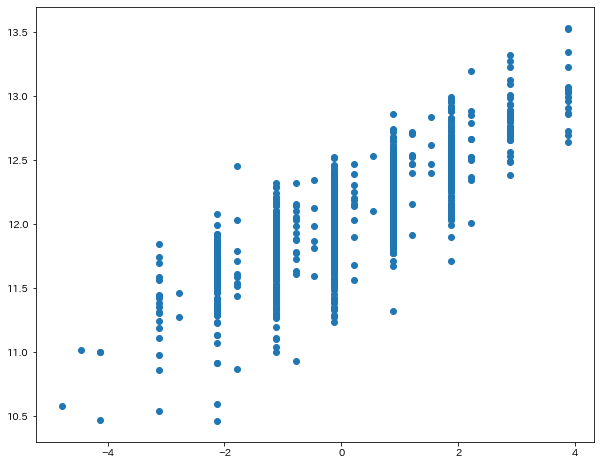

In [444]:
plt.scatter(x=delta_f['delta_mean_LandSlope_OverallQual'], y=delta_f['SalePrice'])

In [791]:
mean_corr_y = mean_f.corr()
mean_corr_y = pd.DataFrame(mean_corr_y['SalePrice'].sort_values(ascending=False)).reset_index()
mean_corr_y.columns = ['a', 'b']
mean_corr_y.head(30)

,a,b
0,SalePrice,1.000000
1,mean_Neighborhood_OverallQual,0.720794
2,mean_Neighborhood_GarageCars,0.715279
3,mean_Neighborhood_GarageArea,0.700844
4,mean_ExterQual_OverallQual,0.681916
5,mean_ExterQual_WoodDeckSF,0.681124
6,mean_ExterQual_GarageArea,0.680551
7,mean_ExterQual_GarageCars,0.678926
8,mean_Neighborhood_TotalBsmtSF,0.678247
9,mean_ExterQual_OpenPorchSF,0.677154


In [794]:
mean_ef = []
for row in np.arange(30):
    if mean_corr_y.iloc[row].b != 1:
        if mean_corr_y.iloc[row].b > 0.7:
            mean_ef.append(mean_corr_y.iloc[row].a)

In [797]:
mean_ef

['mean_Neighborhood_OverallQual',
 'mean_Neighborhood_GarageCars',
 'mean_Neighborhood_GarageArea']

In [800]:
many_corr_y = many_f.corr()
many_corr_y = pd.DataFrame(many_corr_y['SalePrice'].sort_values(ascending=False)).reset_index()
many_corr_y.columns = ['a', 'b']
many_corr_y.head(30)

,a,b
0,SalePrice,1.000000
1,1stFlrSF_div_PoolArea,0.951971
2,GarageCars_div_PoolArea,0.841011
3,OverallQual_mult_GrLivArea,0.838445
4,GrLivArea_mult_OverallQual,0.838445
5,OverallQual_mult_YearBuilt,0.827942
6,YearBuilt_mult_OverallQual,0.827942
7,OverallQual_mult_YearRemodAdd,0.825920
8,YearRemodAdd_mult_OverallQual,0.825920
9,GrLivArea_div_PoolArea,0.823449


In [803]:
many_ef = []
for row in np.arange(30):
    if many_corr_y.iloc[row].b != 1:
        if many_corr_y.iloc[row].b > 0.8:
            many_ef.append(many_corr_y.iloc[row].a)

In [804]:
many_ef

['1stFlrSF_div_PoolArea',
 'GarageCars_div_PoolArea',
 'OverallQual_mult_GrLivArea',
 'GrLivArea_mult_OverallQual',
 'OverallQual_mult_YearBuilt',
 'YearBuilt_mult_OverallQual',
 'OverallQual_mult_YearRemodAdd',
 'YearRemodAdd_mult_OverallQual',
 'GrLivArea_div_PoolArea',
 'OverallQual_div_YrSold',
 'YrSold_mult_OverallQual',
 'OverallQual_mult_YrSold',
 'GarageCars_mult_OverallQual',
 'OverallQual_mult_GarageCars',
 'OverallQual_div_YearRemodAdd',
 'OverallQual_div_GarageYrBlt',
 'OverallQual_div_YearBuilt',
 'GrLivArea_div_HalfBath',
 'GrLivArea_mult_GarageCars',
 'GarageCars_mult_GrLivArea']

In [1550]:
a = [ 'Has_no_Bsmt',
       'IsElectricalSBrkr',
       'IsGarageDetached', 'IsPavedDrive', 
       'RecentRemodel', 'VeryNewHouse',  'NewerDwelling', 'GarageStatus',
       'BsmtStatus', 'FirePlaceStatus', 'PoolStatus', 'cond_mult_qual',
       'HasPorch', 'Totalsqrfootage',
       'Total_Bathrooms', 'SaleCondition_PriceDown', 'BoughtOffPlan',
       'TotalArea', 'TotalArea1st2nd',
       'YearsSinceRemodel',
       'SimplOverallQual', 'SimplOverallCond', 'BadCond', 'SimplPoolQC',
       'SimplFireplaceQu',
       'SimplKitchenQual', 'SimplHeatingQC',
       'SimplBsmtCond',
       'SimplBsmtQual', 'SimplExterQual',
       'NeighborhoodBin', 'Neighborhood_Good']

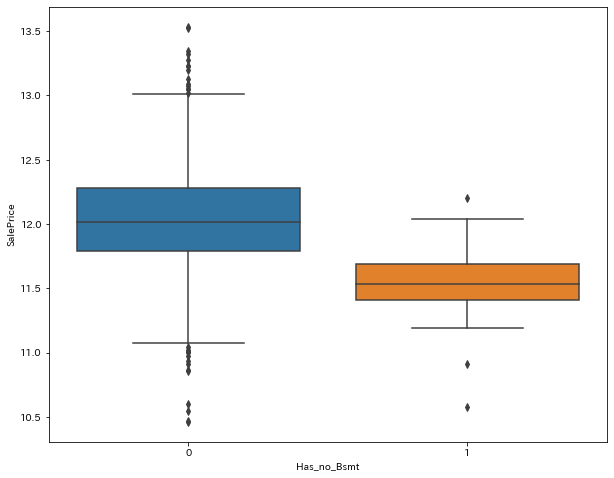

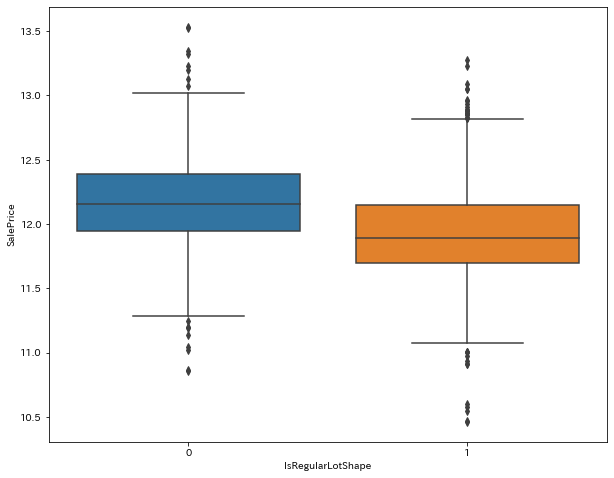

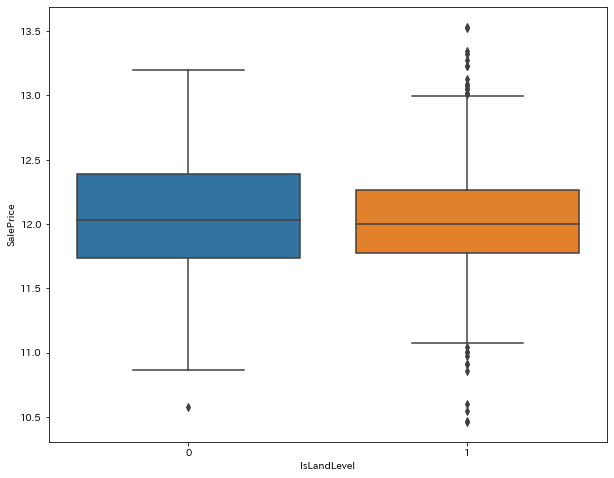

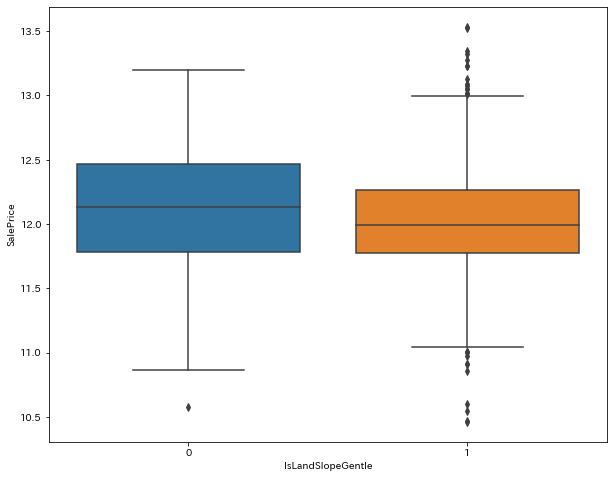

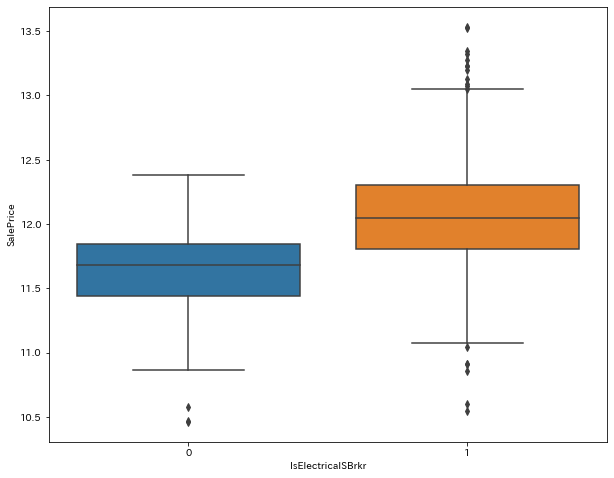

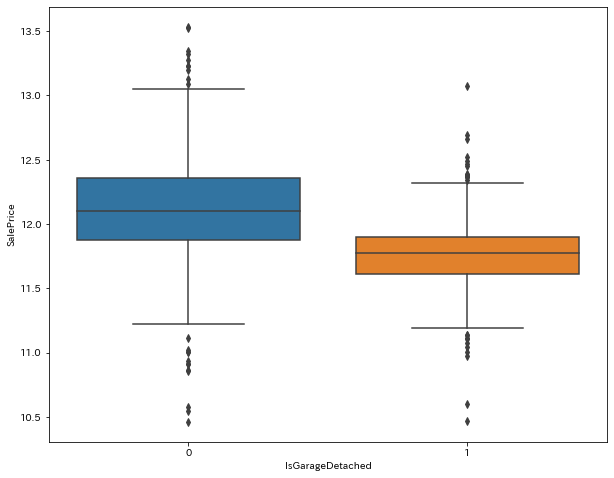

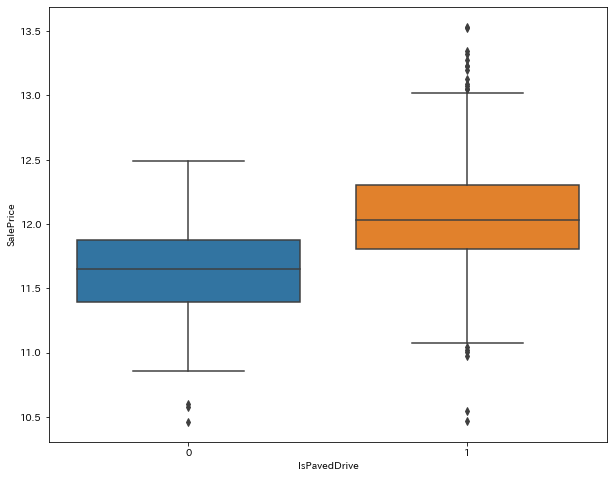

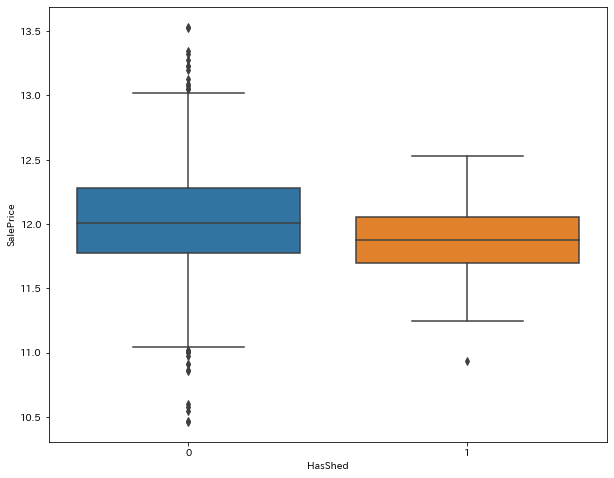

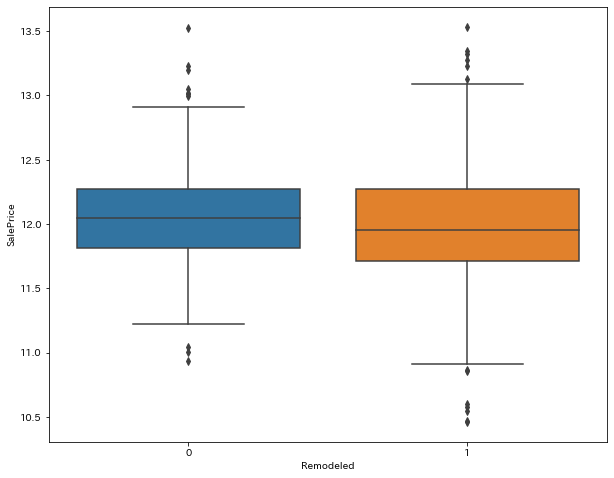

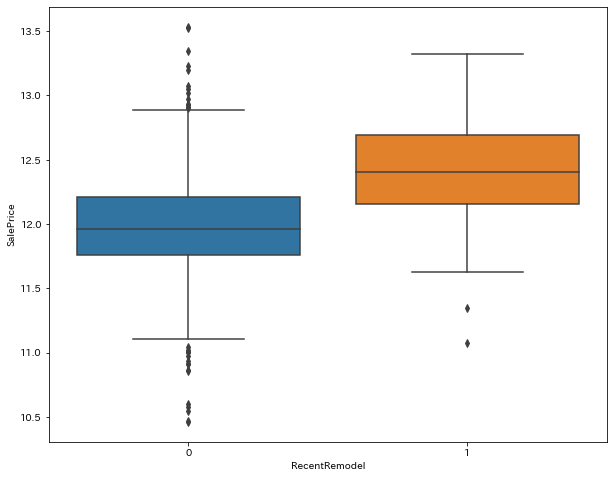

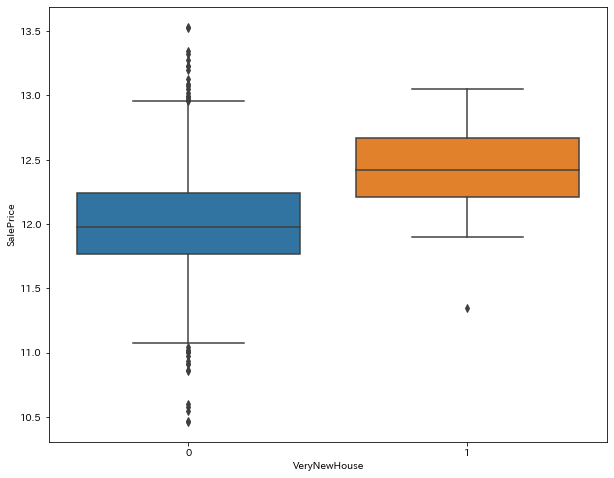

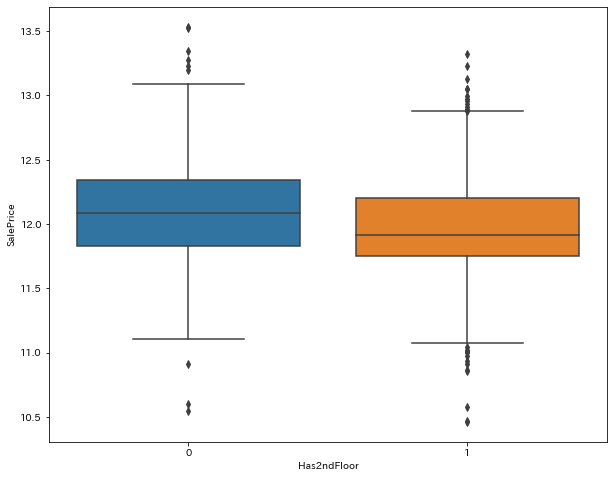

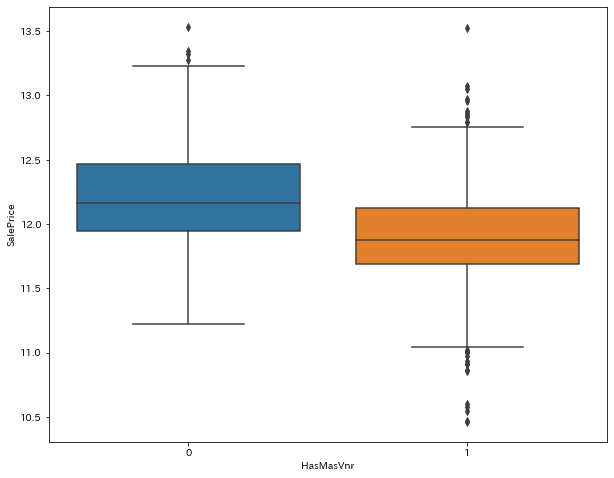

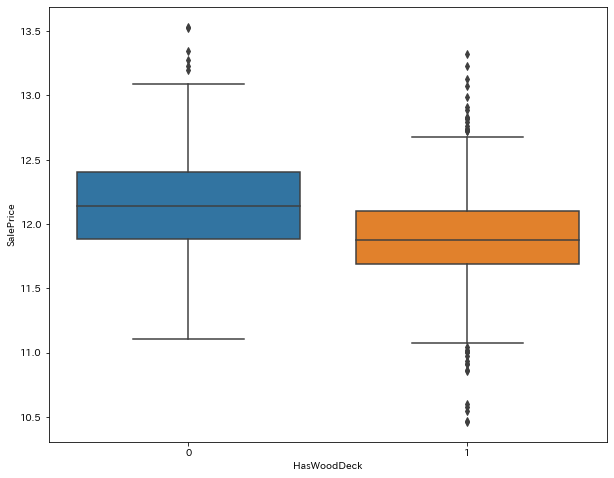

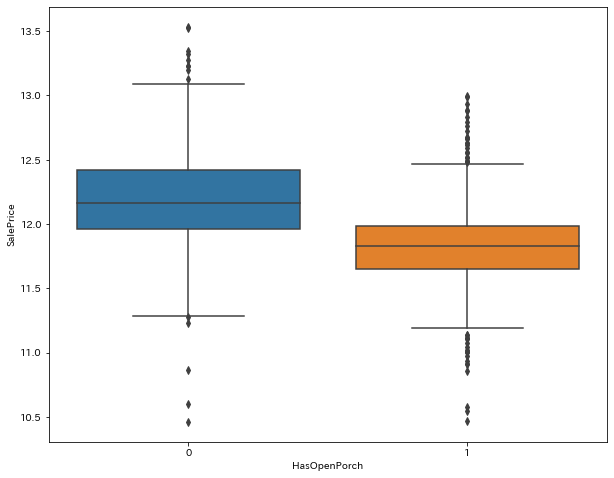

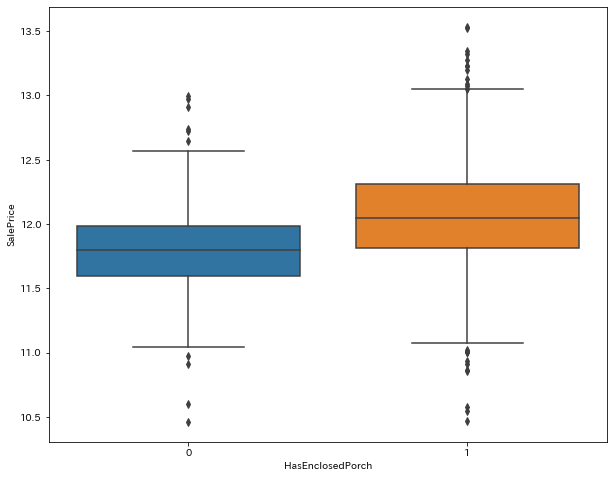

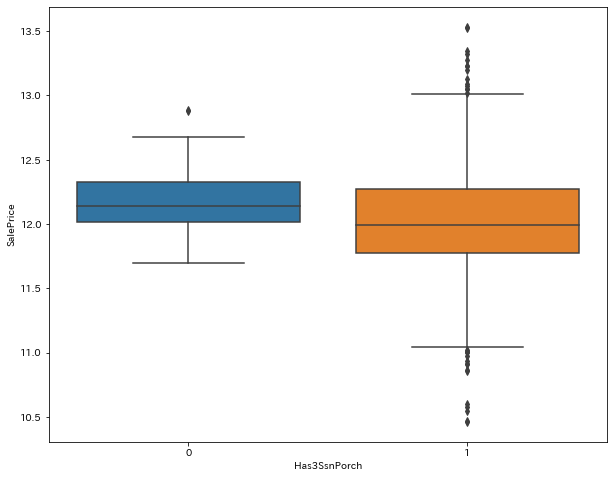

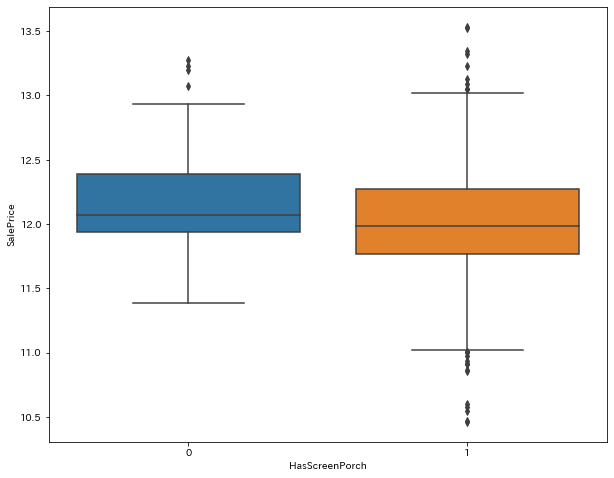

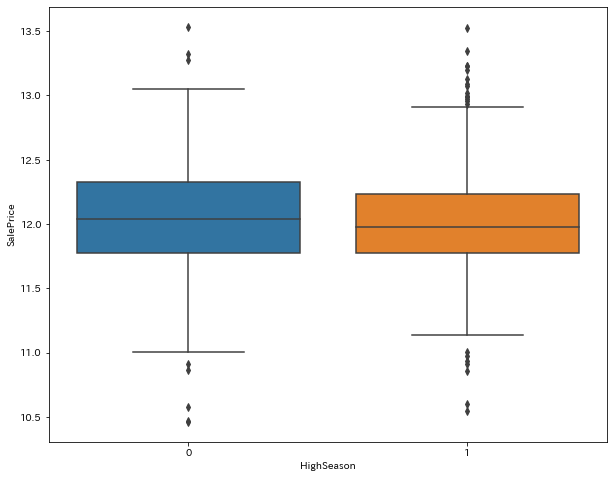

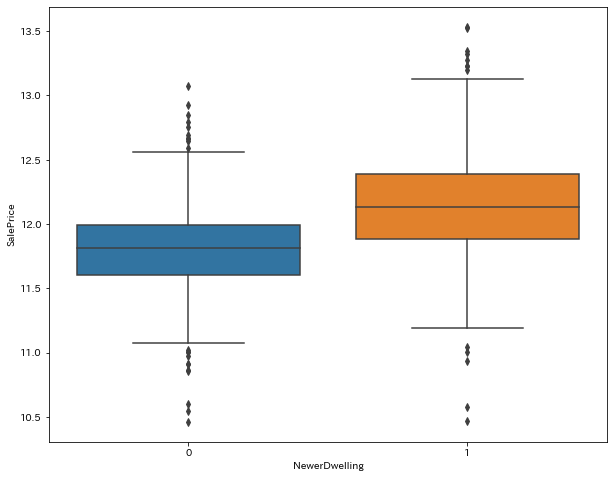

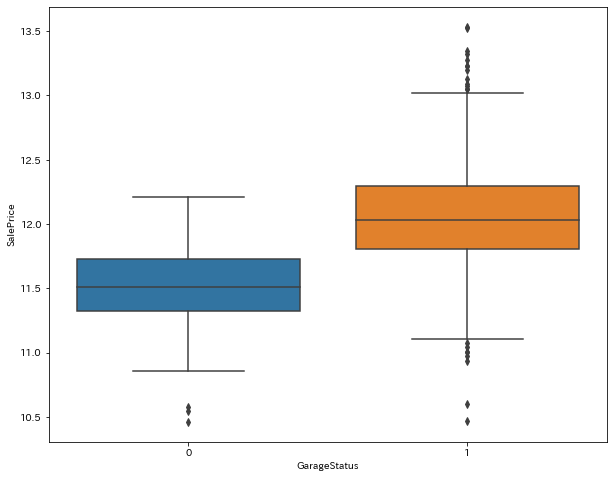

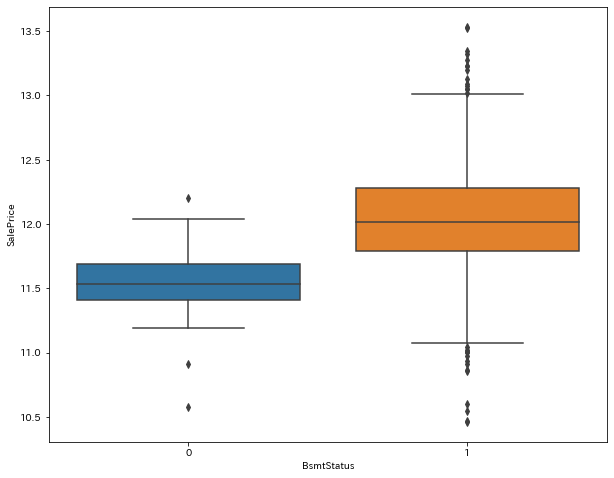

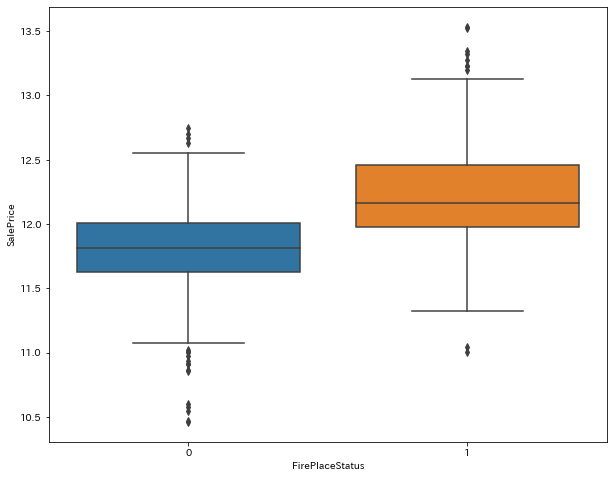

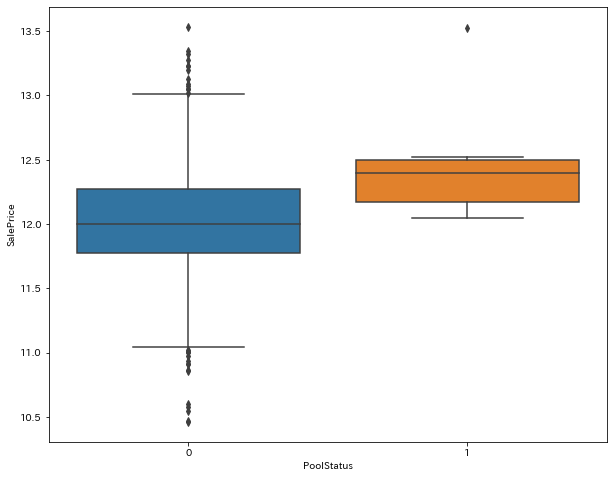

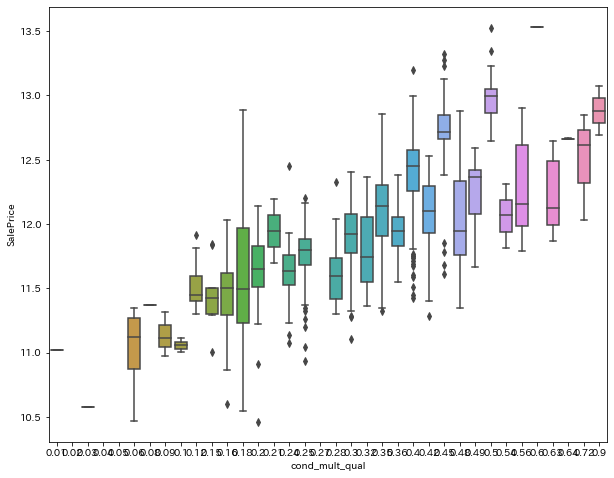

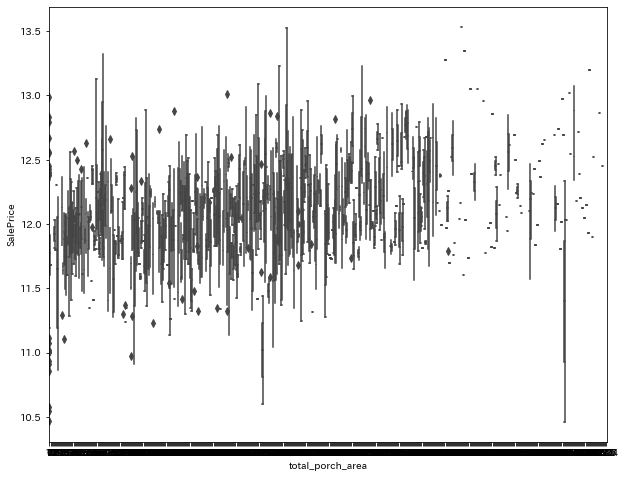

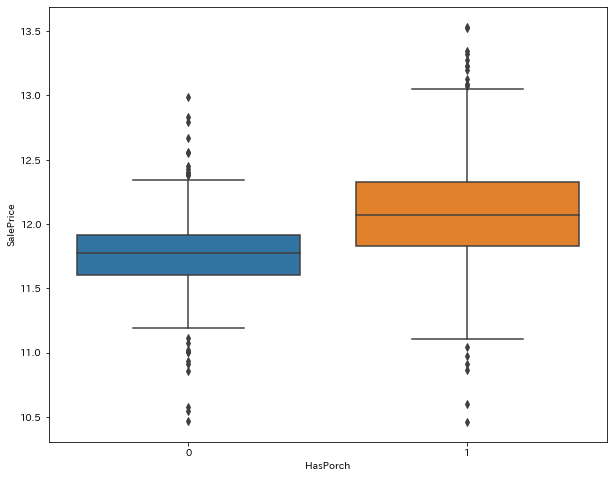

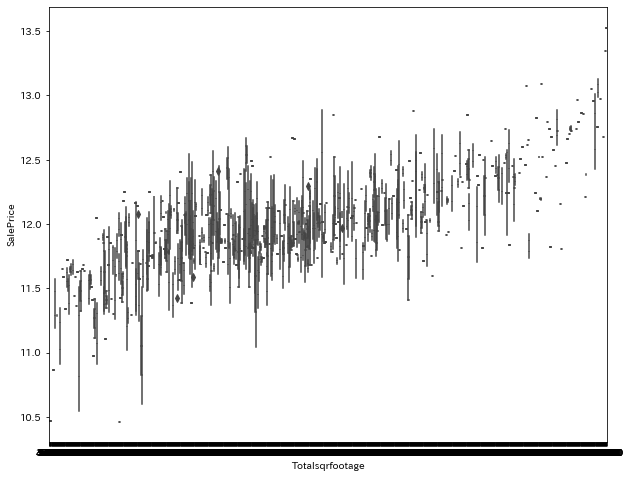

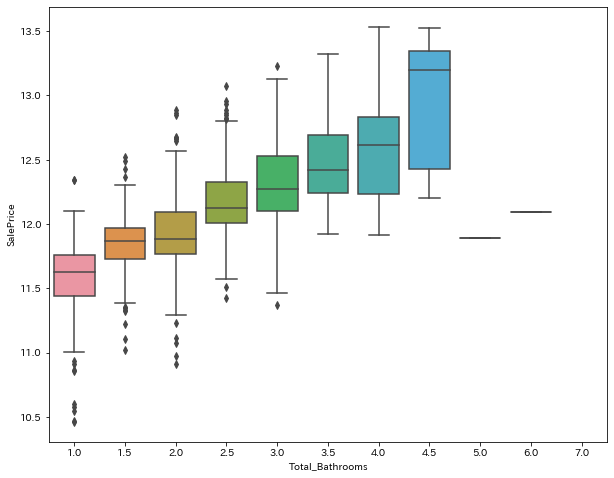

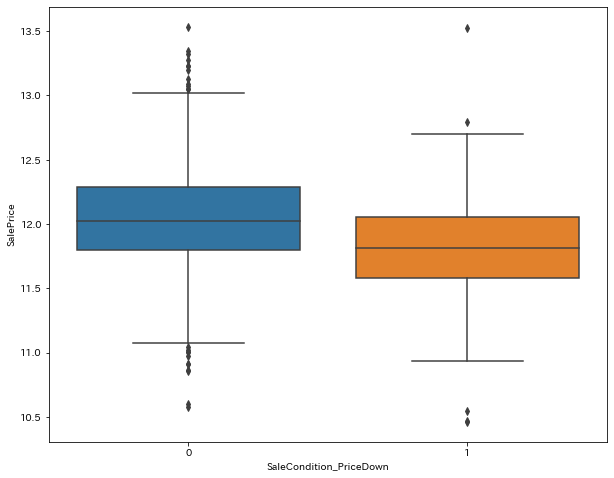

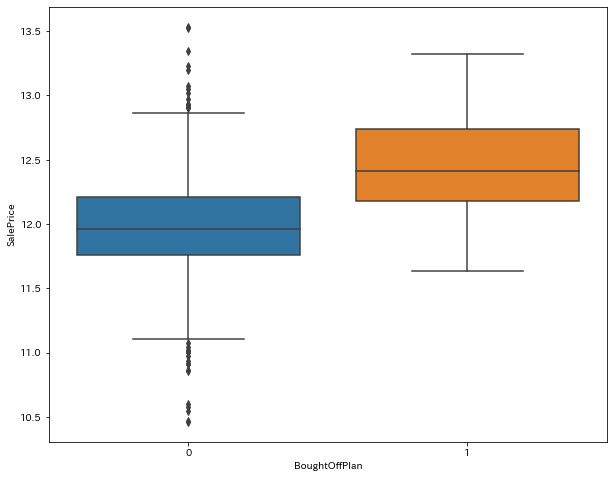

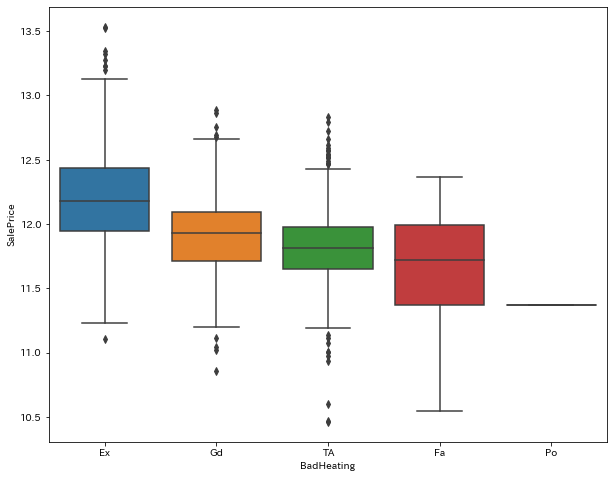

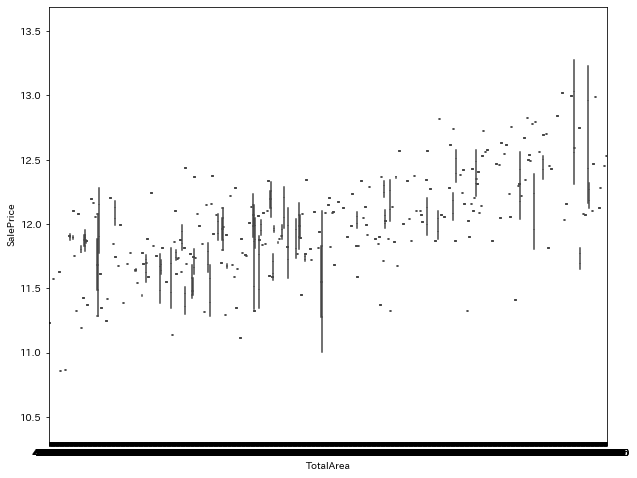

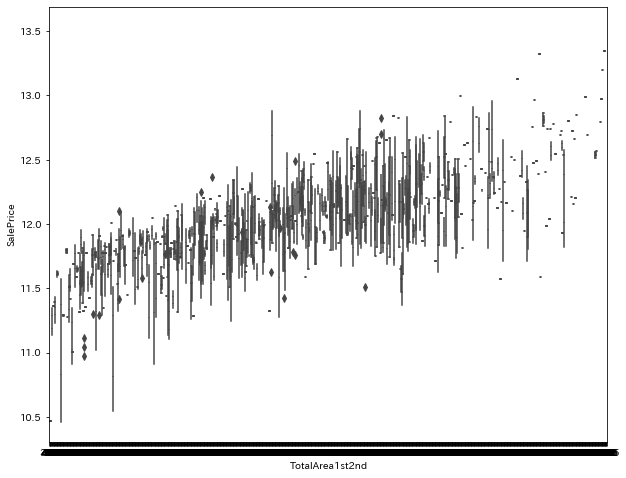

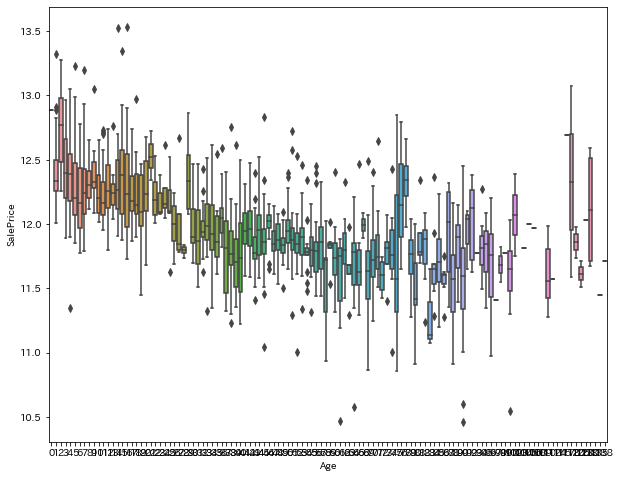

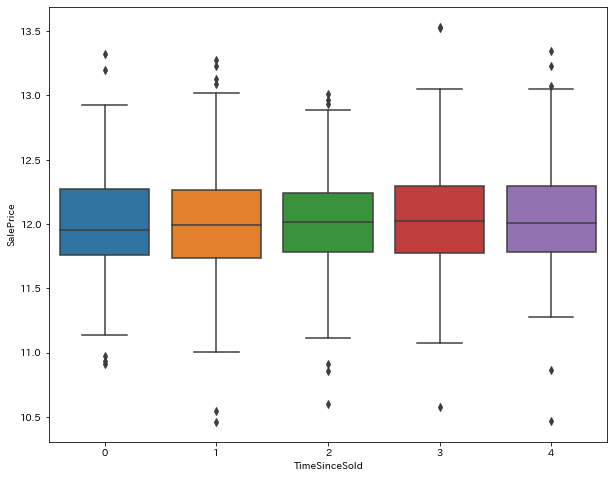

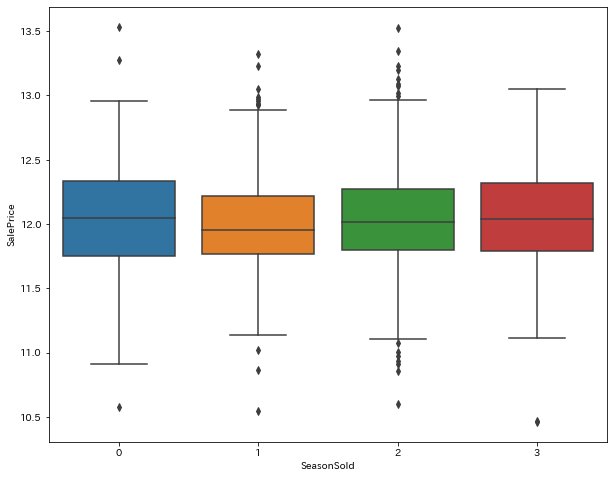

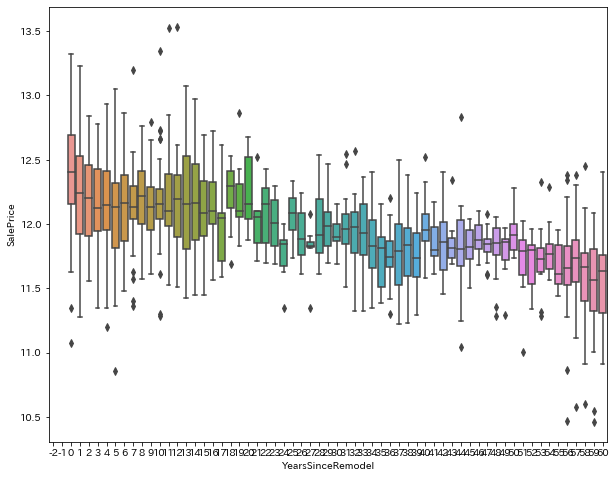

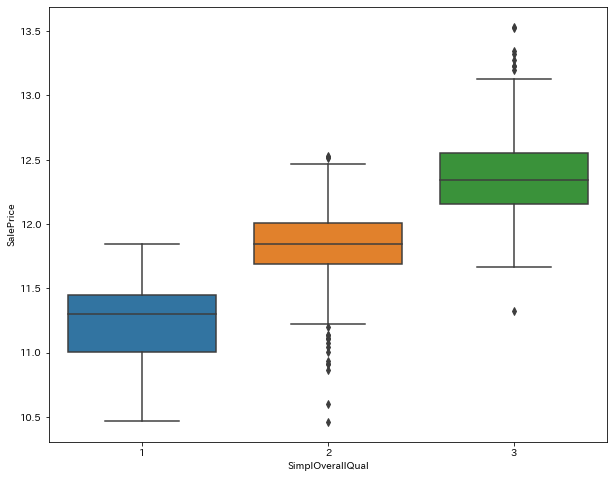

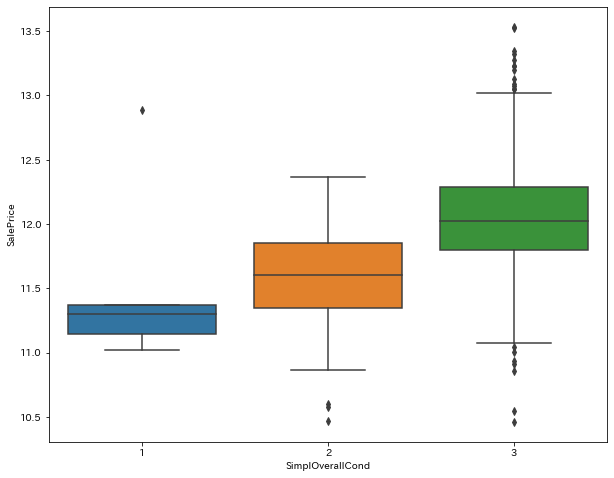

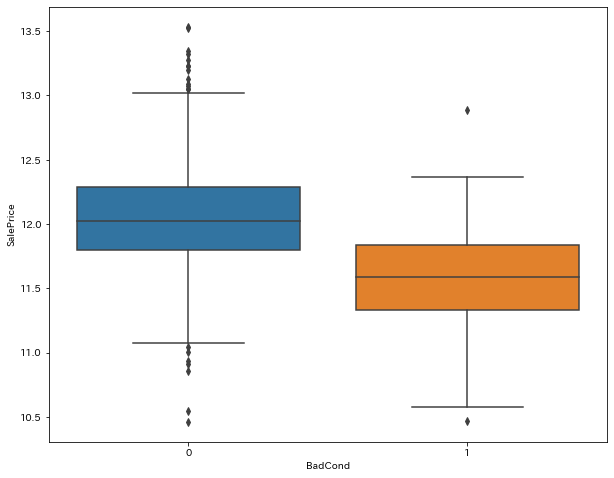

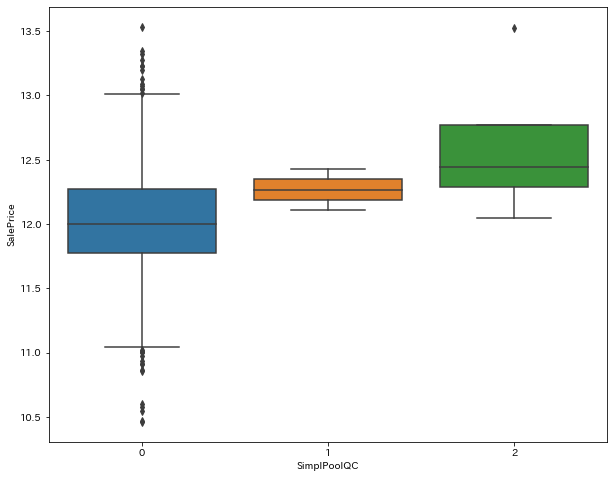

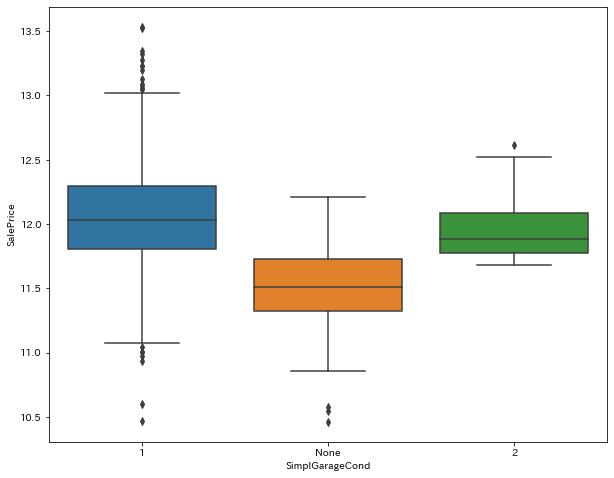

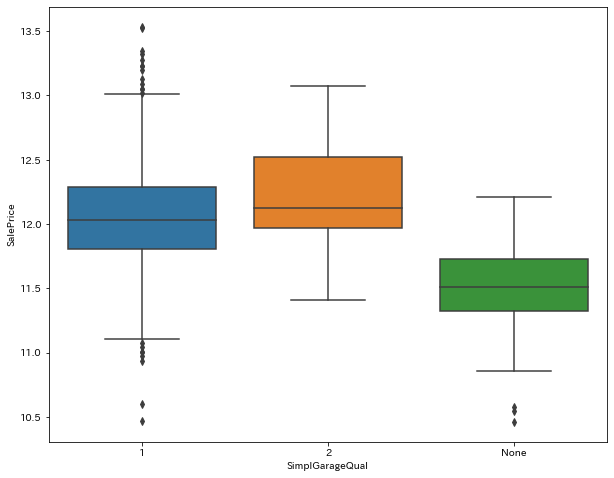

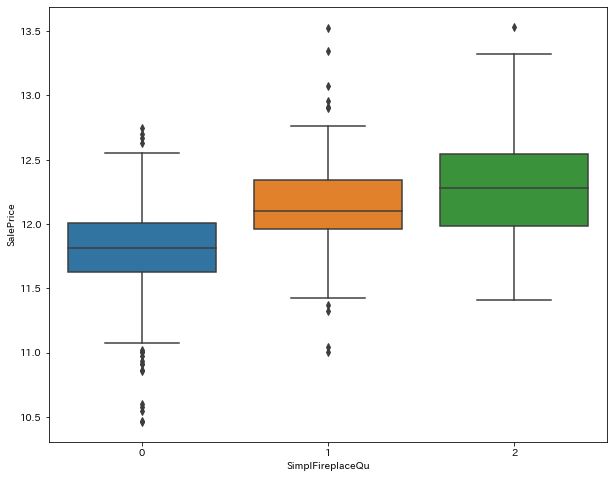

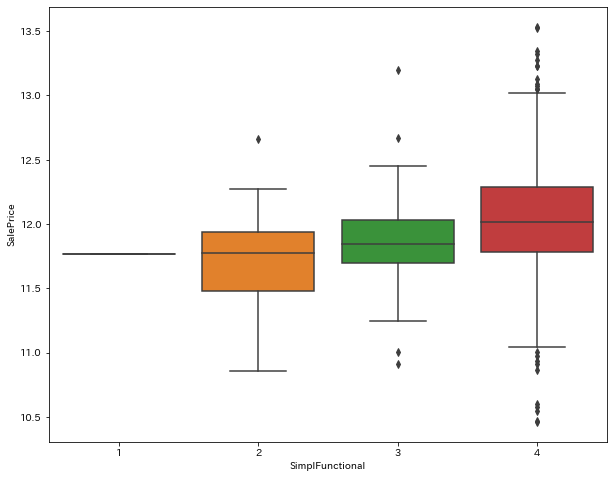

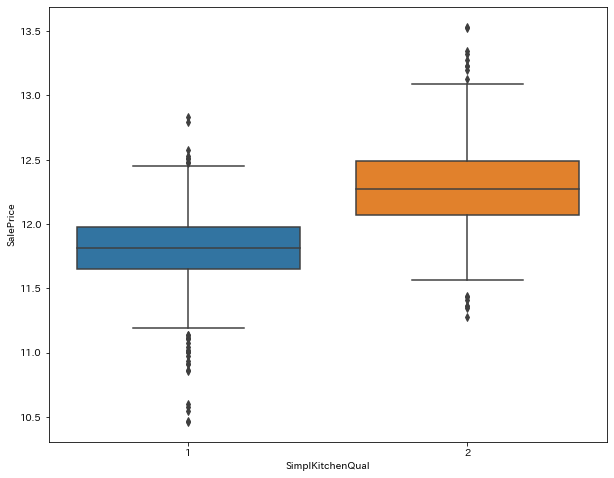

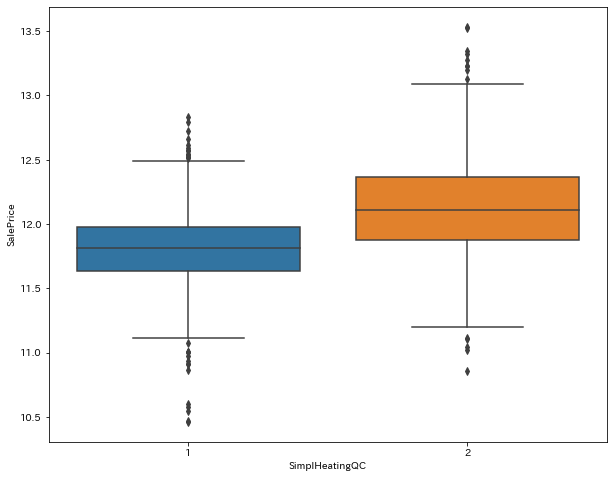

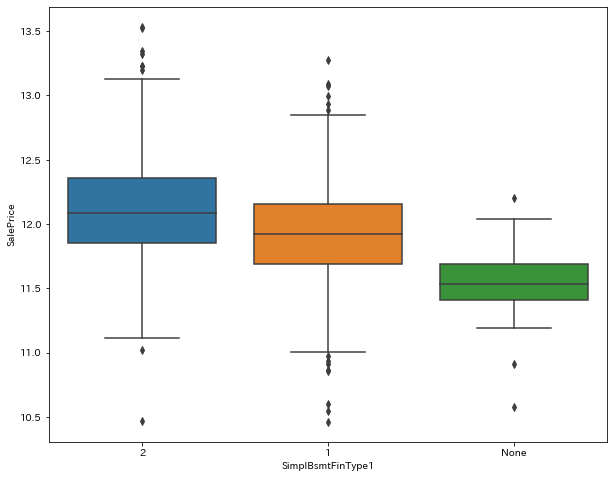

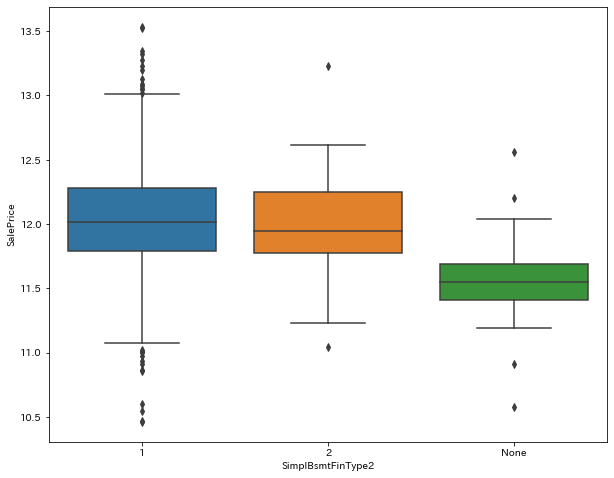

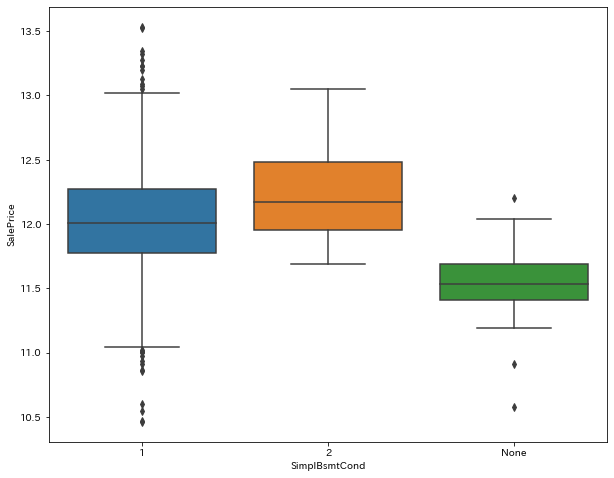

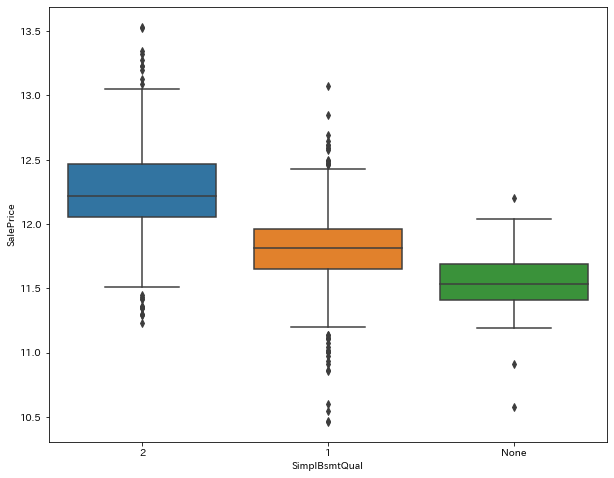

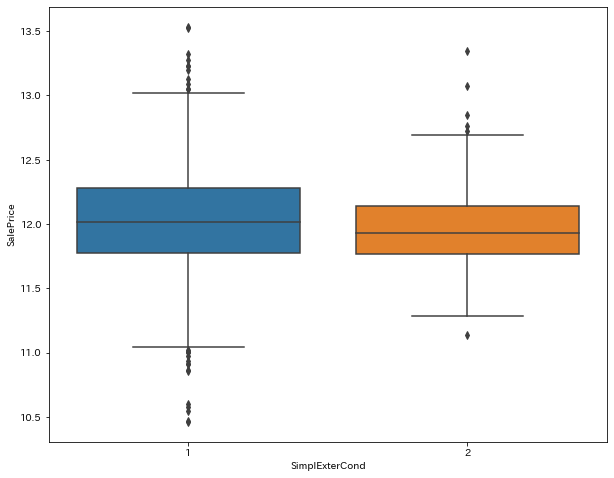

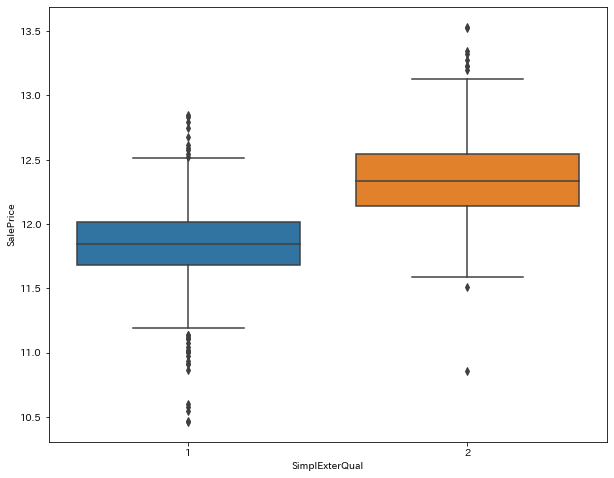

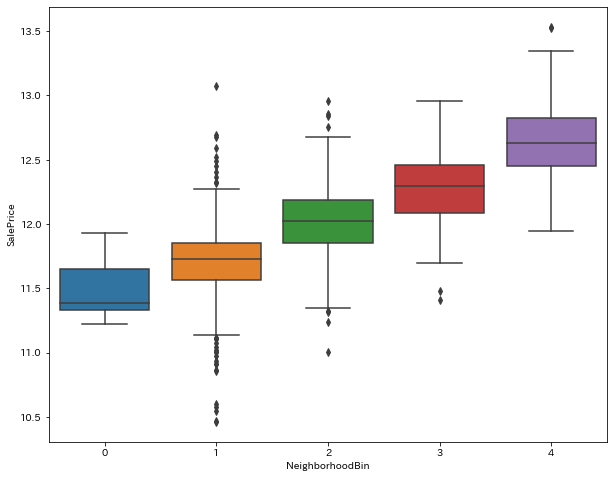

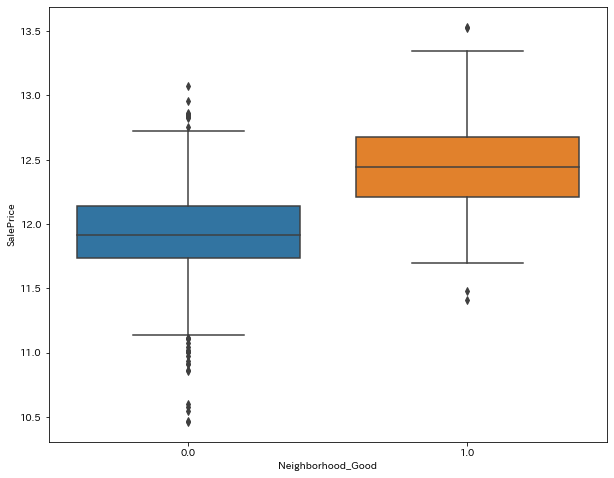

In [1553]:
for i in a:
    sns.boxplot(x=i, y='SalePrice', data=alldata1)
    plt.show()

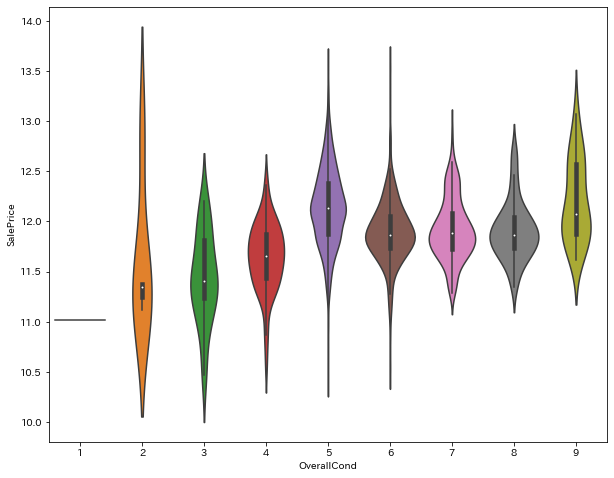

In [1470]:
sns.violinplot(x='OverallCond', y='SalePrice', data=alldata)

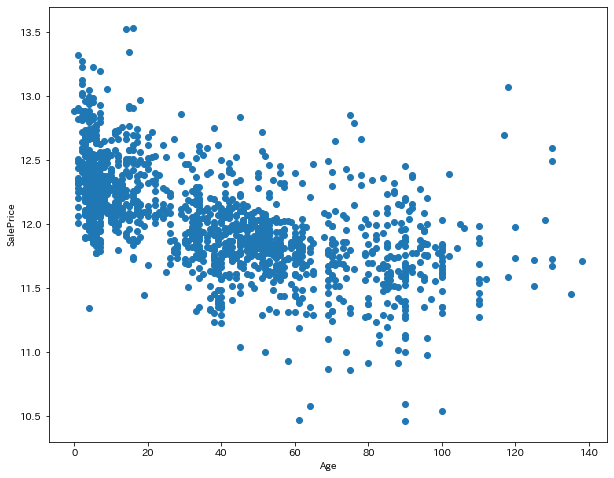

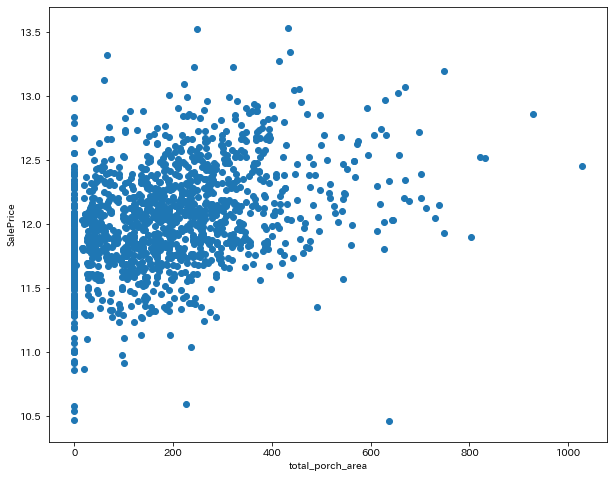

In [1267]:
for i in ['Age', 'total_porch_area']:
    plt.scatter(x=alldata[i], y=alldata['SalePrice'])
    plt.xlabel(i)
    plt.ylabel('SalePrice')
    plt.show()

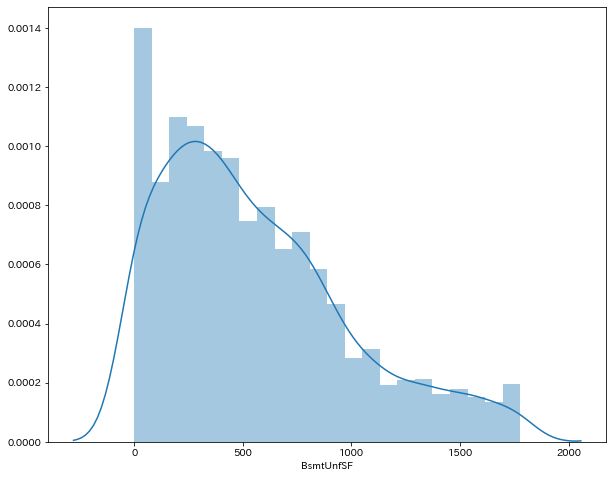

In [2256]:
sns.distplot(alldata['BsmtUnfSF'])

In [2255]:
p01 = alldata['BsmtUnfSF'].quantile(0.01)
p99 = alldata['BsmtUnfSF'].quantile(0.99)
alldata['BsmtUnfSF'] = alldata['BsmtUnfSF'].clip(p01, p99)

alldata['binned_'+ 'BsmtUnfSF'] = pd.cut(alldata['BsmtUnfSF'], 30 ,labels=False)

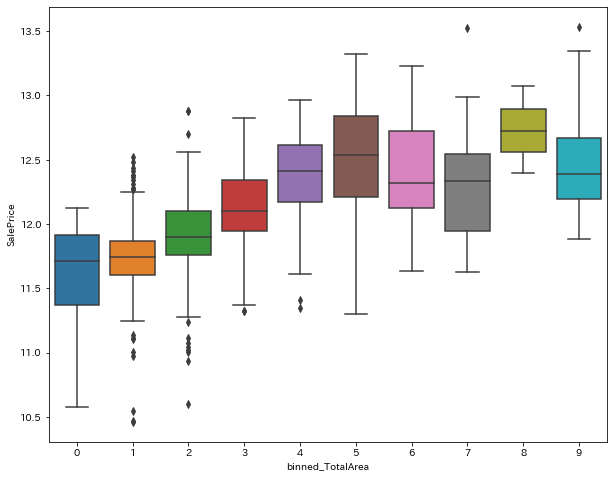

In [2272]:
sns.boxplot('binned_'+ 'TotalArea', 'SalePrice', data=alldata)

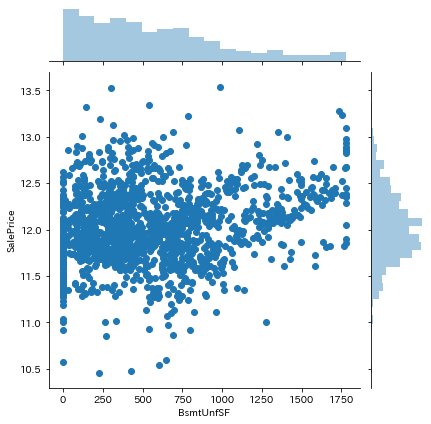

In [2259]:
sns.jointplot(x='BsmtUnfSF', y='SalePrice', data=alldata)